In [1]:
from datetime import timedelta
import torch
from torch.autograd import Variable
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models,transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader,random_split
import numpy as np 
import pandas as pd
import os
import time
import random
import matplotlib.pyplot as plt 
from torch.autograd import Function
from collections import OrderedDict
import torch.nn as nn
import math
import torchvision.models as models
import pickle
from tqdm.auto import tqdm
import cv2
import wandb
from sklearn.model_selection import KFold
import glob
from sklearn.manifold import TSNE
import seaborn as sns
import collections
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap
import umap.umap_ as UMAP
import pims

/home/anagara8/.conda/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ResizeConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, scale_factor, mode='nearest'):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        x = self.conv(x)
        return x

class BasicBlockEnc(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = in_planes*stride

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        if stride == 1:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class BasicBlockDec(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = int(in_planes/stride)

        self.conv2 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_planes)
        # self.bn1 could have been placed here, but that messes up the order of the layers when printing the class

        if stride == 1:
            self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential()
        else:
            self.conv1 = ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential(
                ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn2(self.conv2(x)))
        out = self.bn1(self.conv1(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet18Enc(nn.Module):
    def __init__(self, z_dim=32):
        super(ResNet18Enc, self).__init__()
        self.z_dim = z_dim
        self.ResNet18 = models.resnet18(pretrained=True)
        self.num_feature = self.ResNet18.fc.in_features
        self.ResNet18.fc = nn.Linear(self.num_feature, 1*self.z_dim)
        
    def forward(self, x):
        x = self.ResNet18(x)
        return x

class ResNet18Dec(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=32, nc=3):
        super().__init__()
        self.in_planes = 512

        self.linear = nn.Linear(z_dim, 512)

        self.layer4 = self._make_layer(BasicBlockDec, 256, num_Blocks[3], stride=2)
        self.layer3 = self._make_layer(BasicBlockDec, 128, num_Blocks[2], stride=2)
        self.layer2 = self._make_layer(BasicBlockDec, 64, num_Blocks[1], stride=2)
        self.layer1 = self._make_layer(BasicBlockDec, 64, num_Blocks[0], stride=1)
        self.conv1 = ResizeConv2d(64, nc, kernel_size=3, scale_factor=2)

    def _make_layer(self, BasicBlockDec, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in reversed(strides):
            layers += [BasicBlockDec(self.in_planes, stride)]
        self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, z):
        x = self.linear(z)
        x = x.view(z.size(0), 512, 1, 1)
        x = F.interpolate(x, scale_factor=7)
        x = self.layer4(x)
        x = self.layer3(x)
        x = self.layer2(x)
        x = self.layer1(x)
        x = F.interpolate(x, size=(112,112), mode='bilinear')
        x = torch.sigmoid(self.conv1(x))
        # [x, channels, height, width]
        x = x.view(x.size(0), 3, 224, 224)
        return x

class newAE(nn.Module):

    def __init__(self, z_dim):
        super(newAE, self).__init__()
        self.encoder = ResNet18Enc(z_dim=z_dim)
        self.decoder = ResNet18Dec(z_dim=z_dim)

    def forward(self, x):
        z = self.encoder(x)
#         mean, logvar = self.encoder(x)
#         z = self.reparameterize(mean, logvar)
        x = self.decoder(z)
        return x

    @staticmethod
    def reparameterize(mean, logvar):
        std = torch.exp(logvar / 2) # in log-space, squareroot is divide by two
        epsilon = torch.randn_like(std)
        return epsilon * std + mean

In [3]:
ae_model_mse = newAE(32)
ae_model_mse = nn.DataParallel(ae_model_mse)
ae_model_mse = ae_model_mse.cuda()
ae_model_mse.load_state_dict(torch.load("new_architecture_MSE_e2400.p"))
ae_model_mse.eval()

DataParallel(
  (module): newAE(
    (encoder): ResNet18Enc(
      (ResNet18): ResNet(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(

In [51]:
# Loading all frames
start = time.time()
all_frames_list = np.load("all_frame_and_action_list.npy")
# all_latents_array = np.load("all_latents_array.npy")
# all_labels_array = np.load("all_labels_array.npy")
end = time.time()
print("Training File List containing", len(all_frames_list), "frames loaded in:", end - start)
# print("Latents:", len(all_latents_array), "Labels:", len(all_labels_array))

Training File List containing 8387210 frames loaded in: 1.1148340702056885


In [52]:
# Randomly shuffling ALL frames
random.seed(42)
random.shuffle(all_frames_list)

In [45]:
# Loading from saved pickles
all_labels_array = np.load("1mil_labels_array_mse_model.npy")
all_latents_array = np.load("1mil_latents_array_mse_model.npy")
training_frame_list = []

In [53]:
# Balancing the Training List

final_training_list = []

preexposure_count = 0
postcond_count = 0
postext_count = 0
postret_count = 0

# 1353968 -> Number of frames of postret (smallest class)
for sample in all_frames_list:
    if "preexposure" in sample:
        if preexposure_count < 250000:
            final_training_list.append(sample)
            preexposure_count += 1
    elif "postcond" in sample:
        if postcond_count < 250000:
            final_training_list.append(sample)
            postcond_count += 1
    elif "postext" in sample:
        if postext_count < 250000:
            final_training_list.append(sample)
            postext_count += 1
    elif "postret" in sample:
        if postret_count < 250000:
            final_training_list.append(sample)
            postret_count += 1
            
print("Length of final_training_list:", len(final_training_list), "with", preexposure_count, "Preexposure", postcond_count, "Postcond", postext_count, "Postext", postret_count, "Postret.")

Length of final_training_list: 1000000 with 250000 Preexposure 250000 Postcond 250000 Postext 250000 Postret.


In [57]:
# all_latents_array = []
# all_labels_array = []

In [58]:
image_count = 0

for image in final_training_list[len(all_labels_array):]:
    image_count += 1
    if image_count % 10000 == 0:
        print("Processed", image_count, "Images..")
    name = image
    if "preexposure" in name:
        append_name = "/media/data_cifs/anagara8/preexposure_action/"
    elif "postcond" in name:
        append_name = "/media/data_cifs/anagara8/postcond_action/"
    elif "postext" in name:
        append_name = "/media/data_cifs/anagara8/postext_action/"
    elif "postret" in name:
        append_name = "/media/data_cifs/anagara8/postret_action/"
    
    image = cv2.imread(append_name + image)
    image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_AREA)
    tensor_frame = torchvision.transforms.functional.to_tensor(image).unsqueeze(0).cuda()
    with torch.no_grad():
        latent_representation = ae_model_mse.module.encoder(tensor_frame)
    all_latents_array.append(latent_representation.squeeze().cpu().numpy())
    
    # Append One Hot encoded Labels
    if "preexposure" in name:
        all_labels_array.append([1.0, 0.0, 0.0, 0.0])
    elif "postcond" in name:
        all_labels_array.append([0.0, 1.0, 0.0, 0.0])
    elif "postext" in name:
        all_labels_array.append([0.0, 0.0, 1.0, 0.0])
    elif "postret" in name:
        all_labels_array.append([0.0, 0.0, 0.0, 1.0])
    else:
        print("ERROR: Incorrect Experiment Phase, no label associated.")

        
print("All done!")

Processed 10000 Images..
Processed 20000 Images..
Processed 30000 Images..
Processed 40000 Images..
Processed 50000 Images..
Processed 60000 Images..
Processed 70000 Images..
Processed 80000 Images..
Processed 90000 Images..
Processed 100000 Images..
Processed 110000 Images..
Processed 120000 Images..
Processed 130000 Images..
Processed 140000 Images..
Processed 150000 Images..
Processed 160000 Images..
Processed 170000 Images..
Processed 180000 Images..
Processed 190000 Images..
Processed 200000 Images..
Processed 210000 Images..
Processed 220000 Images..
Processed 230000 Images..
Processed 240000 Images..
Processed 250000 Images..
Processed 260000 Images..
Processed 270000 Images..
Processed 280000 Images..
Processed 290000 Images..
Processed 300000 Images..
Processed 310000 Images..
Processed 320000 Images..
Processed 330000 Images..
Processed 340000 Images..
Processed 350000 Images..
Processed 360000 Images..
Processed 370000 Images..
Processed 380000 Images..
Processed 390000 Imag

In [59]:
# Save the Latents and Labels
# np.save("all_latents_array_1m.npy", all_latents_array)
# np.save("all_labels_array_1m.npy", all_labels_array)
# np.save("final_training_list_1m.npy", final_training_list)

In [63]:
# Sanity Check to ensure Labels, Latents and Frames are corresponding
# Cannot check the latents, but checking the labels with the frames
sanity_check_labels = []

for i in range(len(final_training_list)):
    name = final_training_list[i]
    if "preexposure" in name:
        sanity_check_label = [1.0, 0.0, 0.0, 0.0]
    elif "postcond" in name:
        sanity_check_label = [0.0, 1.0, 0.0, 0.0]
    elif "postext" in name:
        sanity_check_label = [0.0, 0.0, 1.0, 0.0]
    elif "postret" in name:
        sanity_check_label = [0.0, 0.0, 0.0, 1.0]
        
    assert(np.array_equal(sanity_check_label, all_labels_array[i]))

In [66]:
# Exclusive Testing List
all_frames_set = set(all_frames_list)
final_training_set = set(final_training_list)

all_frames_list_exclusive = list(all_frames_set - final_training_set)
print("Exclusive Testing List:", len(all_frames_list_exclusive))

final_testing_list = []

preexposure_count = 0
postcond_count = 0
postext_count = 0
postret_count = 0

# 1353968 -> Number of frames of postret (smallest class)
for sample in all_frames_list_exclusive:
    if "preexposure" in sample:
        if preexposure_count < 300000:
            final_testing_list.append(sample)
            preexposure_count += 1
    elif "postcond" in sample:
        if postcond_count < 300000:
            final_testing_list.append(sample)
            postcond_count += 1
    elif "postext" in sample:
        if postext_count < 300000:
            final_testing_list.append(sample)
            postext_count += 1
    elif "postret" in sample:
        if postret_count < 300000:
            final_testing_list.append(sample)
            postret_count += 1
            
print("Length of final_training_list:", len(final_testing_list), "with", preexposure_count, "Preexposure", postcond_count, "Postcond", postext_count, "Postext", postret_count, "Postret.")

Exclusive Testing List: 7387210
Length of final_training_list: 1200000 with 300000 Preexposure 300000 Postcond 300000 Postext 300000 Postret.


In [68]:
# testing_latents_array = []
# testing_labels_array = []

In [ ]:
image_count = 0

for image in final_testing_list[len(testing_labels_array):]:
    image_count += 1
    if image_count % 10000 == 0:
        print("Processed", image_count, "Images..")
    name = image
    if "preexposure" in name:
        append_name = "/media/data_cifs/anagara8/preexposure_action/"
    elif "postcond" in name:
        append_name = "/media/data_cifs/anagara8/postcond_action/"
    elif "postext" in name:
        append_name = "/media/data_cifs/anagara8/postext_action/"
    elif "postret" in name:
        append_name = "/media/data_cifs/anagara8/postret_action/"
    
    image = cv2.imread(append_name + image)
    image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_AREA)
    tensor_frame = torchvision.transforms.functional.to_tensor(image).unsqueeze(0).cuda()
    with torch.no_grad():
        latent_representation = ae_model_mse.module.encoder(tensor_frame)
    testing_latents_array.append(latent_representation.squeeze().cpu().numpy())
    
    # Append One Hot encoded Labels
    if "preexposure" in name:
        testing_labels_array.append([1.0, 0.0, 0.0, 0.0])
    elif "postcond" in name:
        testing_labels_array.append([0.0, 1.0, 0.0, 0.0])
    elif "postext" in name:
        testing_labels_array.append([0.0, 0.0, 1.0, 0.0])
    elif "postret" in name:
        testing_labels_array.append([0.0, 0.0, 0.0, 1.0])
    else:
        print("ERROR: Incorrect Experiment Phase, no label associated.")

        
print("All done!")

Processed 10000 Images..


In [75]:
# Saving testing Latents, Labels and Frames
# np.save("testing_latents_array_2m.npy", testing_latents_array)
# np.save("testing_labels_array_2m.npy", testing_labels_array)
# np.save("final_testing_list_2m.npy", final_testing_list)    

In [4]:
# FINAL DATASETS:

# Training
training_frames = np.load("final_training_list_1m.npy")
training_latents = np.load("all_latents_array_1m.npy")
training_labels = np.load("all_labels_array_1m.npy")

# Testing
testing_frames = np.load("final_testing_list_2m.npy")
testing_latents = np.load("testing_latents_array_2m.npy")
testing_labels = np.load("testing_labels_array_2m.npy")

print("Training-> Frames:", len(training_frames), "Latents:", len(training_latents), "Labels:", len(training_labels))
print("Testing-> Frames:", len(testing_frames), "Latents:", len(testing_latents), "Labels:", len(testing_labels))

Training-> Frames: 1000000 Latents: 1000000 Labels: 1000000
Testing-> Frames: 2000000 Latents: 2000000 Labels: 2000000


# ANIMAL LEVEL ANALYSIS

In [274]:
training_frames[0].split("-0000")[0].split("cam_")[-1]

'6394836'

In [279]:
# Get list of all animals
def get_append_character(name):
    return name[3].lower()

def get_camera_id(name):
    return name.split("-0000")[0].split("cam_")[-1]

all_camera_ids = set()

for idx in range(len(training_frames)):
    camera_id = get_camera_id(training_frames[idx])
    append_character = get_append_character(training_frames[idx])
    all_camera_ids.add(camera_id+"_"+append_character)

for a in all_camera_ids:
    print(a)
    
print(len(all_camera_ids))

6394839_d
17202346_d
17202346_c
17202339_d
17202338_c
17202345_a
6394836_d
6394846_d
17202345_d
17202338_d
17202345_b
17202338_a
6394841_d
17202346_b
17202346_a
17202339_a
17202342_a
6394837_d
17202341_d
17202341_c
17202345_c
6394840_d
17202341_b
17202339_b
17202341_a
17202338_b
17202339_c
17202342_b
17202342_c
17202342_d
30


In [280]:
# Control animal camera IDs:
control_animal_list = ["cam_17202338",
                        "cam_17202345",
                        "cam_17202346",#('9')
                        "cam_6394839",
                        "cam_6394846",
                        "cam_6394840"]

excluded_control_indices = []
control_exclusive_training_frames = []
control_exclusive_training_latents = []
control_exclusive_training_labels = []

for idx in range(len(training_frames)):
    animal_found = False
    if "FC-D" in training_frames[idx]:
        for control_animal in control_animal_list:
            if control_animal in training_frames[idx]:
                excluded_control_indices.append(idx)
                animal_found = True
    if not animal_found:
        control_exclusive_training_frames.append(training_frames[idx])
        control_exclusive_training_latents.append(training_latents[idx])
        control_exclusive_training_labels.append(training_labels[idx])
        
print("New training size without control animals:", len(control_exclusive_training_frames),". Removed indices:", len(excluded_control_indices))

New training size without control animals: 802227 . Removed indices: 197773


# COHORT LEVEL ANALYSIS

In [77]:
# Balancing the Training List
a_count = 0
b_count = 0
c_count = 0
d_count = 0

# 1353968 -> Number of frames of postret (smallest class)
for sample in training_frames:
    if "FC-A" in sample:
#         if preexposure_count < 250000:
#             final_training_list.append(sample)
            a_count += 1
    elif "FC-B" in sample:
#         if postcond_count < 250000:
#             final_training_list.append(sample)
            b_count += 1
    elif "FC-C" in sample:
#         if postext_count < 250000:
#             final_training_list.append(sample)
            c_count += 1
    elif "FC-D" in sample:
#         if postret_count < 250000:
#             final_training_list.append(sample)
            d_count += 1
            
print("Length of final_training_list:", len(training_frames), "with", a_count, "A", b_count, "B", c_count, "C", d_count, "D.")

Length of final_training_list: 1000000 with 235700 Preexposure 186215 Postcond 178401 Postext 399684 Postret.


In [233]:
# Picking Cohort B as it has the least number of aimals to remove (186215)
excluded_cohort = "FC-D"
excluded_cohort_indices = []
cohort_exclusive_training_frames = []
cohort_exclusive_training_latents = []
cohort_exclusive_training_labels = []

for idx in range(len(training_frames)):
    if excluded_cohort in training_frames[idx]:
        excluded_cohort_indices.append(idx)
    else:
        cohort_exclusive_training_frames.append(training_frames[idx])
        cohort_exclusive_training_latents.append(training_latents[idx])
        cohort_exclusive_training_labels.append(training_labels[idx])
        
print("New training size without", excluded_cohort, ":", len(cohort_exclusive_training_frames),". Removed indices:", len(excluded_cohort_indices))

New training size without FC-D : 600316 . Removed indices: 399684


In [281]:
# Creating the DataLoader
class LatentDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, augmentations = None):
        super(LatentDataset, self).__init__()
        
        # Latents are stored as the first element
        self.vector_list = [item[0] for item in dataset]
        # Labels are stored as the second element
        self.label_list = [item[1] for item in dataset]
        
        self.augmentations = augmentations
    
    def __len__(self):
        return len(self.label_list)

    def __getitem__(self, idx):
        vector = torch.tensor(self.vector_list[idx])
        label = torch.tensor(self.label_list[idx])
        return vector, label

In [359]:
shuffled_training_labels = []

label_dict = {0:[1.0, 0.0, 0.0, 0.0], 1:[0.0, 1.0, 0.0, 0.0], 2:[0.0, 0.0, 1.0, 0.0], 3:[0.0, 0.0, 0.0, 1.0]}

count0 = 0
count1 = 0
count2 = 0
count3 = 0

for i in range(len(training_labels)):
    random_idx = int(random.uniform(0, 4))
    shuffled_training_labels.append(label_dict[random_idx])
    
    if random_idx == 0:
        count0 += 1
    elif random_idx == 1:    
        count1 += 1
    elif random_idx == 2:
        count2 += 1
    elif random_idx == 3:
        count3 += 1

print("Label Distribution: 0-", count0, "1-", count1, "2-", count2, "3-", count3)

Label Distribution: 0- 249815 1- 250180 2- 249956 3- 250049


In [383]:
# m = len(cohort_exclusive_training_latents)
m = len(training_latents)
test_train_split = 0.15

torch.manual_seed(42)

train_data, val_data = random_split(list(zip(training_latents, training_labels)), [int(math.ceil(m-m*test_train_split)), int(m*test_train_split)])
print("Length:", len(train_data) + len(val_data), "-> Training set size:", len(train_data), "| Validation set size:", len(val_data))

Length: 1000000 -> Training set size: 850000 | Validation set size: 150000


In [384]:
train_dataset = LatentDataset(train_data)
val_dataset = LatentDataset(val_data)

In [385]:
batch_size = 2048

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers = 4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers = 4, shuffle=False)

In [7]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 128)
        self.hidden_fc1 = nn.Linear(128, 64)
        self.hidden_fc2 = nn.Linear(64, 32)
        self.output_fc = nn.Linear(32, output_dim)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        h_1 = F.relu(self.input_fc(x))
        h_2 = F.relu(self.hidden_fc1(h_1))
        h_3 = F.relu(self.hidden_fc2(h_2))
        y_out = self.output_fc(h_3)
        y_pred = torch.sigmoid(y_out)
        
        return y_out

In [8]:
INPUT_DIM = 32
OUTPUT_DIM = 4

model = MLP(INPUT_DIM, OUTPUT_DIM)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using", device)

Using cuda


In [10]:
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr = 0.000001)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [390]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def calculate_accuracy(y_pred, y):
    y_pred = torch.argmax(y_pred, dim = 1)
    y = torch.argmax(y, dim = 1)
    
    acc = torch.unique(y_pred[y_pred==y], return_counts = True)[1].sum()
    acc = acc / y.shape[0]
    return acc

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,692 trainable parameters


In [391]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    with torch.no_grad():
        for sample in tqdm(iterator, desc="Validating", leave=False):
            latent, label = sample
        
            latent = latent.to(device)
            label = label.squeeze().to(device)
            
            y_pred = model(latent)

            loss = criterion(y_pred, label)
            acc = calculate_accuracy(y_pred, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [392]:
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for sample in tqdm(iterator, desc="Training", leave=False):
        latent, label = sample
        
        latent = latent.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        y_pred = model(latent)

        loss = criterion(y_pred, label)
        acc = calculate_accuracy(y_pred, label)
        
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [393]:
EPOCHS = 1000
best_valid_loss = float('inf')

list_train_loss = []
list_val_loss = []

list_train_acc = []
list_val_acc = []

In [394]:
for epoch in range(EPOCHS):
    start_time = time.monotonic()
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, device)
    
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.7f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.7f} |  Val. Acc: {valid_acc*100:.2f}%')
    
    list_val_loss.append(valid_loss)
    list_train_loss.append(train_loss)
    
    list_val_acc.append(valid_acc)
    list_train_acc.append(train_acc)
    
    if (epoch %20 == 0 or epoch % 10 == 0) and valid_loss < best_valid_loss:
        torch.save(model.state_dict(), "./LinearClassifierModels/control_exclusive_e"+str(epoch)+"_v"+str(valid_acc)+".p")
print('Finished Training')

Epoch: 01 | Epoch Time: 0m 11s
	Train Loss: 1.3922417 | Train Acc: 25.36%
	 Val. Loss: 1.3916514 |  Val. Acc: 25.29%


Epoch: 02 | Epoch Time: 0m 11s
	Train Loss: 1.3911840 | Train Acc: 25.34%
	 Val. Loss: 1.3906247 |  Val. Acc: 25.30%


Epoch: 03 | Epoch Time: 0m 11s
	Train Loss: 1.3901937 | Train Acc: 25.35%
	 Val. Loss: 1.3896140 |  Val. Acc: 25.33%


Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 1.3892053 | Train Acc: 25.41%
	 Val. Loss: 1.3886135 |  Val. Acc: 25.36%


Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 1.3881735 | Train Acc: 25.45%
	 Val. Loss: 1.3876050 |  Val. Acc: 25.42%


Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 1.3871534 | Train Acc: 25.52%
	 Val. Loss: 1.3865856 |  Val. Acc: 25.47%


Epoch: 07 | Epoch Time: 0m 11s
	Train Loss: 1.3861439 | Train Acc: 25.57%
	 Val. Loss: 1.3855498 |  Val. Acc: 25.51%


Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 1.3851075 | Train Acc: 25.60%
	 Val. Loss: 1.3844942 |  Val. Acc: 25.52%


Epoch: 09 | Epoch Time: 0m 11s
	Train Loss: 1.3840589 | Train Acc: 25.58%
	 Val. Loss: 1.3834344 |  Val. Acc: 25.49%


Epoch: 10 | Epoch Time: 0m 10s
	Train Loss: 1.3829578 | Train Acc: 25.60%
	 Val. Loss: 1.3823730 |  Val. Acc: 25.46%


Epoch: 11 | Epoch Time: 0m 10s
	Train Loss: 1.3819034 | Train Acc: 25.59%
	 Val. Loss: 1.3812980 |  Val. Acc: 25.45%


Epoch: 12 | Epoch Time: 0m 10s
	Train Loss: 1.3807927 | Train Acc: 25.59%
	 Val. Loss: 1.3801942 |  Val. Acc: 25.43%


Epoch: 13 | Epoch Time: 0m 10s
	Train Loss: 1.3796717 | Train Acc: 25.58%
	 Val. Loss: 1.3790523 |  Val. Acc: 25.46%


Epoch: 14 | Epoch Time: 0m 10s
	Train Loss: 1.3785343 | Train Acc: 25.57%
	 Val. Loss: 1.3778556 |  Val. Acc: 25.45%


Epoch: 15 | Epoch Time: 0m 10s
	Train Loss: 1.3773277 | Train Acc: 25.56%
	 Val. Loss: 1.3766130 |  Val. Acc: 25.44%


Epoch: 16 | Epoch Time: 0m 10s
	Train Loss: 1.3760699 | Train Acc: 25.62%
	 Val. Loss: 1.3753319 |  Val. Acc: 25.52%


Epoch: 17 | Epoch Time: 0m 11s
	Train Loss: 1.3747948 | Train Acc: 25.71%
	 Val. Loss: 1.3740093 |  Val. Acc: 25.69%


Epoch: 18 | Epoch Time: 0m 10s
	Train Loss: 1.3734481 | Train Acc: 25.92%
	 Val. Loss: 1.3726408 |  Val. Acc: 25.94%


Epoch: 19 | Epoch Time: 0m 10s
	Train Loss: 1.3720320 | Train Acc: 26.33%
	 Val. Loss: 1.3712301 |  Val. Acc: 26.51%


Epoch: 20 | Epoch Time: 0m 10s
	Train Loss: 1.3706557 | Train Acc: 27.02%
	 Val. Loss: 1.3697717 |  Val. Acc: 27.37%


Epoch: 21 | Epoch Time: 0m 10s
	Train Loss: 1.3691831 | Train Acc: 28.14%
	 Val. Loss: 1.3682641 |  Val. Acc: 28.66%


Epoch: 22 | Epoch Time: 0m 10s
	Train Loss: 1.3676076 | Train Acc: 29.43%
	 Val. Loss: 1.3667000 |  Val. Acc: 29.94%


Epoch: 23 | Epoch Time: 0m 10s
	Train Loss: 1.3660284 | Train Acc: 30.62%
	 Val. Loss: 1.3650812 |  Val. Acc: 31.32%


Epoch: 24 | Epoch Time: 0m 10s
	Train Loss: 1.3644135 | Train Acc: 31.91%
	 Val. Loss: 1.3634036 |  Val. Acc: 32.41%


Epoch: 25 | Epoch Time: 0m 10s
	Train Loss: 1.3626872 | Train Acc: 32.80%
	 Val. Loss: 1.3616697 |  Val. Acc: 33.18%


Epoch: 26 | Epoch Time: 0m 10s
	Train Loss: 1.3609396 | Train Acc: 33.50%
	 Val. Loss: 1.3598761 |  Val. Acc: 33.79%


Epoch: 27 | Epoch Time: 0m 10s
	Train Loss: 1.3591498 | Train Acc: 34.20%
	 Val. Loss: 1.3580213 |  Val. Acc: 34.51%


Epoch: 28 | Epoch Time: 0m 10s
	Train Loss: 1.3572558 | Train Acc: 34.77%
	 Val. Loss: 1.3560995 |  Val. Acc: 35.04%


Epoch: 29 | Epoch Time: 0m 10s
	Train Loss: 1.3553169 | Train Acc: 35.21%
	 Val. Loss: 1.3541132 |  Val. Acc: 35.39%


Epoch: 30 | Epoch Time: 0m 10s
	Train Loss: 1.3533422 | Train Acc: 35.51%
	 Val. Loss: 1.3520604 |  Val. Acc: 35.83%


Epoch: 31 | Epoch Time: 0m 11s
	Train Loss: 1.3512445 | Train Acc: 35.90%
	 Val. Loss: 1.3499435 |  Val. Acc: 36.10%


Epoch: 32 | Epoch Time: 0m 10s
	Train Loss: 1.3491134 | Train Acc: 36.12%
	 Val. Loss: 1.3477582 |  Val. Acc: 36.36%


Epoch: 33 | Epoch Time: 0m 10s
	Train Loss: 1.3469242 | Train Acc: 36.26%
	 Val. Loss: 1.3455109 |  Val. Acc: 36.52%


Epoch: 34 | Epoch Time: 0m 11s
	Train Loss: 1.3446678 | Train Acc: 36.52%
	 Val. Loss: 1.3431991 |  Val. Acc: 36.86%


Epoch: 35 | Epoch Time: 0m 11s
	Train Loss: 1.3423369 | Train Acc: 36.91%
	 Val. Loss: 1.3408194 |  Val. Acc: 37.23%


Epoch: 36 | Epoch Time: 0m 11s
	Train Loss: 1.3399586 | Train Acc: 37.20%
	 Val. Loss: 1.3383784 |  Val. Acc: 37.47%


Epoch: 37 | Epoch Time: 0m 10s
	Train Loss: 1.3374750 | Train Acc: 37.47%
	 Val. Loss: 1.3358745 |  Val. Acc: 37.62%


Epoch: 38 | Epoch Time: 0m 11s
	Train Loss: 1.3350030 | Train Acc: 37.52%
	 Val. Loss: 1.3333033 |  Val. Acc: 37.66%


Epoch: 39 | Epoch Time: 0m 11s
	Train Loss: 1.3324056 | Train Acc: 37.58%
	 Val. Loss: 1.3306800 |  Val. Acc: 37.75%


Epoch: 40 | Epoch Time: 0m 11s
	Train Loss: 1.3297472 | Train Acc: 37.64%
	 Val. Loss: 1.3279907 |  Val. Acc: 37.80%


Epoch: 41 | Epoch Time: 0m 11s
	Train Loss: 1.3270713 | Train Acc: 37.75%
	 Val. Loss: 1.3252386 |  Val. Acc: 37.95%


Epoch: 42 | Epoch Time: 0m 10s
	Train Loss: 1.3243498 | Train Acc: 37.87%
	 Val. Loss: 1.3224212 |  Val. Acc: 38.15%


Epoch: 43 | Epoch Time: 0m 10s
	Train Loss: 1.3214827 | Train Acc: 38.24%
	 Val. Loss: 1.3195452 |  Val. Acc: 38.54%


Epoch: 44 | Epoch Time: 0m 11s
	Train Loss: 1.3186395 | Train Acc: 38.68%
	 Val. Loss: 1.3166064 |  Val. Acc: 38.97%


Epoch: 45 | Epoch Time: 0m 10s
	Train Loss: 1.3157102 | Train Acc: 39.06%
	 Val. Loss: 1.3136035 |  Val. Acc: 39.36%


Epoch: 46 | Epoch Time: 0m 10s
	Train Loss: 1.3127469 | Train Acc: 39.46%
	 Val. Loss: 1.3105391 |  Val. Acc: 39.68%


Epoch: 47 | Epoch Time: 0m 10s
	Train Loss: 1.3097029 | Train Acc: 39.81%
	 Val. Loss: 1.3074164 |  Val. Acc: 40.12%


Epoch: 48 | Epoch Time: 0m 11s
	Train Loss: 1.3064693 | Train Acc: 40.22%
	 Val. Loss: 1.3042286 |  Val. Acc: 40.47%


Epoch: 49 | Epoch Time: 0m 10s
	Train Loss: 1.3033038 | Train Acc: 40.50%
	 Val. Loss: 1.3009792 |  Val. Acc: 40.71%


Epoch: 50 | Epoch Time: 0m 11s
	Train Loss: 1.3000173 | Train Acc: 40.84%
	 Val. Loss: 1.2976751 |  Val. Acc: 41.07%


Epoch: 51 | Epoch Time: 0m 10s
	Train Loss: 1.2967296 | Train Acc: 41.20%
	 Val. Loss: 1.2943302 |  Val. Acc: 41.42%


Epoch: 52 | Epoch Time: 0m 10s
	Train Loss: 1.2933843 | Train Acc: 41.60%
	 Val. Loss: 1.2909400 |  Val. Acc: 41.80%


Epoch: 53 | Epoch Time: 0m 10s
	Train Loss: 1.2899187 | Train Acc: 41.96%
	 Val. Loss: 1.2875213 |  Val. Acc: 42.18%


Epoch: 54 | Epoch Time: 0m 10s
	Train Loss: 1.2866231 | Train Acc: 42.31%
	 Val. Loss: 1.2840494 |  Val. Acc: 42.52%


Epoch: 55 | Epoch Time: 0m 10s
	Train Loss: 1.2831369 | Train Acc: 42.59%
	 Val. Loss: 1.2805573 |  Val. Acc: 42.69%


Epoch: 56 | Epoch Time: 0m 10s
	Train Loss: 1.2797173 | Train Acc: 42.79%
	 Val. Loss: 1.2770327 |  Val. Acc: 42.92%


Epoch: 57 | Epoch Time: 0m 11s
	Train Loss: 1.2761860 | Train Acc: 43.04%
	 Val. Loss: 1.2734782 |  Val. Acc: 43.17%


Epoch: 58 | Epoch Time: 0m 11s
	Train Loss: 1.2727178 | Train Acc: 43.26%
	 Val. Loss: 1.2698876 |  Val. Acc: 43.38%


Epoch: 59 | Epoch Time: 0m 10s
	Train Loss: 1.2691228 | Train Acc: 43.51%
	 Val. Loss: 1.2662779 |  Val. Acc: 43.62%


Epoch: 60 | Epoch Time: 0m 10s
	Train Loss: 1.2655667 | Train Acc: 43.76%
	 Val. Loss: 1.2626298 |  Val. Acc: 43.83%


Epoch: 61 | Epoch Time: 0m 11s
	Train Loss: 1.2618033 | Train Acc: 43.96%
	 Val. Loss: 1.2589776 |  Val. Acc: 43.99%


Epoch: 62 | Epoch Time: 0m 11s
	Train Loss: 1.2582031 | Train Acc: 44.15%
	 Val. Loss: 1.2553171 |  Val. Acc: 44.25%


Epoch: 63 | Epoch Time: 0m 11s
	Train Loss: 1.2545102 | Train Acc: 44.31%
	 Val. Loss: 1.2516429 |  Val. Acc: 44.42%


Epoch: 64 | Epoch Time: 0m 10s
	Train Loss: 1.2509353 | Train Acc: 44.38%
	 Val. Loss: 1.2479787 |  Val. Acc: 44.44%


Epoch: 65 | Epoch Time: 0m 11s
	Train Loss: 1.2474251 | Train Acc: 44.41%
	 Val. Loss: 1.2443199 |  Val. Acc: 44.50%


Epoch: 66 | Epoch Time: 0m 10s
	Train Loss: 1.2437539 | Train Acc: 44.49%
	 Val. Loss: 1.2406659 |  Val. Acc: 44.62%


Epoch: 67 | Epoch Time: 0m 10s
	Train Loss: 1.2401115 | Train Acc: 44.58%
	 Val. Loss: 1.2370147 |  Val. Acc: 44.63%


Epoch: 68 | Epoch Time: 0m 10s
	Train Loss: 1.2364511 | Train Acc: 44.58%
	 Val. Loss: 1.2333797 |  Val. Acc: 44.61%


Epoch: 69 | Epoch Time: 0m 10s
	Train Loss: 1.2328573 | Train Acc: 44.54%
	 Val. Loss: 1.2297343 |  Val. Acc: 44.56%


Epoch: 70 | Epoch Time: 0m 10s
	Train Loss: 1.2293060 | Train Acc: 44.57%
	 Val. Loss: 1.2261289 |  Val. Acc: 44.60%


Epoch: 71 | Epoch Time: 0m 10s
	Train Loss: 1.2256129 | Train Acc: 44.60%
	 Val. Loss: 1.2225336 |  Val. Acc: 44.65%


Epoch: 72 | Epoch Time: 0m 10s
	Train Loss: 1.2221405 | Train Acc: 44.63%
	 Val. Loss: 1.2189677 |  Val. Acc: 44.77%


Epoch: 73 | Epoch Time: 0m 10s
	Train Loss: 1.2186795 | Train Acc: 44.71%
	 Val. Loss: 1.2154260 |  Val. Acc: 44.82%


Epoch: 74 | Epoch Time: 0m 10s
	Train Loss: 1.2151860 | Train Acc: 44.79%
	 Val. Loss: 1.2119164 |  Val. Acc: 44.92%


Epoch: 75 | Epoch Time: 0m 10s
	Train Loss: 1.2116897 | Train Acc: 44.90%
	 Val. Loss: 1.2084307 |  Val. Acc: 45.02%


Epoch: 76 | Epoch Time: 0m 10s
	Train Loss: 1.2083418 | Train Acc: 44.96%
	 Val. Loss: 1.2049837 |  Val. Acc: 45.07%


Epoch: 77 | Epoch Time: 0m 10s
	Train Loss: 1.2047948 | Train Acc: 45.00%
	 Val. Loss: 1.2015787 |  Val. Acc: 45.14%


Epoch: 78 | Epoch Time: 0m 10s
	Train Loss: 1.2014504 | Train Acc: 45.13%
	 Val. Loss: 1.1981876 |  Val. Acc: 45.23%


Epoch: 79 | Epoch Time: 0m 10s
	Train Loss: 1.1980467 | Train Acc: 45.25%
	 Val. Loss: 1.1948328 |  Val. Acc: 45.35%


Epoch: 80 | Epoch Time: 0m 10s
	Train Loss: 1.1948003 | Train Acc: 45.34%
	 Val. Loss: 1.1915012 |  Val. Acc: 45.45%


Epoch: 81 | Epoch Time: 0m 10s
	Train Loss: 1.1916248 | Train Acc: 45.41%
	 Val. Loss: 1.1881966 |  Val. Acc: 45.53%


Epoch: 82 | Epoch Time: 0m 10s
	Train Loss: 1.1882233 | Train Acc: 45.52%
	 Val. Loss: 1.1849362 |  Val. Acc: 45.65%


Epoch: 83 | Epoch Time: 0m 10s
	Train Loss: 1.1849157 | Train Acc: 45.66%
	 Val. Loss: 1.1817049 |  Val. Acc: 45.78%


Epoch: 84 | Epoch Time: 0m 10s
	Train Loss: 1.1817313 | Train Acc: 45.78%
	 Val. Loss: 1.1785000 |  Val. Acc: 45.88%


Epoch: 85 | Epoch Time: 0m 10s
	Train Loss: 1.1786927 | Train Acc: 45.87%
	 Val. Loss: 1.1753261 |  Val. Acc: 45.97%


Epoch: 86 | Epoch Time: 0m 10s
	Train Loss: 1.1753576 | Train Acc: 45.97%
	 Val. Loss: 1.1721622 |  Val. Acc: 46.03%


Epoch: 87 | Epoch Time: 0m 10s
	Train Loss: 1.1724049 | Train Acc: 46.01%
	 Val. Loss: 1.1689847 |  Val. Acc: 46.07%


Epoch: 88 | Epoch Time: 0m 11s
	Train Loss: 1.1690561 | Train Acc: 46.13%
	 Val. Loss: 1.1658272 |  Val. Acc: 46.18%


Epoch: 89 | Epoch Time: 0m 10s
	Train Loss: 1.1660618 | Train Acc: 46.23%
	 Val. Loss: 1.1627007 |  Val. Acc: 46.29%


Epoch: 90 | Epoch Time: 0m 10s
	Train Loss: 1.1628967 | Train Acc: 46.38%
	 Val. Loss: 1.1596094 |  Val. Acc: 46.44%


Epoch: 91 | Epoch Time: 0m 10s
	Train Loss: 1.1598479 | Train Acc: 46.50%
	 Val. Loss: 1.1565536 |  Val. Acc: 46.56%


Epoch: 92 | Epoch Time: 0m 10s
	Train Loss: 1.1569085 | Train Acc: 46.59%
	 Val. Loss: 1.1535441 |  Val. Acc: 46.66%


Epoch: 93 | Epoch Time: 0m 11s
	Train Loss: 1.1538946 | Train Acc: 46.72%
	 Val. Loss: 1.1505625 |  Val. Acc: 46.79%


Epoch: 94 | Epoch Time: 0m 10s
	Train Loss: 1.1510470 | Train Acc: 46.87%
	 Val. Loss: 1.1476270 |  Val. Acc: 46.94%


Epoch: 95 | Epoch Time: 0m 11s
	Train Loss: 1.1479808 | Train Acc: 47.04%
	 Val. Loss: 1.1447332 |  Val. Acc: 47.12%


Epoch: 96 | Epoch Time: 0m 10s
	Train Loss: 1.1449997 | Train Acc: 47.19%
	 Val. Loss: 1.1418639 |  Val. Acc: 47.28%


Epoch: 97 | Epoch Time: 0m 10s
	Train Loss: 1.1421868 | Train Acc: 47.34%
	 Val. Loss: 1.1390173 |  Val. Acc: 47.41%


Epoch: 98 | Epoch Time: 0m 11s
	Train Loss: 1.1393534 | Train Acc: 47.48%
	 Val. Loss: 1.1362086 |  Val. Acc: 47.54%


Epoch: 99 | Epoch Time: 0m 10s
	Train Loss: 1.1366458 | Train Acc: 47.58%
	 Val. Loss: 1.1334177 |  Val. Acc: 47.65%


Epoch: 100 | Epoch Time: 0m 11s
	Train Loss: 1.1337492 | Train Acc: 47.71%
	 Val. Loss: 1.1306527 |  Val. Acc: 47.80%


Epoch: 101 | Epoch Time: 0m 11s
	Train Loss: 1.1310565 | Train Acc: 47.85%
	 Val. Loss: 1.1278986 |  Val. Acc: 47.97%


Epoch: 102 | Epoch Time: 0m 10s
	Train Loss: 1.1281839 | Train Acc: 48.01%
	 Val. Loss: 1.1251744 |  Val. Acc: 48.12%


Epoch: 103 | Epoch Time: 0m 10s
	Train Loss: 1.1259983 | Train Acc: 48.13%
	 Val. Loss: 1.1224526 |  Val. Acc: 48.30%


Epoch: 104 | Epoch Time: 0m 10s
	Train Loss: 1.1230302 | Train Acc: 48.31%
	 Val. Loss: 1.1197502 |  Val. Acc: 48.43%


Epoch: 105 | Epoch Time: 0m 11s
	Train Loss: 1.1202013 | Train Acc: 48.44%
	 Val. Loss: 1.1170546 |  Val. Acc: 48.57%


Epoch: 106 | Epoch Time: 0m 10s
	Train Loss: 1.1174901 | Train Acc: 48.60%
	 Val. Loss: 1.1143640 |  Val. Acc: 48.73%


Epoch: 107 | Epoch Time: 0m 10s
	Train Loss: 1.1150657 | Train Acc: 48.75%
	 Val. Loss: 1.1116873 |  Val. Acc: 48.89%


Epoch: 108 | Epoch Time: 0m 10s
	Train Loss: 1.1122842 | Train Acc: 48.91%
	 Val. Loss: 1.1090149 |  Val. Acc: 49.02%


Epoch: 109 | Epoch Time: 0m 10s
	Train Loss: 1.1094453 | Train Acc: 49.09%
	 Val. Loss: 1.1063562 |  Val. Acc: 49.17%


Epoch: 110 | Epoch Time: 0m 10s
	Train Loss: 1.1069142 | Train Acc: 49.24%
	 Val. Loss: 1.1036976 |  Val. Acc: 49.35%


Epoch: 111 | Epoch Time: 0m 11s
	Train Loss: 1.1041453 | Train Acc: 49.43%
	 Val. Loss: 1.1010615 |  Val. Acc: 49.53%


Epoch: 112 | Epoch Time: 0m 10s
	Train Loss: 1.1017414 | Train Acc: 49.58%
	 Val. Loss: 1.0984343 |  Val. Acc: 49.73%


Epoch: 113 | Epoch Time: 0m 10s
	Train Loss: 1.0992019 | Train Acc: 49.75%
	 Val. Loss: 1.0958166 |  Val. Acc: 49.91%


Epoch: 114 | Epoch Time: 0m 10s
	Train Loss: 1.0964095 | Train Acc: 49.93%
	 Val. Loss: 1.0932254 |  Val. Acc: 50.07%


Epoch: 115 | Epoch Time: 0m 11s
	Train Loss: 1.0938493 | Train Acc: 50.10%
	 Val. Loss: 1.0906369 |  Val. Acc: 50.22%


Epoch: 116 | Epoch Time: 0m 10s
	Train Loss: 1.0913597 | Train Acc: 50.24%
	 Val. Loss: 1.0880717 |  Val. Acc: 50.36%


Epoch: 117 | Epoch Time: 0m 10s
	Train Loss: 1.0888383 | Train Acc: 50.39%
	 Val. Loss: 1.0855119 |  Val. Acc: 50.51%


Epoch: 118 | Epoch Time: 0m 10s
	Train Loss: 1.0859598 | Train Acc: 50.54%
	 Val. Loss: 1.0829608 |  Val. Acc: 50.63%


Epoch: 119 | Epoch Time: 0m 10s
	Train Loss: 1.0836894 | Train Acc: 50.65%
	 Val. Loss: 1.0804156 |  Val. Acc: 50.73%


Epoch: 120 | Epoch Time: 0m 10s
	Train Loss: 1.0812077 | Train Acc: 50.74%
	 Val. Loss: 1.0778826 |  Val. Acc: 50.86%


Epoch: 121 | Epoch Time: 0m 10s
	Train Loss: 1.0785302 | Train Acc: 50.86%
	 Val. Loss: 1.0753728 |  Val. Acc: 50.98%


Epoch: 122 | Epoch Time: 0m 10s
	Train Loss: 1.0759711 | Train Acc: 51.04%
	 Val. Loss: 1.0728592 |  Val. Acc: 51.09%


Epoch: 123 | Epoch Time: 0m 10s
	Train Loss: 1.0735567 | Train Acc: 51.15%
	 Val. Loss: 1.0703573 |  Val. Acc: 51.23%


Epoch: 124 | Epoch Time: 0m 10s
	Train Loss: 1.0709111 | Train Acc: 51.30%
	 Val. Loss: 1.0678644 |  Val. Acc: 51.39%


Epoch: 125 | Epoch Time: 0m 10s
	Train Loss: 1.0686071 | Train Acc: 51.43%
	 Val. Loss: 1.0653678 |  Val. Acc: 51.53%


Epoch: 126 | Epoch Time: 0m 10s
	Train Loss: 1.0663261 | Train Acc: 51.56%
	 Val. Loss: 1.0628825 |  Val. Acc: 51.68%


Epoch: 127 | Epoch Time: 0m 10s
	Train Loss: 1.0635093 | Train Acc: 51.72%
	 Val. Loss: 1.0603926 |  Val. Acc: 51.84%


Epoch: 128 | Epoch Time: 0m 10s
	Train Loss: 1.0611938 | Train Acc: 51.90%
	 Val. Loss: 1.0579257 |  Val. Acc: 51.99%


Epoch: 129 | Epoch Time: 0m 10s
	Train Loss: 1.0587238 | Train Acc: 52.04%
	 Val. Loss: 1.0554571 |  Val. Acc: 52.16%


Epoch: 130 | Epoch Time: 0m 10s
	Train Loss: 1.0562698 | Train Acc: 52.18%
	 Val. Loss: 1.0529898 |  Val. Acc: 52.28%


Epoch: 131 | Epoch Time: 0m 10s
	Train Loss: 1.0538092 | Train Acc: 52.26%
	 Val. Loss: 1.0505257 |  Val. Acc: 52.42%


Epoch: 132 | Epoch Time: 0m 10s
	Train Loss: 1.0513161 | Train Acc: 52.38%
	 Val. Loss: 1.0480661 |  Val. Acc: 52.54%


Epoch: 133 | Epoch Time: 0m 10s
	Train Loss: 1.0488689 | Train Acc: 52.51%
	 Val. Loss: 1.0456106 |  Val. Acc: 52.67%


Epoch: 134 | Epoch Time: 0m 11s
	Train Loss: 1.0463965 | Train Acc: 52.66%
	 Val. Loss: 1.0431618 |  Val. Acc: 52.81%


Epoch: 135 | Epoch Time: 0m 10s
	Train Loss: 1.0436925 | Train Acc: 52.80%
	 Val. Loss: 1.0407203 |  Val. Acc: 52.95%


Epoch: 136 | Epoch Time: 0m 10s
	Train Loss: 1.0417547 | Train Acc: 52.90%
	 Val. Loss: 1.0382724 |  Val. Acc: 53.10%


Epoch: 137 | Epoch Time: 0m 11s
	Train Loss: 1.0393897 | Train Acc: 53.04%
	 Val. Loss: 1.0358465 |  Val. Acc: 53.22%


Epoch: 138 | Epoch Time: 0m 10s
	Train Loss: 1.0367559 | Train Acc: 53.18%
	 Val. Loss: 1.0334203 |  Val. Acc: 53.35%


Epoch: 139 | Epoch Time: 0m 11s
	Train Loss: 1.0341220 | Train Acc: 53.35%
	 Val. Loss: 1.0309992 |  Val. Acc: 53.46%


Epoch: 140 | Epoch Time: 0m 10s
	Train Loss: 1.0319793 | Train Acc: 53.43%
	 Val. Loss: 1.0285868 |  Val. Acc: 53.61%


Epoch: 141 | Epoch Time: 0m 10s
	Train Loss: 1.0295272 | Train Acc: 53.58%
	 Val. Loss: 1.0261779 |  Val. Acc: 53.77%


Epoch: 142 | Epoch Time: 0m 10s
	Train Loss: 1.0269174 | Train Acc: 53.73%
	 Val. Loss: 1.0237718 |  Val. Acc: 53.93%


Epoch: 143 | Epoch Time: 0m 10s
	Train Loss: 1.0246881 | Train Acc: 53.88%
	 Val. Loss: 1.0213686 |  Val. Acc: 54.08%


Epoch: 144 | Epoch Time: 0m 11s
	Train Loss: 1.0221250 | Train Acc: 54.05%
	 Val. Loss: 1.0189781 |  Val. Acc: 54.26%


Epoch: 145 | Epoch Time: 0m 11s
	Train Loss: 1.0197509 | Train Acc: 54.20%
	 Val. Loss: 1.0165806 |  Val. Acc: 54.40%


Epoch: 146 | Epoch Time: 0m 10s
	Train Loss: 1.0175708 | Train Acc: 54.34%
	 Val. Loss: 1.0141966 |  Val. Acc: 54.54%


Epoch: 147 | Epoch Time: 0m 10s
	Train Loss: 1.0152391 | Train Acc: 54.47%
	 Val. Loss: 1.0118268 |  Val. Acc: 54.69%


Epoch: 148 | Epoch Time: 0m 10s
	Train Loss: 1.0128334 | Train Acc: 54.68%
	 Val. Loss: 1.0094645 |  Val. Acc: 54.86%


Epoch: 149 | Epoch Time: 0m 10s
	Train Loss: 1.0103068 | Train Acc: 54.84%
	 Val. Loss: 1.0071017 |  Val. Acc: 55.01%


Epoch: 150 | Epoch Time: 0m 10s
	Train Loss: 1.0081851 | Train Acc: 54.99%
	 Val. Loss: 1.0047365 |  Val. Acc: 55.17%


Epoch: 151 | Epoch Time: 0m 10s
	Train Loss: 1.0057815 | Train Acc: 55.12%
	 Val. Loss: 1.0023821 |  Val. Acc: 55.31%


Epoch: 152 | Epoch Time: 0m 10s
	Train Loss: 1.0033457 | Train Acc: 55.28%
	 Val. Loss: 1.0000372 |  Val. Acc: 55.44%


Epoch: 153 | Epoch Time: 0m 11s
	Train Loss: 1.0012277 | Train Acc: 55.38%
	 Val. Loss: 0.9976838 |  Val. Acc: 55.60%


Epoch: 154 | Epoch Time: 0m 11s
	Train Loss: 0.9987126 | Train Acc: 55.55%
	 Val. Loss: 0.9953434 |  Val. Acc: 55.73%


Epoch: 155 | Epoch Time: 0m 10s
	Train Loss: 0.9963366 | Train Acc: 55.67%
	 Val. Loss: 0.9930154 |  Val. Acc: 55.84%


Epoch: 156 | Epoch Time: 0m 10s
	Train Loss: 0.9941177 | Train Acc: 55.78%
	 Val. Loss: 0.9906871 |  Val. Acc: 55.97%


Epoch: 157 | Epoch Time: 0m 10s
	Train Loss: 0.9916350 | Train Acc: 55.90%
	 Val. Loss: 0.9883630 |  Val. Acc: 56.08%


Epoch: 158 | Epoch Time: 0m 11s
	Train Loss: 0.9895106 | Train Acc: 55.99%
	 Val. Loss: 0.9860430 |  Val. Acc: 56.20%


Epoch: 159 | Epoch Time: 0m 10s
	Train Loss: 0.9868297 | Train Acc: 56.16%
	 Val. Loss: 0.9837358 |  Val. Acc: 56.35%


Epoch: 160 | Epoch Time: 0m 10s
	Train Loss: 0.9849297 | Train Acc: 56.25%
	 Val. Loss: 0.9814220 |  Val. Acc: 56.49%


Epoch: 161 | Epoch Time: 0m 10s
	Train Loss: 0.9826424 | Train Acc: 56.38%
	 Val. Loss: 0.9791198 |  Val. Acc: 56.60%


Epoch: 162 | Epoch Time: 0m 10s
	Train Loss: 0.9803900 | Train Acc: 56.50%
	 Val. Loss: 0.9768279 |  Val. Acc: 56.72%


Epoch: 163 | Epoch Time: 0m 11s
	Train Loss: 0.9781422 | Train Acc: 56.63%
	 Val. Loss: 0.9745286 |  Val. Acc: 56.84%


Epoch: 164 | Epoch Time: 0m 10s
	Train Loss: 0.9757294 | Train Acc: 56.76%
	 Val. Loss: 0.9722408 |  Val. Acc: 56.95%


Epoch: 165 | Epoch Time: 0m 10s
	Train Loss: 0.9732147 | Train Acc: 56.86%
	 Val. Loss: 0.9699569 |  Val. Acc: 57.07%


Epoch: 166 | Epoch Time: 0m 10s
	Train Loss: 0.9709666 | Train Acc: 56.99%
	 Val. Loss: 0.9676739 |  Val. Acc: 57.18%


Epoch: 167 | Epoch Time: 0m 10s
	Train Loss: 0.9690413 | Train Acc: 57.07%
	 Val. Loss: 0.9653950 |  Val. Acc: 57.27%


Epoch: 168 | Epoch Time: 0m 10s
	Train Loss: 0.9665236 | Train Acc: 57.18%
	 Val. Loss: 0.9631314 |  Val. Acc: 57.40%


Epoch: 169 | Epoch Time: 0m 10s
	Train Loss: 0.9644103 | Train Acc: 57.27%
	 Val. Loss: 0.9608631 |  Val. Acc: 57.49%


Epoch: 170 | Epoch Time: 0m 11s
	Train Loss: 0.9619698 | Train Acc: 57.39%
	 Val. Loss: 0.9586091 |  Val. Acc: 57.56%


Epoch: 171 | Epoch Time: 0m 10s
	Train Loss: 0.9598228 | Train Acc: 57.45%
	 Val. Loss: 0.9563506 |  Val. Acc: 57.63%


Epoch: 172 | Epoch Time: 0m 10s
	Train Loss: 0.9575171 | Train Acc: 57.60%
	 Val. Loss: 0.9541059 |  Val. Acc: 57.72%


Epoch: 173 | Epoch Time: 0m 11s
	Train Loss: 0.9550385 | Train Acc: 57.70%
	 Val. Loss: 0.9518669 |  Val. Acc: 57.83%


Epoch: 174 | Epoch Time: 0m 10s
	Train Loss: 0.9532696 | Train Acc: 57.78%
	 Val. Loss: 0.9496412 |  Val. Acc: 57.97%


Epoch: 175 | Epoch Time: 0m 10s
	Train Loss: 0.9510038 | Train Acc: 57.91%
	 Val. Loss: 0.9474059 |  Val. Acc: 58.10%


Epoch: 176 | Epoch Time: 0m 10s
	Train Loss: 0.9484928 | Train Acc: 58.02%
	 Val. Loss: 0.9451880 |  Val. Acc: 58.17%


Epoch: 177 | Epoch Time: 0m 11s
	Train Loss: 0.9462626 | Train Acc: 58.10%
	 Val. Loss: 0.9429687 |  Val. Acc: 58.25%


Epoch: 178 | Epoch Time: 0m 10s
	Train Loss: 0.9443526 | Train Acc: 58.17%
	 Val. Loss: 0.9407432 |  Val. Acc: 58.36%


Epoch: 179 | Epoch Time: 0m 10s
	Train Loss: 0.9420047 | Train Acc: 58.29%
	 Val. Loss: 0.9385386 |  Val. Acc: 58.45%


Epoch: 180 | Epoch Time: 0m 10s
	Train Loss: 0.9396623 | Train Acc: 58.39%
	 Val. Loss: 0.9363292 |  Val. Acc: 58.53%


Epoch: 181 | Epoch Time: 0m 11s
	Train Loss: 0.9377679 | Train Acc: 58.47%
	 Val. Loss: 0.9341255 |  Val. Acc: 58.63%


Epoch: 182 | Epoch Time: 0m 10s
	Train Loss: 0.9354306 | Train Acc: 58.56%
	 Val. Loss: 0.9319363 |  Val. Acc: 58.73%


Epoch: 183 | Epoch Time: 0m 10s
	Train Loss: 0.9330521 | Train Acc: 58.69%
	 Val. Loss: 0.9297476 |  Val. Acc: 58.83%


Epoch: 184 | Epoch Time: 0m 10s
	Train Loss: 0.9310479 | Train Acc: 58.79%
	 Val. Loss: 0.9275604 |  Val. Acc: 58.94%


Epoch: 185 | Epoch Time: 0m 10s
	Train Loss: 0.9289353 | Train Acc: 58.86%
	 Val. Loss: 0.9253766 |  Val. Acc: 59.04%


Epoch: 186 | Epoch Time: 0m 10s
	Train Loss: 0.9265740 | Train Acc: 58.99%
	 Val. Loss: 0.9232006 |  Val. Acc: 59.16%


Epoch: 187 | Epoch Time: 0m 11s
	Train Loss: 0.9246566 | Train Acc: 59.06%
	 Val. Loss: 0.9210412 |  Val. Acc: 59.27%


Epoch: 188 | Epoch Time: 0m 10s
	Train Loss: 0.9224379 | Train Acc: 59.16%
	 Val. Loss: 0.9188909 |  Val. Acc: 59.37%


Epoch: 189 | Epoch Time: 0m 10s
	Train Loss: 0.9201964 | Train Acc: 59.28%
	 Val. Loss: 0.9167376 |  Val. Acc: 59.47%


Epoch: 190 | Epoch Time: 0m 10s
	Train Loss: 0.9177930 | Train Acc: 59.39%
	 Val. Loss: 0.9145814 |  Val. Acc: 59.56%


Epoch: 191 | Epoch Time: 0m 11s
	Train Loss: 0.9159084 | Train Acc: 59.48%
	 Val. Loss: 0.9124296 |  Val. Acc: 59.66%


Epoch: 192 | Epoch Time: 0m 10s
	Train Loss: 0.9134560 | Train Acc: 59.60%
	 Val. Loss: 0.9102798 |  Val. Acc: 59.76%


Epoch: 193 | Epoch Time: 0m 10s
	Train Loss: 0.9117982 | Train Acc: 59.66%
	 Val. Loss: 0.9081273 |  Val. Acc: 59.85%


Epoch: 194 | Epoch Time: 0m 10s
	Train Loss: 0.9096120 | Train Acc: 59.77%
	 Val. Loss: 0.9059754 |  Val. Acc: 59.94%


Epoch: 195 | Epoch Time: 0m 10s
	Train Loss: 0.9075784 | Train Acc: 59.84%
	 Val. Loss: 0.9038323 |  Val. Acc: 60.04%


Epoch: 196 | Epoch Time: 0m 10s
	Train Loss: 0.9052148 | Train Acc: 59.97%
	 Val. Loss: 0.9016846 |  Val. Acc: 60.16%


Epoch: 197 | Epoch Time: 0m 10s
	Train Loss: 0.9028523 | Train Acc: 60.08%
	 Val. Loss: 0.8995497 |  Val. Acc: 60.27%


Epoch: 198 | Epoch Time: 0m 10s
	Train Loss: 0.9012034 | Train Acc: 60.15%
	 Val. Loss: 0.8974145 |  Val. Acc: 60.35%


Epoch: 199 | Epoch Time: 0m 10s
	Train Loss: 0.8986105 | Train Acc: 60.31%
	 Val. Loss: 0.8952870 |  Val. Acc: 60.49%


Epoch: 200 | Epoch Time: 0m 11s
	Train Loss: 0.8967361 | Train Acc: 60.40%
	 Val. Loss: 0.8931685 |  Val. Acc: 60.61%


Epoch: 201 | Epoch Time: 0m 11s
	Train Loss: 0.8943421 | Train Acc: 60.54%
	 Val. Loss: 0.8910452 |  Val. Acc: 60.75%


Epoch: 202 | Epoch Time: 0m 10s
	Train Loss: 0.8923492 | Train Acc: 60.66%
	 Val. Loss: 0.8889277 |  Val. Acc: 60.88%


Epoch: 203 | Epoch Time: 0m 10s
	Train Loss: 0.8903921 | Train Acc: 60.76%
	 Val. Loss: 0.8868049 |  Val. Acc: 61.00%


Epoch: 204 | Epoch Time: 0m 11s
	Train Loss: 0.8881043 | Train Acc: 60.87%
	 Val. Loss: 0.8847059 |  Val. Acc: 61.14%


Epoch: 205 | Epoch Time: 0m 11s
	Train Loss: 0.8859061 | Train Acc: 61.01%
	 Val. Loss: 0.8825952 |  Val. Acc: 61.27%


Epoch: 206 | Epoch Time: 0m 10s
	Train Loss: 0.8842206 | Train Acc: 61.11%
	 Val. Loss: 0.8804880 |  Val. Acc: 61.37%


Epoch: 207 | Epoch Time: 0m 10s
	Train Loss: 0.8815683 | Train Acc: 61.27%
	 Val. Loss: 0.8783868 |  Val. Acc: 61.49%


Epoch: 208 | Epoch Time: 0m 10s
	Train Loss: 0.8798662 | Train Acc: 61.37%
	 Val. Loss: 0.8762975 |  Val. Acc: 61.60%


Epoch: 209 | Epoch Time: 0m 11s
	Train Loss: 0.8774633 | Train Acc: 61.51%
	 Val. Loss: 0.8742076 |  Val. Acc: 61.76%


Epoch: 210 | Epoch Time: 0m 10s
	Train Loss: 0.8755322 | Train Acc: 61.65%
	 Val. Loss: 0.8721345 |  Val. Acc: 61.88%


Epoch: 211 | Epoch Time: 0m 10s
	Train Loss: 0.8735575 | Train Acc: 61.76%
	 Val. Loss: 0.8700418 |  Val. Acc: 62.02%


Epoch: 212 | Epoch Time: 0m 10s
	Train Loss: 0.8715553 | Train Acc: 61.90%
	 Val. Loss: 0.8679705 |  Val. Acc: 62.12%


Epoch: 213 | Epoch Time: 0m 10s
	Train Loss: 0.8694041 | Train Acc: 62.00%
	 Val. Loss: 0.8658887 |  Val. Acc: 62.24%


Epoch: 214 | Epoch Time: 0m 10s
	Train Loss: 0.8672175 | Train Acc: 62.14%
	 Val. Loss: 0.8638214 |  Val. Acc: 62.34%


Epoch: 215 | Epoch Time: 0m 10s
	Train Loss: 0.8652424 | Train Acc: 62.27%
	 Val. Loss: 0.8617427 |  Val. Acc: 62.50%


Epoch: 216 | Epoch Time: 0m 10s
	Train Loss: 0.8633058 | Train Acc: 62.37%
	 Val. Loss: 0.8596728 |  Val. Acc: 62.61%


Epoch: 217 | Epoch Time: 0m 10s
	Train Loss: 0.8611742 | Train Acc: 62.52%
	 Val. Loss: 0.8575961 |  Val. Acc: 62.72%


Epoch: 218 | Epoch Time: 0m 11s
	Train Loss: 0.8588449 | Train Acc: 62.63%
	 Val. Loss: 0.8555224 |  Val. Acc: 62.84%


Epoch: 219 | Epoch Time: 0m 10s
	Train Loss: 0.8567764 | Train Acc: 62.75%
	 Val. Loss: 0.8534607 |  Val. Acc: 62.98%


Epoch: 220 | Epoch Time: 0m 10s
	Train Loss: 0.8549803 | Train Acc: 62.82%
	 Val. Loss: 0.8513935 |  Val. Acc: 63.11%


Epoch: 221 | Epoch Time: 0m 11s
	Train Loss: 0.8529201 | Train Acc: 62.97%
	 Val. Loss: 0.8493340 |  Val. Acc: 63.21%


Epoch: 222 | Epoch Time: 0m 10s
	Train Loss: 0.8508533 | Train Acc: 63.08%
	 Val. Loss: 0.8472798 |  Val. Acc: 63.33%


Epoch: 223 | Epoch Time: 0m 11s
	Train Loss: 0.8488222 | Train Acc: 63.19%
	 Val. Loss: 0.8452261 |  Val. Acc: 63.42%


Epoch: 224 | Epoch Time: 0m 10s
	Train Loss: 0.8467760 | Train Acc: 63.29%
	 Val. Loss: 0.8431775 |  Val. Acc: 63.54%


Epoch: 225 | Epoch Time: 0m 11s
	Train Loss: 0.8446707 | Train Acc: 63.44%
	 Val. Loss: 0.8411387 |  Val. Acc: 63.65%


Epoch: 226 | Epoch Time: 0m 11s
	Train Loss: 0.8427411 | Train Acc: 63.53%
	 Val. Loss: 0.8391058 |  Val. Acc: 63.75%


Epoch: 227 | Epoch Time: 0m 11s
	Train Loss: 0.8405299 | Train Acc: 63.68%
	 Val. Loss: 0.8370672 |  Val. Acc: 63.86%


Epoch: 228 | Epoch Time: 0m 10s
	Train Loss: 0.8388383 | Train Acc: 63.76%
	 Val. Loss: 0.8350433 |  Val. Acc: 63.97%


Epoch: 229 | Epoch Time: 0m 11s
	Train Loss: 0.8362973 | Train Acc: 63.92%
	 Val. Loss: 0.8330237 |  Val. Acc: 64.08%


Epoch: 230 | Epoch Time: 0m 10s
	Train Loss: 0.8346451 | Train Acc: 64.01%
	 Val. Loss: 0.8310054 |  Val. Acc: 64.20%


Epoch: 231 | Epoch Time: 0m 10s
	Train Loss: 0.8325350 | Train Acc: 64.12%
	 Val. Loss: 0.8289872 |  Val. Acc: 64.31%


Epoch: 232 | Epoch Time: 0m 10s
	Train Loss: 0.8305024 | Train Acc: 64.23%
	 Val. Loss: 0.8269567 |  Val. Acc: 64.43%


Epoch: 233 | Epoch Time: 0m 11s
	Train Loss: 0.8285565 | Train Acc: 64.34%
	 Val. Loss: 0.8249434 |  Val. Acc: 64.57%


Epoch: 234 | Epoch Time: 0m 10s
	Train Loss: 0.8265090 | Train Acc: 64.48%
	 Val. Loss: 0.8229300 |  Val. Acc: 64.69%


Epoch: 235 | Epoch Time: 0m 10s
	Train Loss: 0.8247821 | Train Acc: 64.56%
	 Val. Loss: 0.8209079 |  Val. Acc: 64.80%


Epoch: 236 | Epoch Time: 0m 11s
	Train Loss: 0.8223296 | Train Acc: 64.71%
	 Val. Loss: 0.8188935 |  Val. Acc: 64.94%


Epoch: 237 | Epoch Time: 0m 10s
	Train Loss: 0.8204206 | Train Acc: 64.81%
	 Val. Loss: 0.8168892 |  Val. Acc: 65.06%


Epoch: 238 | Epoch Time: 0m 10s
	Train Loss: 0.8183436 | Train Acc: 64.93%
	 Val. Loss: 0.8148831 |  Val. Acc: 65.17%


Epoch: 239 | Epoch Time: 0m 11s
	Train Loss: 0.8162697 | Train Acc: 65.06%
	 Val. Loss: 0.8128783 |  Val. Acc: 65.29%


Epoch: 240 | Epoch Time: 0m 11s
	Train Loss: 0.8142943 | Train Acc: 65.16%
	 Val. Loss: 0.8108705 |  Val. Acc: 65.42%


Epoch: 241 | Epoch Time: 0m 10s
	Train Loss: 0.8124445 | Train Acc: 65.31%
	 Val. Loss: 0.8088768 |  Val. Acc: 65.53%


Epoch: 242 | Epoch Time: 0m 10s
	Train Loss: 0.8103577 | Train Acc: 65.40%
	 Val. Loss: 0.8068840 |  Val. Acc: 65.66%


Epoch: 243 | Epoch Time: 0m 10s
	Train Loss: 0.8084856 | Train Acc: 65.53%
	 Val. Loss: 0.8049038 |  Val. Acc: 65.79%


Epoch: 244 | Epoch Time: 0m 10s
	Train Loss: 0.8062654 | Train Acc: 65.64%
	 Val. Loss: 0.8029157 |  Val. Acc: 65.90%


Epoch: 245 | Epoch Time: 0m 11s
	Train Loss: 0.8046063 | Train Acc: 65.75%
	 Val. Loss: 0.8009343 |  Val. Acc: 66.00%


Epoch: 246 | Epoch Time: 0m 10s
	Train Loss: 0.8023912 | Train Acc: 65.88%
	 Val. Loss: 0.7989521 |  Val. Acc: 66.12%


Epoch: 247 | Epoch Time: 0m 10s
	Train Loss: 0.8009825 | Train Acc: 65.94%
	 Val. Loss: 0.7969687 |  Val. Acc: 66.24%


Epoch: 248 | Epoch Time: 0m 11s
	Train Loss: 0.7986251 | Train Acc: 66.08%
	 Val. Loss: 0.7950013 |  Val. Acc: 66.34%


Epoch: 249 | Epoch Time: 0m 10s
	Train Loss: 0.7965259 | Train Acc: 66.21%
	 Val. Loss: 0.7930453 |  Val. Acc: 66.42%


Epoch: 250 | Epoch Time: 0m 10s
	Train Loss: 0.7945646 | Train Acc: 66.31%
	 Val. Loss: 0.7910749 |  Val. Acc: 66.53%


Epoch: 251 | Epoch Time: 0m 11s
	Train Loss: 0.7924796 | Train Acc: 66.42%
	 Val. Loss: 0.7891049 |  Val. Acc: 66.66%


Epoch: 252 | Epoch Time: 0m 10s
	Train Loss: 0.7907761 | Train Acc: 66.52%
	 Val. Loss: 0.7871253 |  Val. Acc: 66.78%


Epoch: 253 | Epoch Time: 0m 11s
	Train Loss: 0.7887626 | Train Acc: 66.66%
	 Val. Loss: 0.7851679 |  Val. Acc: 66.88%


Epoch: 254 | Epoch Time: 0m 11s
	Train Loss: 0.7869209 | Train Acc: 66.77%
	 Val. Loss: 0.7832157 |  Val. Acc: 67.01%


Epoch: 255 | Epoch Time: 0m 10s
	Train Loss: 0.7847026 | Train Acc: 66.89%
	 Val. Loss: 0.7812567 |  Val. Acc: 67.11%


Epoch: 256 | Epoch Time: 0m 11s
	Train Loss: 0.7826970 | Train Acc: 67.01%
	 Val. Loss: 0.7793042 |  Val. Acc: 67.21%


Epoch: 257 | Epoch Time: 0m 10s
	Train Loss: 0.7806832 | Train Acc: 67.13%
	 Val. Loss: 0.7773532 |  Val. Acc: 67.33%


Epoch: 258 | Epoch Time: 0m 10s
	Train Loss: 0.7788414 | Train Acc: 67.23%
	 Val. Loss: 0.7754117 |  Val. Acc: 67.43%


Epoch: 259 | Epoch Time: 0m 11s
	Train Loss: 0.7769748 | Train Acc: 67.34%
	 Val. Loss: 0.7734568 |  Val. Acc: 67.53%


Epoch: 260 | Epoch Time: 0m 10s
	Train Loss: 0.7748902 | Train Acc: 67.47%
	 Val. Loss: 0.7715254 |  Val. Acc: 67.63%


Epoch: 261 | Epoch Time: 0m 11s
	Train Loss: 0.7730484 | Train Acc: 67.59%
	 Val. Loss: 0.7695769 |  Val. Acc: 67.74%


Epoch: 262 | Epoch Time: 0m 11s
	Train Loss: 0.7709401 | Train Acc: 67.69%
	 Val. Loss: 0.7676420 |  Val. Acc: 67.84%


Epoch: 263 | Epoch Time: 0m 10s
	Train Loss: 0.7692169 | Train Acc: 67.79%
	 Val. Loss: 0.7657122 |  Val. Acc: 67.95%


Epoch: 264 | Epoch Time: 0m 10s
	Train Loss: 0.7671849 | Train Acc: 67.90%
	 Val. Loss: 0.7637862 |  Val. Acc: 68.07%


Epoch: 265 | Epoch Time: 0m 10s
	Train Loss: 0.7654516 | Train Acc: 68.00%
	 Val. Loss: 0.7618570 |  Val. Acc: 68.17%


Epoch: 266 | Epoch Time: 0m 10s
	Train Loss: 0.7636813 | Train Acc: 68.10%
	 Val. Loss: 0.7599226 |  Val. Acc: 68.30%


Epoch: 267 | Epoch Time: 0m 10s
	Train Loss: 0.7615863 | Train Acc: 68.21%
	 Val. Loss: 0.7579863 |  Val. Acc: 68.41%


Epoch: 268 | Epoch Time: 0m 10s
	Train Loss: 0.7596031 | Train Acc: 68.32%
	 Val. Loss: 0.7560537 |  Val. Acc: 68.51%


Epoch: 269 | Epoch Time: 0m 10s
	Train Loss: 0.7576038 | Train Acc: 68.44%
	 Val. Loss: 0.7541220 |  Val. Acc: 68.63%


Epoch: 270 | Epoch Time: 0m 10s
	Train Loss: 0.7557887 | Train Acc: 68.52%
	 Val. Loss: 0.7522020 |  Val. Acc: 68.75%


Epoch: 271 | Epoch Time: 0m 11s
	Train Loss: 0.7539664 | Train Acc: 68.62%
	 Val. Loss: 0.7502758 |  Val. Acc: 68.84%


Epoch: 272 | Epoch Time: 0m 10s
	Train Loss: 0.7516615 | Train Acc: 68.76%
	 Val. Loss: 0.7483428 |  Val. Acc: 68.94%


Epoch: 273 | Epoch Time: 0m 11s
	Train Loss: 0.7501275 | Train Acc: 68.83%
	 Val. Loss: 0.7464177 |  Val. Acc: 69.07%


Epoch: 274 | Epoch Time: 0m 10s
	Train Loss: 0.7481424 | Train Acc: 68.96%
	 Val. Loss: 0.7445110 |  Val. Acc: 69.16%


Epoch: 275 | Epoch Time: 0m 10s
	Train Loss: 0.7460241 | Train Acc: 69.07%
	 Val. Loss: 0.7426006 |  Val. Acc: 69.27%


Epoch: 276 | Epoch Time: 0m 11s
	Train Loss: 0.7442540 | Train Acc: 69.16%
	 Val. Loss: 0.7407024 |  Val. Acc: 69.38%


Epoch: 277 | Epoch Time: 0m 10s
	Train Loss: 0.7424971 | Train Acc: 69.24%
	 Val. Loss: 0.7387950 |  Val. Acc: 69.48%


Epoch: 278 | Epoch Time: 0m 11s
	Train Loss: 0.7405127 | Train Acc: 69.35%
	 Val. Loss: 0.7368810 |  Val. Acc: 69.59%


Epoch: 279 | Epoch Time: 0m 10s
	Train Loss: 0.7387336 | Train Acc: 69.45%
	 Val. Loss: 0.7349664 |  Val. Acc: 69.68%


Epoch: 280 | Epoch Time: 0m 10s
	Train Loss: 0.7364491 | Train Acc: 69.59%
	 Val. Loss: 0.7330529 |  Val. Acc: 69.77%


Epoch: 281 | Epoch Time: 0m 11s
	Train Loss: 0.7349679 | Train Acc: 69.69%
	 Val. Loss: 0.7311458 |  Val. Acc: 69.89%


Epoch: 282 | Epoch Time: 0m 10s
	Train Loss: 0.7329682 | Train Acc: 69.79%
	 Val. Loss: 0.7292419 |  Val. Acc: 70.00%


Epoch: 283 | Epoch Time: 0m 11s
	Train Loss: 0.7309373 | Train Acc: 69.91%
	 Val. Loss: 0.7273459 |  Val. Acc: 70.11%


Epoch: 284 | Epoch Time: 0m 11s
	Train Loss: 0.7292164 | Train Acc: 70.03%
	 Val. Loss: 0.7254519 |  Val. Acc: 70.23%


Epoch: 285 | Epoch Time: 0m 11s
	Train Loss: 0.7271527 | Train Acc: 70.14%
	 Val. Loss: 0.7235500 |  Val. Acc: 70.34%


Epoch: 286 | Epoch Time: 0m 10s
	Train Loss: 0.7252900 | Train Acc: 70.27%
	 Val. Loss: 0.7216514 |  Val. Acc: 70.47%


Epoch: 287 | Epoch Time: 0m 11s
	Train Loss: 0.7233078 | Train Acc: 70.36%
	 Val. Loss: 0.7197553 |  Val. Acc: 70.59%


Epoch: 288 | Epoch Time: 0m 10s
	Train Loss: 0.7214540 | Train Acc: 70.48%
	 Val. Loss: 0.7178624 |  Val. Acc: 70.70%


Epoch: 289 | Epoch Time: 0m 11s
	Train Loss: 0.7197400 | Train Acc: 70.58%
	 Val. Loss: 0.7159651 |  Val. Acc: 70.82%


Epoch: 290 | Epoch Time: 0m 10s
	Train Loss: 0.7175259 | Train Acc: 70.72%
	 Val. Loss: 0.7140761 |  Val. Acc: 70.93%


Epoch: 291 | Epoch Time: 0m 11s
	Train Loss: 0.7159233 | Train Acc: 70.80%
	 Val. Loss: 0.7121873 |  Val. Acc: 71.04%


Epoch: 292 | Epoch Time: 0m 10s
	Train Loss: 0.7136621 | Train Acc: 70.94%
	 Val. Loss: 0.7103084 |  Val. Acc: 71.14%


Epoch: 293 | Epoch Time: 0m 10s
	Train Loss: 0.7117241 | Train Acc: 71.05%
	 Val. Loss: 0.7084254 |  Val. Acc: 71.25%


Epoch: 294 | Epoch Time: 0m 10s
	Train Loss: 0.7101500 | Train Acc: 71.13%
	 Val. Loss: 0.7065519 |  Val. Acc: 71.36%


Epoch: 295 | Epoch Time: 0m 10s
	Train Loss: 0.7081077 | Train Acc: 71.26%
	 Val. Loss: 0.7046578 |  Val. Acc: 71.47%


Epoch: 296 | Epoch Time: 0m 11s
	Train Loss: 0.7066325 | Train Acc: 71.33%
	 Val. Loss: 0.7027733 |  Val. Acc: 71.58%


Epoch: 297 | Epoch Time: 0m 10s
	Train Loss: 0.7045804 | Train Acc: 71.45%
	 Val. Loss: 0.7008913 |  Val. Acc: 71.67%


Epoch: 298 | Epoch Time: 0m 10s
	Train Loss: 0.7024932 | Train Acc: 71.58%
	 Val. Loss: 0.6990009 |  Val. Acc: 71.77%


Epoch: 299 | Epoch Time: 0m 10s
	Train Loss: 0.7006961 | Train Acc: 71.70%
	 Val. Loss: 0.6971211 |  Val. Acc: 71.88%


Epoch: 300 | Epoch Time: 0m 11s
	Train Loss: 0.6988833 | Train Acc: 71.80%
	 Val. Loss: 0.6952468 |  Val. Acc: 71.99%


Epoch: 301 | Epoch Time: 0m 11s
	Train Loss: 0.6970395 | Train Acc: 71.89%
	 Val. Loss: 0.6933649 |  Val. Acc: 72.11%


Epoch: 302 | Epoch Time: 0m 10s
	Train Loss: 0.6949827 | Train Acc: 72.03%
	 Val. Loss: 0.6914817 |  Val. Acc: 72.23%


Epoch: 303 | Epoch Time: 0m 10s
	Train Loss: 0.6931647 | Train Acc: 72.13%
	 Val. Loss: 0.6896046 |  Val. Acc: 72.35%


Epoch: 304 | Epoch Time: 0m 11s
	Train Loss: 0.6914524 | Train Acc: 72.24%
	 Val. Loss: 0.6877273 |  Val. Acc: 72.46%


Epoch: 305 | Epoch Time: 0m 11s
	Train Loss: 0.6896928 | Train Acc: 72.35%
	 Val. Loss: 0.6858501 |  Val. Acc: 72.60%


Epoch: 306 | Epoch Time: 0m 11s
	Train Loss: 0.6875786 | Train Acc: 72.49%
	 Val. Loss: 0.6839779 |  Val. Acc: 72.71%


Epoch: 307 | Epoch Time: 0m 10s
	Train Loss: 0.6857149 | Train Acc: 72.58%
	 Val. Loss: 0.6821015 |  Val. Acc: 72.81%


Epoch: 308 | Epoch Time: 0m 10s
	Train Loss: 0.6840559 | Train Acc: 72.70%
	 Val. Loss: 0.6802320 |  Val. Acc: 72.91%


Epoch: 309 | Epoch Time: 0m 11s
	Train Loss: 0.6821602 | Train Acc: 72.82%
	 Val. Loss: 0.6783652 |  Val. Acc: 73.04%


Epoch: 310 | Epoch Time: 0m 10s
	Train Loss: 0.6800025 | Train Acc: 72.94%
	 Val. Loss: 0.6764859 |  Val. Acc: 73.15%


Epoch: 311 | Epoch Time: 0m 10s
	Train Loss: 0.6782343 | Train Acc: 73.05%
	 Val. Loss: 0.6746156 |  Val. Acc: 73.28%


Epoch: 312 | Epoch Time: 0m 10s
	Train Loss: 0.6764260 | Train Acc: 73.16%
	 Val. Loss: 0.6727485 |  Val. Acc: 73.41%


Epoch: 313 | Epoch Time: 0m 10s
	Train Loss: 0.6744362 | Train Acc: 73.29%
	 Val. Loss: 0.6708839 |  Val. Acc: 73.52%


Epoch: 314 | Epoch Time: 0m 10s
	Train Loss: 0.6726626 | Train Acc: 73.39%
	 Val. Loss: 0.6690194 |  Val. Acc: 73.63%


Epoch: 315 | Epoch Time: 0m 11s
	Train Loss: 0.6707954 | Train Acc: 73.49%
	 Val. Loss: 0.6671555 |  Val. Acc: 73.73%


Epoch: 316 | Epoch Time: 0m 10s
	Train Loss: 0.6689635 | Train Acc: 73.61%
	 Val. Loss: 0.6652975 |  Val. Acc: 73.85%


Epoch: 317 | Epoch Time: 0m 11s
	Train Loss: 0.6669949 | Train Acc: 73.73%
	 Val. Loss: 0.6634290 |  Val. Acc: 73.96%


Epoch: 318 | Epoch Time: 0m 10s
	Train Loss: 0.6652059 | Train Acc: 73.85%
	 Val. Loss: 0.6615517 |  Val. Acc: 74.07%


Epoch: 319 | Epoch Time: 0m 11s
	Train Loss: 0.6634536 | Train Acc: 73.95%
	 Val. Loss: 0.6596880 |  Val. Acc: 74.20%


Epoch: 320 | Epoch Time: 0m 10s
	Train Loss: 0.6614376 | Train Acc: 74.07%
	 Val. Loss: 0.6578201 |  Val. Acc: 74.31%


Epoch: 321 | Epoch Time: 0m 10s
	Train Loss: 0.6598723 | Train Acc: 74.18%
	 Val. Loss: 0.6559640 |  Val. Acc: 74.45%


Epoch: 322 | Epoch Time: 0m 11s
	Train Loss: 0.6577689 | Train Acc: 74.30%
	 Val. Loss: 0.6541038 |  Val. Acc: 74.57%


Epoch: 323 | Epoch Time: 0m 10s
	Train Loss: 0.6559389 | Train Acc: 74.44%
	 Val. Loss: 0.6522492 |  Val. Acc: 74.68%


Epoch: 324 | Epoch Time: 0m 10s
	Train Loss: 0.6540402 | Train Acc: 74.56%
	 Val. Loss: 0.6503930 |  Val. Acc: 74.78%


Epoch: 325 | Epoch Time: 0m 11s
	Train Loss: 0.6522524 | Train Acc: 74.65%
	 Val. Loss: 0.6485502 |  Val. Acc: 74.90%


Epoch: 326 | Epoch Time: 0m 10s
	Train Loss: 0.6504163 | Train Acc: 74.80%
	 Val. Loss: 0.6466880 |  Val. Acc: 75.01%


Epoch: 327 | Epoch Time: 0m 10s
	Train Loss: 0.6482011 | Train Acc: 74.92%
	 Val. Loss: 0.6448362 |  Val. Acc: 75.12%


Epoch: 328 | Epoch Time: 0m 10s
	Train Loss: 0.6466566 | Train Acc: 75.03%
	 Val. Loss: 0.6429846 |  Val. Acc: 75.24%


Epoch: 329 | Epoch Time: 0m 10s
	Train Loss: 0.6448396 | Train Acc: 75.14%
	 Val. Loss: 0.6411357 |  Val. Acc: 75.35%


Epoch: 330 | Epoch Time: 0m 10s
	Train Loss: 0.6432078 | Train Acc: 75.24%
	 Val. Loss: 0.6392851 |  Val. Acc: 75.46%


Epoch: 331 | Epoch Time: 0m 10s
	Train Loss: 0.6411626 | Train Acc: 75.38%
	 Val. Loss: 0.6374440 |  Val. Acc: 75.56%


Epoch: 332 | Epoch Time: 0m 10s
	Train Loss: 0.6394594 | Train Acc: 75.49%
	 Val. Loss: 0.6355962 |  Val. Acc: 75.67%


Epoch: 333 | Epoch Time: 0m 10s
	Train Loss: 0.6373770 | Train Acc: 75.62%
	 Val. Loss: 0.6337507 |  Val. Acc: 75.78%


Epoch: 334 | Epoch Time: 0m 10s
	Train Loss: 0.6355656 | Train Acc: 75.70%
	 Val. Loss: 0.6319105 |  Val. Acc: 75.89%


Epoch: 335 | Epoch Time: 0m 10s
	Train Loss: 0.6337467 | Train Acc: 75.83%
	 Val. Loss: 0.6300664 |  Val. Acc: 75.99%


Epoch: 336 | Epoch Time: 0m 10s
	Train Loss: 0.6320804 | Train Acc: 75.92%
	 Val. Loss: 0.6282204 |  Val. Acc: 76.09%


Epoch: 337 | Epoch Time: 0m 10s
	Train Loss: 0.6301030 | Train Acc: 76.05%
	 Val. Loss: 0.6263901 |  Val. Acc: 76.22%


Epoch: 338 | Epoch Time: 0m 10s
	Train Loss: 0.6283701 | Train Acc: 76.15%
	 Val. Loss: 0.6245579 |  Val. Acc: 76.32%


Epoch: 339 | Epoch Time: 0m 10s
	Train Loss: 0.6264021 | Train Acc: 76.26%
	 Val. Loss: 0.6227254 |  Val. Acc: 76.43%


Epoch: 340 | Epoch Time: 0m 10s
	Train Loss: 0.6245866 | Train Acc: 76.35%
	 Val. Loss: 0.6208932 |  Val. Acc: 76.54%


Epoch: 341 | Epoch Time: 0m 11s
	Train Loss: 0.6224320 | Train Acc: 76.49%
	 Val. Loss: 0.6190608 |  Val. Acc: 76.62%


Epoch: 342 | Epoch Time: 0m 10s
	Train Loss: 0.6211046 | Train Acc: 76.56%
	 Val. Loss: 0.6172176 |  Val. Acc: 76.71%


Epoch: 343 | Epoch Time: 0m 10s
	Train Loss: 0.6191016 | Train Acc: 76.67%
	 Val. Loss: 0.6153812 |  Val. Acc: 76.82%


Epoch: 344 | Epoch Time: 0m 10s
	Train Loss: 0.6172188 | Train Acc: 76.78%
	 Val. Loss: 0.6135421 |  Val. Acc: 76.90%


Epoch: 345 | Epoch Time: 0m 10s
	Train Loss: 0.6154824 | Train Acc: 76.86%
	 Val. Loss: 0.6117102 |  Val. Acc: 77.02%


Epoch: 346 | Epoch Time: 0m 11s
	Train Loss: 0.6135861 | Train Acc: 76.99%
	 Val. Loss: 0.6098730 |  Val. Acc: 77.12%


Epoch: 347 | Epoch Time: 0m 10s
	Train Loss: 0.6115149 | Train Acc: 77.11%
	 Val. Loss: 0.6080377 |  Val. Acc: 77.25%


Epoch: 348 | Epoch Time: 0m 10s
	Train Loss: 0.6098992 | Train Acc: 77.18%
	 Val. Loss: 0.6062046 |  Val. Acc: 77.36%


Epoch: 349 | Epoch Time: 0m 10s
	Train Loss: 0.6079655 | Train Acc: 77.30%
	 Val. Loss: 0.6043790 |  Val. Acc: 77.46%


Epoch: 350 | Epoch Time: 0m 10s
	Train Loss: 0.6060562 | Train Acc: 77.40%
	 Val. Loss: 0.6025545 |  Val. Acc: 77.57%


Epoch: 351 | Epoch Time: 0m 10s
	Train Loss: 0.6043837 | Train Acc: 77.50%
	 Val. Loss: 0.6007216 |  Val. Acc: 77.69%


Epoch: 352 | Epoch Time: 0m 10s
	Train Loss: 0.6026857 | Train Acc: 77.60%
	 Val. Loss: 0.5988834 |  Val. Acc: 77.79%


Epoch: 353 | Epoch Time: 0m 10s
	Train Loss: 0.6006467 | Train Acc: 77.70%
	 Val. Loss: 0.5970683 |  Val. Acc: 77.90%


Epoch: 354 | Epoch Time: 0m 10s
	Train Loss: 0.5988156 | Train Acc: 77.80%
	 Val. Loss: 0.5952558 |  Val. Acc: 78.02%


Epoch: 355 | Epoch Time: 0m 10s
	Train Loss: 0.5970041 | Train Acc: 77.90%
	 Val. Loss: 0.5934402 |  Val. Acc: 78.12%


Epoch: 356 | Epoch Time: 0m 10s
	Train Loss: 0.5951111 | Train Acc: 78.02%
	 Val. Loss: 0.5916199 |  Val. Acc: 78.21%


Epoch: 357 | Epoch Time: 0m 10s
	Train Loss: 0.5934671 | Train Acc: 78.09%
	 Val. Loss: 0.5898118 |  Val. Acc: 78.30%


Epoch: 358 | Epoch Time: 0m 10s
	Train Loss: 0.5914239 | Train Acc: 78.21%
	 Val. Loss: 0.5879790 |  Val. Acc: 78.41%


Epoch: 359 | Epoch Time: 0m 10s
	Train Loss: 0.5897357 | Train Acc: 78.30%
	 Val. Loss: 0.5861470 |  Val. Acc: 78.49%


Epoch: 360 | Epoch Time: 0m 10s
	Train Loss: 0.5877780 | Train Acc: 78.41%
	 Val. Loss: 0.5843224 |  Val. Acc: 78.57%


Epoch: 361 | Epoch Time: 0m 10s
	Train Loss: 0.5862175 | Train Acc: 78.48%
	 Val. Loss: 0.5824987 |  Val. Acc: 78.66%


Epoch: 362 | Epoch Time: 0m 10s
	Train Loss: 0.5845325 | Train Acc: 78.58%
	 Val. Loss: 0.5806700 |  Val. Acc: 78.78%


Epoch: 363 | Epoch Time: 0m 10s
	Train Loss: 0.5823892 | Train Acc: 78.69%
	 Val. Loss: 0.5788432 |  Val. Acc: 78.88%


Epoch: 364 | Epoch Time: 0m 11s
	Train Loss: 0.5806836 | Train Acc: 78.80%
	 Val. Loss: 0.5770203 |  Val. Acc: 78.96%


Epoch: 365 | Epoch Time: 0m 10s
	Train Loss: 0.5788828 | Train Acc: 78.87%
	 Val. Loss: 0.5752036 |  Val. Acc: 79.07%


Epoch: 366 | Epoch Time: 0m 10s
	Train Loss: 0.5768546 | Train Acc: 78.99%
	 Val. Loss: 0.5733903 |  Val. Acc: 79.15%


Epoch: 367 | Epoch Time: 0m 10s
	Train Loss: 0.5752462 | Train Acc: 79.08%
	 Val. Loss: 0.5715818 |  Val. Acc: 79.24%


Epoch: 368 | Epoch Time: 0m 10s
	Train Loss: 0.5732484 | Train Acc: 79.19%
	 Val. Loss: 0.5697540 |  Val. Acc: 79.33%


Epoch: 369 | Epoch Time: 0m 10s
	Train Loss: 0.5712551 | Train Acc: 79.29%
	 Val. Loss: 0.5679417 |  Val. Acc: 79.41%


Epoch: 370 | Epoch Time: 0m 10s
	Train Loss: 0.5696719 | Train Acc: 79.38%
	 Val. Loss: 0.5661191 |  Val. Acc: 79.52%


Epoch: 371 | Epoch Time: 0m 10s
	Train Loss: 0.5674545 | Train Acc: 79.49%
	 Val. Loss: 0.5643031 |  Val. Acc: 79.61%


Epoch: 372 | Epoch Time: 0m 10s
	Train Loss: 0.5659929 | Train Acc: 79.55%
	 Val. Loss: 0.5624819 |  Val. Acc: 79.71%


Epoch: 373 | Epoch Time: 0m 11s
	Train Loss: 0.5641346 | Train Acc: 79.67%
	 Val. Loss: 0.5606683 |  Val. Acc: 79.80%


Epoch: 374 | Epoch Time: 0m 11s
	Train Loss: 0.5622157 | Train Acc: 79.75%
	 Val. Loss: 0.5588383 |  Val. Acc: 79.90%


Epoch: 375 | Epoch Time: 0m 10s
	Train Loss: 0.5607563 | Train Acc: 79.84%
	 Val. Loss: 0.5570237 |  Val. Acc: 79.99%


Epoch: 376 | Epoch Time: 0m 10s
	Train Loss: 0.5588783 | Train Acc: 79.94%
	 Val. Loss: 0.5552104 |  Val. Acc: 80.05%


Epoch: 377 | Epoch Time: 0m 10s
	Train Loss: 0.5568243 | Train Acc: 80.03%
	 Val. Loss: 0.5533907 |  Val. Acc: 80.16%


Epoch: 378 | Epoch Time: 0m 10s
	Train Loss: 0.5550723 | Train Acc: 80.13%
	 Val. Loss: 0.5515671 |  Val. Acc: 80.26%


Epoch: 379 | Epoch Time: 0m 10s
	Train Loss: 0.5530956 | Train Acc: 80.23%
	 Val. Loss: 0.5497501 |  Val. Acc: 80.35%


Epoch: 380 | Epoch Time: 0m 10s
	Train Loss: 0.5512937 | Train Acc: 80.33%
	 Val. Loss: 0.5479352 |  Val. Acc: 80.44%


Epoch: 381 | Epoch Time: 0m 11s
	Train Loss: 0.5497845 | Train Acc: 80.40%
	 Val. Loss: 0.5461309 |  Val. Acc: 80.52%


Epoch: 382 | Epoch Time: 0m 10s
	Train Loss: 0.5476483 | Train Acc: 80.52%
	 Val. Loss: 0.5443279 |  Val. Acc: 80.62%


Epoch: 383 | Epoch Time: 0m 10s
	Train Loss: 0.5460409 | Train Acc: 80.58%
	 Val. Loss: 0.5425322 |  Val. Acc: 80.70%


Epoch: 384 | Epoch Time: 0m 10s
	Train Loss: 0.5442677 | Train Acc: 80.68%
	 Val. Loss: 0.5407209 |  Val. Acc: 80.79%


Epoch: 385 | Epoch Time: 0m 10s
	Train Loss: 0.5423534 | Train Acc: 80.78%
	 Val. Loss: 0.5389202 |  Val. Acc: 80.88%


Epoch: 386 | Epoch Time: 0m 10s
	Train Loss: 0.5406154 | Train Acc: 80.86%
	 Val. Loss: 0.5371240 |  Val. Acc: 80.97%


Epoch: 387 | Epoch Time: 0m 10s
	Train Loss: 0.5391003 | Train Acc: 80.93%
	 Val. Loss: 0.5353262 |  Val. Acc: 81.07%


Epoch: 388 | Epoch Time: 0m 10s
	Train Loss: 0.5370369 | Train Acc: 81.05%
	 Val. Loss: 0.5335277 |  Val. Acc: 81.16%


Epoch: 389 | Epoch Time: 0m 10s
	Train Loss: 0.5352336 | Train Acc: 81.14%
	 Val. Loss: 0.5317337 |  Val. Acc: 81.26%


Epoch: 390 | Epoch Time: 0m 10s
	Train Loss: 0.5331846 | Train Acc: 81.25%
	 Val. Loss: 0.5299422 |  Val. Acc: 81.32%


Epoch: 391 | Epoch Time: 0m 10s
	Train Loss: 0.5316781 | Train Acc: 81.34%
	 Val. Loss: 0.5281428 |  Val. Acc: 81.41%


Epoch: 392 | Epoch Time: 0m 10s
	Train Loss: 0.5297532 | Train Acc: 81.42%
	 Val. Loss: 0.5263463 |  Val. Acc: 81.51%


Epoch: 393 | Epoch Time: 0m 10s
	Train Loss: 0.5281280 | Train Acc: 81.50%
	 Val. Loss: 0.5245446 |  Val. Acc: 81.60%


Epoch: 394 | Epoch Time: 0m 11s
	Train Loss: 0.5261293 | Train Acc: 81.61%
	 Val. Loss: 0.5227649 |  Val. Acc: 81.68%


Epoch: 395 | Epoch Time: 0m 11s
	Train Loss: 0.5245071 | Train Acc: 81.70%
	 Val. Loss: 0.5209714 |  Val. Acc: 81.77%


Epoch: 396 | Epoch Time: 0m 11s
	Train Loss: 0.5225316 | Train Acc: 81.80%
	 Val. Loss: 0.5191952 |  Val. Acc: 81.86%


Epoch: 397 | Epoch Time: 0m 10s
	Train Loss: 0.5207445 | Train Acc: 81.90%
	 Val. Loss: 0.5174041 |  Val. Acc: 81.96%


Epoch: 398 | Epoch Time: 0m 10s
	Train Loss: 0.5188502 | Train Acc: 81.99%
	 Val. Loss: 0.5156183 |  Val. Acc: 82.06%


Epoch: 399 | Epoch Time: 0m 10s
	Train Loss: 0.5172175 | Train Acc: 82.08%
	 Val. Loss: 0.5138380 |  Val. Acc: 82.14%


Epoch: 400 | Epoch Time: 0m 10s
	Train Loss: 0.5156543 | Train Acc: 82.17%
	 Val. Loss: 0.5120534 |  Val. Acc: 82.24%


Epoch: 401 | Epoch Time: 0m 10s
	Train Loss: 0.5136251 | Train Acc: 82.27%
	 Val. Loss: 0.5102788 |  Val. Acc: 82.31%


Epoch: 402 | Epoch Time: 0m 10s
	Train Loss: 0.5121075 | Train Acc: 82.35%
	 Val. Loss: 0.5085133 |  Val. Acc: 82.41%


Epoch: 403 | Epoch Time: 0m 10s
	Train Loss: 0.5105095 | Train Acc: 82.44%
	 Val. Loss: 0.5067486 |  Val. Acc: 82.50%


Epoch: 404 | Epoch Time: 0m 10s
	Train Loss: 0.5084838 | Train Acc: 82.55%
	 Val. Loss: 0.5050054 |  Val. Acc: 82.57%


Epoch: 405 | Epoch Time: 0m 10s
	Train Loss: 0.5067766 | Train Acc: 82.63%
	 Val. Loss: 0.5032294 |  Val. Acc: 82.67%


Epoch: 406 | Epoch Time: 0m 10s
	Train Loss: 0.5047992 | Train Acc: 82.74%
	 Val. Loss: 0.5014712 |  Val. Acc: 82.76%


Epoch: 407 | Epoch Time: 0m 10s
	Train Loss: 0.5031534 | Train Acc: 82.82%
	 Val. Loss: 0.4997000 |  Val. Acc: 82.85%


Epoch: 408 | Epoch Time: 0m 10s
	Train Loss: 0.5014094 | Train Acc: 82.91%
	 Val. Loss: 0.4979228 |  Val. Acc: 82.95%


Epoch: 409 | Epoch Time: 0m 10s
	Train Loss: 0.4995253 | Train Acc: 82.99%
	 Val. Loss: 0.4961582 |  Val. Acc: 83.03%


Epoch: 410 | Epoch Time: 0m 11s
	Train Loss: 0.4980271 | Train Acc: 83.08%
	 Val. Loss: 0.4944081 |  Val. Acc: 83.11%


Epoch: 411 | Epoch Time: 0m 10s
	Train Loss: 0.4960494 | Train Acc: 83.18%
	 Val. Loss: 0.4926568 |  Val. Acc: 83.21%


Epoch: 412 | Epoch Time: 0m 10s
	Train Loss: 0.4941058 | Train Acc: 83.29%
	 Val. Loss: 0.4909000 |  Val. Acc: 83.30%


Epoch: 413 | Epoch Time: 0m 10s
	Train Loss: 0.4924750 | Train Acc: 83.37%
	 Val. Loss: 0.4891371 |  Val. Acc: 83.39%


Epoch: 414 | Epoch Time: 0m 10s
	Train Loss: 0.4906705 | Train Acc: 83.46%
	 Val. Loss: 0.4873866 |  Val. Acc: 83.50%


Epoch: 415 | Epoch Time: 0m 11s
	Train Loss: 0.4887765 | Train Acc: 83.57%
	 Val. Loss: 0.4856303 |  Val. Acc: 83.59%


Epoch: 416 | Epoch Time: 0m 11s
	Train Loss: 0.4872372 | Train Acc: 83.64%
	 Val. Loss: 0.4838797 |  Val. Acc: 83.69%


Epoch: 417 | Epoch Time: 0m 11s
	Train Loss: 0.4856649 | Train Acc: 83.71%
	 Val. Loss: 0.4821365 |  Val. Acc: 83.79%


Epoch: 418 | Epoch Time: 0m 11s
	Train Loss: 0.4837895 | Train Acc: 83.83%
	 Val. Loss: 0.4803885 |  Val. Acc: 83.86%


Epoch: 419 | Epoch Time: 0m 10s
	Train Loss: 0.4819035 | Train Acc: 83.91%
	 Val. Loss: 0.4786505 |  Val. Acc: 83.95%


Epoch: 420 | Epoch Time: 0m 10s
	Train Loss: 0.4802389 | Train Acc: 84.00%
	 Val. Loss: 0.4769170 |  Val. Acc: 84.04%


Epoch: 421 | Epoch Time: 0m 11s
	Train Loss: 0.4784085 | Train Acc: 84.09%
	 Val. Loss: 0.4751778 |  Val. Acc: 84.12%


Epoch: 422 | Epoch Time: 0m 10s
	Train Loss: 0.4766870 | Train Acc: 84.18%
	 Val. Loss: 0.4734536 |  Val. Acc: 84.21%


Epoch: 423 | Epoch Time: 0m 10s
	Train Loss: 0.4748108 | Train Acc: 84.26%
	 Val. Loss: 0.4717165 |  Val. Acc: 84.29%


Epoch: 424 | Epoch Time: 0m 10s
	Train Loss: 0.4733306 | Train Acc: 84.32%
	 Val. Loss: 0.4699704 |  Val. Acc: 84.36%


Epoch: 425 | Epoch Time: 0m 11s
	Train Loss: 0.4715607 | Train Acc: 84.41%
	 Val. Loss: 0.4682395 |  Val. Acc: 84.44%


Epoch: 426 | Epoch Time: 0m 10s
	Train Loss: 0.4697287 | Train Acc: 84.48%
	 Val. Loss: 0.4665214 |  Val. Acc: 84.50%


Epoch: 427 | Epoch Time: 0m 11s
	Train Loss: 0.4681299 | Train Acc: 84.56%
	 Val. Loss: 0.4647971 |  Val. Acc: 84.58%


Epoch: 428 | Epoch Time: 0m 10s
	Train Loss: 0.4663399 | Train Acc: 84.64%
	 Val. Loss: 0.4630656 |  Val. Acc: 84.64%


Epoch: 429 | Epoch Time: 0m 11s
	Train Loss: 0.4645133 | Train Acc: 84.72%
	 Val. Loss: 0.4613383 |  Val. Acc: 84.71%


Epoch: 430 | Epoch Time: 0m 11s
	Train Loss: 0.4629470 | Train Acc: 84.77%
	 Val. Loss: 0.4596197 |  Val. Acc: 84.80%


Epoch: 431 | Epoch Time: 0m 10s
	Train Loss: 0.4610249 | Train Acc: 84.87%
	 Val. Loss: 0.4579082 |  Val. Acc: 84.88%


Epoch: 432 | Epoch Time: 0m 10s
	Train Loss: 0.4594504 | Train Acc: 84.93%
	 Val. Loss: 0.4561885 |  Val. Acc: 84.95%


Epoch: 433 | Epoch Time: 0m 11s
	Train Loss: 0.4578097 | Train Acc: 85.01%
	 Val. Loss: 0.4544794 |  Val. Acc: 85.04%


Epoch: 434 | Epoch Time: 0m 10s
	Train Loss: 0.4559591 | Train Acc: 85.08%
	 Val. Loss: 0.4527712 |  Val. Acc: 85.11%


Epoch: 435 | Epoch Time: 0m 10s
	Train Loss: 0.4543895 | Train Acc: 85.16%
	 Val. Loss: 0.4510753 |  Val. Acc: 85.21%


Epoch: 436 | Epoch Time: 0m 10s
	Train Loss: 0.4524609 | Train Acc: 85.24%
	 Val. Loss: 0.4493851 |  Val. Acc: 85.27%


Epoch: 437 | Epoch Time: 0m 10s
	Train Loss: 0.4509027 | Train Acc: 85.29%
	 Val. Loss: 0.4476810 |  Val. Acc: 85.35%


Epoch: 438 | Epoch Time: 0m 10s
	Train Loss: 0.4491535 | Train Acc: 85.39%
	 Val. Loss: 0.4460040 |  Val. Acc: 85.41%


Epoch: 439 | Epoch Time: 0m 10s
	Train Loss: 0.4475417 | Train Acc: 85.44%
	 Val. Loss: 0.4443099 |  Val. Acc: 85.48%


Epoch: 440 | Epoch Time: 0m 10s
	Train Loss: 0.4456828 | Train Acc: 85.51%
	 Val. Loss: 0.4426177 |  Val. Acc: 85.55%


Epoch: 441 | Epoch Time: 0m 10s
	Train Loss: 0.4439758 | Train Acc: 85.58%
	 Val. Loss: 0.4409168 |  Val. Acc: 85.63%


Epoch: 442 | Epoch Time: 0m 10s
	Train Loss: 0.4425235 | Train Acc: 85.65%
	 Val. Loss: 0.4392248 |  Val. Acc: 85.71%


Epoch: 443 | Epoch Time: 0m 10s
	Train Loss: 0.4407836 | Train Acc: 85.72%
	 Val. Loss: 0.4375307 |  Val. Acc: 85.78%


Epoch: 444 | Epoch Time: 0m 10s
	Train Loss: 0.4389022 | Train Acc: 85.81%
	 Val. Loss: 0.4358454 |  Val. Acc: 85.85%


Epoch: 445 | Epoch Time: 0m 10s
	Train Loss: 0.4372965 | Train Acc: 85.87%
	 Val. Loss: 0.4341569 |  Val. Acc: 85.94%


Epoch: 446 | Epoch Time: 0m 10s
	Train Loss: 0.4355601 | Train Acc: 85.95%
	 Val. Loss: 0.4324750 |  Val. Acc: 86.01%


Epoch: 447 | Epoch Time: 0m 10s
	Train Loss: 0.4340118 | Train Acc: 86.02%
	 Val. Loss: 0.4308045 |  Val. Acc: 86.08%


Epoch: 448 | Epoch Time: 0m 10s
	Train Loss: 0.4323122 | Train Acc: 86.09%
	 Val. Loss: 0.4291315 |  Val. Acc: 86.15%


Epoch: 449 | Epoch Time: 0m 11s
	Train Loss: 0.4306176 | Train Acc: 86.16%
	 Val. Loss: 0.4274615 |  Val. Acc: 86.21%


Epoch: 450 | Epoch Time: 0m 10s
	Train Loss: 0.4288779 | Train Acc: 86.23%
	 Val. Loss: 0.4258031 |  Val. Acc: 86.29%


Epoch: 451 | Epoch Time: 0m 10s
	Train Loss: 0.4271205 | Train Acc: 86.29%
	 Val. Loss: 0.4241338 |  Val. Acc: 86.36%


Epoch: 452 | Epoch Time: 0m 10s
	Train Loss: 0.4254790 | Train Acc: 86.37%
	 Val. Loss: 0.4224751 |  Val. Acc: 86.41%


Epoch: 453 | Epoch Time: 0m 10s
	Train Loss: 0.4240140 | Train Acc: 86.40%
	 Val. Loss: 0.4208263 |  Val. Acc: 86.48%


Epoch: 454 | Epoch Time: 0m 10s
	Train Loss: 0.4223238 | Train Acc: 86.48%
	 Val. Loss: 0.4191784 |  Val. Acc: 86.56%


Epoch: 455 | Epoch Time: 0m 11s
	Train Loss: 0.4205470 | Train Acc: 86.55%
	 Val. Loss: 0.4175350 |  Val. Acc: 86.62%


Epoch: 456 | Epoch Time: 0m 10s
	Train Loss: 0.4188649 | Train Acc: 86.62%
	 Val. Loss: 0.4158833 |  Val. Acc: 86.67%


Epoch: 457 | Epoch Time: 0m 10s
	Train Loss: 0.4172545 | Train Acc: 86.69%
	 Val. Loss: 0.4142358 |  Val. Acc: 86.75%


Epoch: 458 | Epoch Time: 0m 10s
	Train Loss: 0.4154961 | Train Acc: 86.75%
	 Val. Loss: 0.4125767 |  Val. Acc: 86.81%


Epoch: 459 | Epoch Time: 0m 10s
	Train Loss: 0.4140068 | Train Acc: 86.80%
	 Val. Loss: 0.4109599 |  Val. Acc: 86.86%


Epoch: 460 | Epoch Time: 0m 10s
	Train Loss: 0.4122387 | Train Acc: 86.88%
	 Val. Loss: 0.4093408 |  Val. Acc: 86.93%


Epoch: 461 | Epoch Time: 0m 11s
	Train Loss: 0.4106356 | Train Acc: 86.92%
	 Val. Loss: 0.4077122 |  Val. Acc: 87.02%


Epoch: 462 | Epoch Time: 0m 10s
	Train Loss: 0.4092607 | Train Acc: 86.98%
	 Val. Loss: 0.4060855 |  Val. Acc: 87.08%


Epoch: 463 | Epoch Time: 0m 10s
	Train Loss: 0.4074720 | Train Acc: 87.07%
	 Val. Loss: 0.4044893 |  Val. Acc: 87.13%


Epoch: 464 | Epoch Time: 0m 10s
	Train Loss: 0.4056534 | Train Acc: 87.14%
	 Val. Loss: 0.4028757 |  Val. Acc: 87.19%


Epoch: 465 | Epoch Time: 0m 10s
	Train Loss: 0.4041435 | Train Acc: 87.18%
	 Val. Loss: 0.4012699 |  Val. Acc: 87.25%


Epoch: 466 | Epoch Time: 0m 10s
	Train Loss: 0.4023078 | Train Acc: 87.26%
	 Val. Loss: 0.3996600 |  Val. Acc: 87.31%


Epoch: 467 | Epoch Time: 0m 11s
	Train Loss: 0.4009729 | Train Acc: 87.29%
	 Val. Loss: 0.3980678 |  Val. Acc: 87.37%


Epoch: 468 | Epoch Time: 0m 11s
	Train Loss: 0.3994015 | Train Acc: 87.36%
	 Val. Loss: 0.3964674 |  Val. Acc: 87.42%


Epoch: 469 | Epoch Time: 0m 11s
	Train Loss: 0.3977792 | Train Acc: 87.41%
	 Val. Loss: 0.3948750 |  Val. Acc: 87.47%


Epoch: 470 | Epoch Time: 0m 11s
	Train Loss: 0.3961630 | Train Acc: 87.46%
	 Val. Loss: 0.3932832 |  Val. Acc: 87.52%


Epoch: 471 | Epoch Time: 0m 11s
	Train Loss: 0.3944416 | Train Acc: 87.53%
	 Val. Loss: 0.3917043 |  Val. Acc: 87.59%


Epoch: 472 | Epoch Time: 0m 10s
	Train Loss: 0.3928942 | Train Acc: 87.59%
	 Val. Loss: 0.3901116 |  Val. Acc: 87.66%


Epoch: 473 | Epoch Time: 0m 11s
	Train Loss: 0.3914169 | Train Acc: 87.64%
	 Val. Loss: 0.3885400 |  Val. Acc: 87.70%


Epoch: 474 | Epoch Time: 0m 11s
	Train Loss: 0.3897117 | Train Acc: 87.70%
	 Val. Loss: 0.3869622 |  Val. Acc: 87.76%


Epoch: 475 | Epoch Time: 0m 11s
	Train Loss: 0.3884676 | Train Acc: 87.75%
	 Val. Loss: 0.3854072 |  Val. Acc: 87.83%


Epoch: 476 | Epoch Time: 0m 11s
	Train Loss: 0.3865693 | Train Acc: 87.83%
	 Val. Loss: 0.3838504 |  Val. Acc: 87.90%


Epoch: 477 | Epoch Time: 0m 11s
	Train Loss: 0.3852142 | Train Acc: 87.86%
	 Val. Loss: 0.3822950 |  Val. Acc: 87.98%


Epoch: 478 | Epoch Time: 0m 10s
	Train Loss: 0.3834328 | Train Acc: 87.94%
	 Val. Loss: 0.3807272 |  Val. Acc: 88.02%


Epoch: 479 | Epoch Time: 0m 11s
	Train Loss: 0.3818780 | Train Acc: 87.98%
	 Val. Loss: 0.3791709 |  Val. Acc: 88.07%


Epoch: 480 | Epoch Time: 0m 11s
	Train Loss: 0.3804243 | Train Acc: 88.05%
	 Val. Loss: 0.3776214 |  Val. Acc: 88.14%


Epoch: 481 | Epoch Time: 0m 11s
	Train Loss: 0.3786635 | Train Acc: 88.10%
	 Val. Loss: 0.3760856 |  Val. Acc: 88.17%


Epoch: 482 | Epoch Time: 0m 10s
	Train Loss: 0.3773387 | Train Acc: 88.14%
	 Val. Loss: 0.3745293 |  Val. Acc: 88.24%


Epoch: 483 | Epoch Time: 0m 10s
	Train Loss: 0.3757032 | Train Acc: 88.20%
	 Val. Loss: 0.3729850 |  Val. Acc: 88.29%


Epoch: 484 | Epoch Time: 0m 11s
	Train Loss: 0.3742392 | Train Acc: 88.24%
	 Val. Loss: 0.3714459 |  Val. Acc: 88.34%


Epoch: 485 | Epoch Time: 0m 10s
	Train Loss: 0.3726898 | Train Acc: 88.31%
	 Val. Loss: 0.3699087 |  Val. Acc: 88.41%


Epoch: 486 | Epoch Time: 0m 11s
	Train Loss: 0.3709191 | Train Acc: 88.37%
	 Val. Loss: 0.3683643 |  Val. Acc: 88.46%


Epoch: 487 | Epoch Time: 0m 11s
	Train Loss: 0.3694966 | Train Acc: 88.42%
	 Val. Loss: 0.3668369 |  Val. Acc: 88.52%


Epoch: 488 | Epoch Time: 0m 10s
	Train Loss: 0.3680966 | Train Acc: 88.48%
	 Val. Loss: 0.3653138 |  Val. Acc: 88.57%


Epoch: 489 | Epoch Time: 0m 11s
	Train Loss: 0.3664111 | Train Acc: 88.55%
	 Val. Loss: 0.3637892 |  Val. Acc: 88.64%


Epoch: 490 | Epoch Time: 0m 11s
	Train Loss: 0.3649827 | Train Acc: 88.60%
	 Val. Loss: 0.3622545 |  Val. Acc: 88.69%


Epoch: 491 | Epoch Time: 0m 11s
	Train Loss: 0.3634348 | Train Acc: 88.65%
	 Val. Loss: 0.3607423 |  Val. Acc: 88.76%


Epoch: 492 | Epoch Time: 0m 10s
	Train Loss: 0.3617526 | Train Acc: 88.73%
	 Val. Loss: 0.3592458 |  Val. Acc: 88.82%


Epoch: 493 | Epoch Time: 0m 11s
	Train Loss: 0.3602212 | Train Acc: 88.80%
	 Val. Loss: 0.3577408 |  Val. Acc: 88.86%


Epoch: 494 | Epoch Time: 0m 10s
	Train Loss: 0.3586920 | Train Acc: 88.85%
	 Val. Loss: 0.3562392 |  Val. Acc: 88.91%


Epoch: 495 | Epoch Time: 0m 11s
	Train Loss: 0.3572310 | Train Acc: 88.89%
	 Val. Loss: 0.3547408 |  Val. Acc: 88.96%


Epoch: 496 | Epoch Time: 0m 10s
	Train Loss: 0.3558844 | Train Acc: 88.93%
	 Val. Loss: 0.3532502 |  Val. Acc: 89.02%


Epoch: 497 | Epoch Time: 0m 10s
	Train Loss: 0.3542549 | Train Acc: 88.99%
	 Val. Loss: 0.3517455 |  Val. Acc: 89.07%


Epoch: 498 | Epoch Time: 0m 11s
	Train Loss: 0.3525522 | Train Acc: 89.06%
	 Val. Loss: 0.3502718 |  Val. Acc: 89.13%


Epoch: 499 | Epoch Time: 0m 10s
	Train Loss: 0.3514246 | Train Acc: 89.08%
	 Val. Loss: 0.3487826 |  Val. Acc: 89.18%


Epoch: 500 | Epoch Time: 0m 10s
	Train Loss: 0.3497470 | Train Acc: 89.16%
	 Val. Loss: 0.3473069 |  Val. Acc: 89.22%


Epoch: 501 | Epoch Time: 0m 11s
	Train Loss: 0.3482946 | Train Acc: 89.21%
	 Val. Loss: 0.3458387 |  Val. Acc: 89.29%


Epoch: 502 | Epoch Time: 0m 10s
	Train Loss: 0.3470076 | Train Acc: 89.26%
	 Val. Loss: 0.3443688 |  Val. Acc: 89.34%


Epoch: 503 | Epoch Time: 0m 10s
	Train Loss: 0.3453788 | Train Acc: 89.31%
	 Val. Loss: 0.3429123 |  Val. Acc: 89.39%


Epoch: 504 | Epoch Time: 0m 10s
	Train Loss: 0.3438261 | Train Acc: 89.37%
	 Val. Loss: 0.3414569 |  Val. Acc: 89.44%


Epoch: 505 | Epoch Time: 0m 10s
	Train Loss: 0.3425917 | Train Acc: 89.41%
	 Val. Loss: 0.3400189 |  Val. Acc: 89.49%


Epoch: 506 | Epoch Time: 0m 10s
	Train Loss: 0.3408317 | Train Acc: 89.49%
	 Val. Loss: 0.3385725 |  Val. Acc: 89.53%


Epoch: 507 | Epoch Time: 0m 10s
	Train Loss: 0.3393338 | Train Acc: 89.54%
	 Val. Loss: 0.3371247 |  Val. Acc: 89.58%


Epoch: 508 | Epoch Time: 0m 10s
	Train Loss: 0.3380467 | Train Acc: 89.59%
	 Val. Loss: 0.3356829 |  Val. Acc: 89.63%


Epoch: 509 | Epoch Time: 0m 10s
	Train Loss: 0.3367128 | Train Acc: 89.63%
	 Val. Loss: 0.3342416 |  Val. Acc: 89.68%


Epoch: 510 | Epoch Time: 0m 10s
	Train Loss: 0.3350462 | Train Acc: 89.70%
	 Val. Loss: 0.3328060 |  Val. Acc: 89.73%


Epoch: 511 | Epoch Time: 0m 11s
	Train Loss: 0.3338300 | Train Acc: 89.74%
	 Val. Loss: 0.3313668 |  Val. Acc: 89.79%


Epoch: 512 | Epoch Time: 0m 10s
	Train Loss: 0.3323720 | Train Acc: 89.80%
	 Val. Loss: 0.3299255 |  Val. Acc: 89.83%


Epoch: 513 | Epoch Time: 0m 11s
	Train Loss: 0.3307897 | Train Acc: 89.83%
	 Val. Loss: 0.3284885 |  Val. Acc: 89.88%


Epoch: 514 | Epoch Time: 0m 10s
	Train Loss: 0.3294388 | Train Acc: 89.89%
	 Val. Loss: 0.3270518 |  Val. Acc: 89.92%


Epoch: 515 | Epoch Time: 0m 10s
	Train Loss: 0.3279583 | Train Acc: 89.95%
	 Val. Loss: 0.3256367 |  Val. Acc: 89.98%


Epoch: 516 | Epoch Time: 0m 10s
	Train Loss: 0.3264509 | Train Acc: 89.99%
	 Val. Loss: 0.3242210 |  Val. Acc: 90.03%


Epoch: 517 | Epoch Time: 0m 10s
	Train Loss: 0.3251807 | Train Acc: 90.02%
	 Val. Loss: 0.3228045 |  Val. Acc: 90.08%


Epoch: 518 | Epoch Time: 0m 10s
	Train Loss: 0.3235346 | Train Acc: 90.08%
	 Val. Loss: 0.3214016 |  Val. Acc: 90.13%


Epoch: 519 | Epoch Time: 0m 11s
	Train Loss: 0.3222613 | Train Acc: 90.12%
	 Val. Loss: 0.3199900 |  Val. Acc: 90.18%


Epoch: 520 | Epoch Time: 0m 11s
	Train Loss: 0.3208083 | Train Acc: 90.15%
	 Val. Loss: 0.3185840 |  Val. Acc: 90.25%


Epoch: 521 | Epoch Time: 0m 11s
	Train Loss: 0.3194732 | Train Acc: 90.21%
	 Val. Loss: 0.3171753 |  Val. Acc: 90.29%


Epoch: 522 | Epoch Time: 0m 10s
	Train Loss: 0.3180331 | Train Acc: 90.24%
	 Val. Loss: 0.3157660 |  Val. Acc: 90.33%


Epoch: 523 | Epoch Time: 0m 10s
	Train Loss: 0.3164589 | Train Acc: 90.30%
	 Val. Loss: 0.3143717 |  Val. Acc: 90.37%


Epoch: 524 | Epoch Time: 0m 10s
	Train Loss: 0.3151204 | Train Acc: 90.35%
	 Val. Loss: 0.3129889 |  Val. Acc: 90.42%


Epoch: 525 | Epoch Time: 0m 10s
	Train Loss: 0.3137612 | Train Acc: 90.39%
	 Val. Loss: 0.3115920 |  Val. Acc: 90.47%


Epoch: 526 | Epoch Time: 0m 11s
	Train Loss: 0.3125099 | Train Acc: 90.43%
	 Val. Loss: 0.3102042 |  Val. Acc: 90.51%


Epoch: 527 | Epoch Time: 0m 11s
	Train Loss: 0.3109404 | Train Acc: 90.49%
	 Val. Loss: 0.3088324 |  Val. Acc: 90.55%


Epoch: 528 | Epoch Time: 0m 10s
	Train Loss: 0.3096450 | Train Acc: 90.51%
	 Val. Loss: 0.3074662 |  Val. Acc: 90.60%


Epoch: 529 | Epoch Time: 0m 11s
	Train Loss: 0.3083264 | Train Acc: 90.56%
	 Val. Loss: 0.3060933 |  Val. Acc: 90.65%


Epoch: 530 | Epoch Time: 0m 10s
	Train Loss: 0.3070184 | Train Acc: 90.60%
	 Val. Loss: 0.3047299 |  Val. Acc: 90.67%


Epoch: 531 | Epoch Time: 0m 10s
	Train Loss: 0.3054615 | Train Acc: 90.65%
	 Val. Loss: 0.3033727 |  Val. Acc: 90.71%


Epoch: 532 | Epoch Time: 0m 10s
	Train Loss: 0.3041717 | Train Acc: 90.68%
	 Val. Loss: 0.3020279 |  Val. Acc: 90.75%


Epoch: 533 | Epoch Time: 0m 10s
	Train Loss: 0.3027919 | Train Acc: 90.73%
	 Val. Loss: 0.3006616 |  Val. Acc: 90.80%


Epoch: 534 | Epoch Time: 0m 10s
	Train Loss: 0.3015603 | Train Acc: 90.76%
	 Val. Loss: 0.2993195 |  Val. Acc: 90.83%


Epoch: 535 | Epoch Time: 0m 10s
	Train Loss: 0.3001477 | Train Acc: 90.81%
	 Val. Loss: 0.2979857 |  Val. Acc: 90.87%


Epoch: 536 | Epoch Time: 0m 10s
	Train Loss: 0.2986350 | Train Acc: 90.85%
	 Val. Loss: 0.2966402 |  Val. Acc: 90.91%


Epoch: 537 | Epoch Time: 0m 11s
	Train Loss: 0.2974268 | Train Acc: 90.88%
	 Val. Loss: 0.2953074 |  Val. Acc: 90.95%


Epoch: 538 | Epoch Time: 0m 10s
	Train Loss: 0.2960281 | Train Acc: 90.94%
	 Val. Loss: 0.2939694 |  Val. Acc: 91.01%


Epoch: 539 | Epoch Time: 0m 10s
	Train Loss: 0.2948860 | Train Acc: 90.96%
	 Val. Loss: 0.2926385 |  Val. Acc: 91.04%


Epoch: 540 | Epoch Time: 0m 10s
	Train Loss: 0.2930967 | Train Acc: 91.04%
	 Val. Loss: 0.2913162 |  Val. Acc: 91.09%


Epoch: 541 | Epoch Time: 0m 10s
	Train Loss: 0.2920251 | Train Acc: 91.07%
	 Val. Loss: 0.2899885 |  Val. Acc: 91.14%


Epoch: 542 | Epoch Time: 0m 10s
	Train Loss: 0.2909036 | Train Acc: 91.09%
	 Val. Loss: 0.2886685 |  Val. Acc: 91.18%


Epoch: 543 | Epoch Time: 0m 10s
	Train Loss: 0.2896056 | Train Acc: 91.14%
	 Val. Loss: 0.2873648 |  Val. Acc: 91.23%


Epoch: 544 | Epoch Time: 0m 10s
	Train Loss: 0.2880262 | Train Acc: 91.18%
	 Val. Loss: 0.2860709 |  Val. Acc: 91.27%


Epoch: 545 | Epoch Time: 0m 11s
	Train Loss: 0.2867630 | Train Acc: 91.22%
	 Val. Loss: 0.2847777 |  Val. Acc: 91.31%


Epoch: 546 | Epoch Time: 0m 10s
	Train Loss: 0.2854111 | Train Acc: 91.27%
	 Val. Loss: 0.2834736 |  Val. Acc: 91.35%


Epoch: 547 | Epoch Time: 0m 11s
	Train Loss: 0.2843409 | Train Acc: 91.31%
	 Val. Loss: 0.2821714 |  Val. Acc: 91.40%


Epoch: 548 | Epoch Time: 0m 10s
	Train Loss: 0.2830630 | Train Acc: 91.34%
	 Val. Loss: 0.2808871 |  Val. Acc: 91.44%


Epoch: 549 | Epoch Time: 0m 11s
	Train Loss: 0.2816630 | Train Acc: 91.39%
	 Val. Loss: 0.2796002 |  Val. Acc: 91.48%


Epoch: 550 | Epoch Time: 0m 10s
	Train Loss: 0.2803149 | Train Acc: 91.44%
	 Val. Loss: 0.2783316 |  Val. Acc: 91.52%


Epoch: 551 | Epoch Time: 0m 10s
	Train Loss: 0.2789728 | Train Acc: 91.49%
	 Val. Loss: 0.2770608 |  Val. Acc: 91.56%


Epoch: 552 | Epoch Time: 0m 10s
	Train Loss: 0.2777747 | Train Acc: 91.52%
	 Val. Loss: 0.2757995 |  Val. Acc: 91.60%


Epoch: 553 | Epoch Time: 0m 10s
	Train Loss: 0.2765136 | Train Acc: 91.57%
	 Val. Loss: 0.2745258 |  Val. Acc: 91.64%


Epoch: 554 | Epoch Time: 0m 10s
	Train Loss: 0.2750125 | Train Acc: 91.62%
	 Val. Loss: 0.2732609 |  Val. Acc: 91.68%


Epoch: 555 | Epoch Time: 0m 11s
	Train Loss: 0.2738904 | Train Acc: 91.66%
	 Val. Loss: 0.2719953 |  Val. Acc: 91.71%


Epoch: 556 | Epoch Time: 0m 10s
	Train Loss: 0.2725696 | Train Acc: 91.69%
	 Val. Loss: 0.2707349 |  Val. Acc: 91.74%


Epoch: 557 | Epoch Time: 0m 10s
	Train Loss: 0.2713409 | Train Acc: 91.74%
	 Val. Loss: 0.2694924 |  Val. Acc: 91.78%


Epoch: 558 | Epoch Time: 0m 10s
	Train Loss: 0.2701694 | Train Acc: 91.77%
	 Val. Loss: 0.2682550 |  Val. Acc: 91.83%


Epoch: 559 | Epoch Time: 0m 10s
	Train Loss: 0.2688439 | Train Acc: 91.81%
	 Val. Loss: 0.2670097 |  Val. Acc: 91.87%


Epoch: 560 | Epoch Time: 0m 10s
	Train Loss: 0.2675885 | Train Acc: 91.85%
	 Val. Loss: 0.2657702 |  Val. Acc: 91.90%


Epoch: 561 | Epoch Time: 0m 10s
	Train Loss: 0.2662812 | Train Acc: 91.90%
	 Val. Loss: 0.2645397 |  Val. Acc: 91.95%


Epoch: 562 | Epoch Time: 0m 10s
	Train Loss: 0.2650461 | Train Acc: 91.93%
	 Val. Loss: 0.2633014 |  Val. Acc: 91.98%


Epoch: 563 | Epoch Time: 0m 10s
	Train Loss: 0.2637688 | Train Acc: 91.98%
	 Val. Loss: 0.2620815 |  Val. Acc: 92.01%


Epoch: 564 | Epoch Time: 0m 10s
	Train Loss: 0.2626606 | Train Acc: 92.01%
	 Val. Loss: 0.2608544 |  Val. Acc: 92.06%


Epoch: 565 | Epoch Time: 0m 10s
	Train Loss: 0.2613475 | Train Acc: 92.05%
	 Val. Loss: 0.2596256 |  Val. Acc: 92.10%


Epoch: 566 | Epoch Time: 0m 10s
	Train Loss: 0.2601093 | Train Acc: 92.09%
	 Val. Loss: 0.2584114 |  Val. Acc: 92.13%


Epoch: 567 | Epoch Time: 0m 10s
	Train Loss: 0.2590904 | Train Acc: 92.11%
	 Val. Loss: 0.2572059 |  Val. Acc: 92.16%


Epoch: 568 | Epoch Time: 0m 10s
	Train Loss: 0.2578246 | Train Acc: 92.15%
	 Val. Loss: 0.2559911 |  Val. Acc: 92.21%


Epoch: 569 | Epoch Time: 0m 10s
	Train Loss: 0.2566556 | Train Acc: 92.19%
	 Val. Loss: 0.2547933 |  Val. Acc: 92.24%


Epoch: 570 | Epoch Time: 0m 10s
	Train Loss: 0.2553417 | Train Acc: 92.23%
	 Val. Loss: 0.2536026 |  Val. Acc: 92.27%


Epoch: 571 | Epoch Time: 0m 10s
	Train Loss: 0.2541344 | Train Acc: 92.26%
	 Val. Loss: 0.2523989 |  Val. Acc: 92.32%


Epoch: 572 | Epoch Time: 0m 10s
	Train Loss: 0.2529967 | Train Acc: 92.29%
	 Val. Loss: 0.2512056 |  Val. Acc: 92.34%


Epoch: 573 | Epoch Time: 0m 10s
	Train Loss: 0.2518651 | Train Acc: 92.33%
	 Val. Loss: 0.2500153 |  Val. Acc: 92.38%


Epoch: 574 | Epoch Time: 0m 11s
	Train Loss: 0.2505101 | Train Acc: 92.37%
	 Val. Loss: 0.2488315 |  Val. Acc: 92.41%


Epoch: 575 | Epoch Time: 0m 11s
	Train Loss: 0.2493332 | Train Acc: 92.40%
	 Val. Loss: 0.2476357 |  Val. Acc: 92.46%


Epoch: 576 | Epoch Time: 0m 11s
	Train Loss: 0.2480196 | Train Acc: 92.44%
	 Val. Loss: 0.2464627 |  Val. Acc: 92.49%


Epoch: 577 | Epoch Time: 0m 10s
	Train Loss: 0.2471431 | Train Acc: 92.47%
	 Val. Loss: 0.2452850 |  Val. Acc: 92.53%


Epoch: 578 | Epoch Time: 0m 11s
	Train Loss: 0.2457022 | Train Acc: 92.52%
	 Val. Loss: 0.2441181 |  Val. Acc: 92.56%


Epoch: 579 | Epoch Time: 0m 11s
	Train Loss: 0.2448669 | Train Acc: 92.54%
	 Val. Loss: 0.2429542 |  Val. Acc: 92.60%


Epoch: 580 | Epoch Time: 0m 11s
	Train Loss: 0.2435326 | Train Acc: 92.58%
	 Val. Loss: 0.2417926 |  Val. Acc: 92.64%


Epoch: 581 | Epoch Time: 0m 11s
	Train Loss: 0.2423651 | Train Acc: 92.60%
	 Val. Loss: 0.2406294 |  Val. Acc: 92.67%


Epoch: 582 | Epoch Time: 0m 10s
	Train Loss: 0.2411139 | Train Acc: 92.64%
	 Val. Loss: 0.2394850 |  Val. Acc: 92.71%


Epoch: 583 | Epoch Time: 0m 10s
	Train Loss: 0.2399512 | Train Acc: 92.68%
	 Val. Loss: 0.2383480 |  Val. Acc: 92.74%


Epoch: 584 | Epoch Time: 0m 11s
	Train Loss: 0.2388804 | Train Acc: 92.72%
	 Val. Loss: 0.2372109 |  Val. Acc: 92.78%


Epoch: 585 | Epoch Time: 0m 10s
	Train Loss: 0.2379303 | Train Acc: 92.74%
	 Val. Loss: 0.2360562 |  Val. Acc: 92.83%


Epoch: 586 | Epoch Time: 0m 10s
	Train Loss: 0.2367100 | Train Acc: 92.79%
	 Val. Loss: 0.2349188 |  Val. Acc: 92.87%


Epoch: 587 | Epoch Time: 0m 10s
	Train Loss: 0.2353223 | Train Acc: 92.84%
	 Val. Loss: 0.2337883 |  Val. Acc: 92.90%


Epoch: 588 | Epoch Time: 0m 10s
	Train Loss: 0.2343354 | Train Acc: 92.87%
	 Val. Loss: 0.2326533 |  Val. Acc: 92.95%


Epoch: 589 | Epoch Time: 0m 10s
	Train Loss: 0.2330772 | Train Acc: 92.92%
	 Val. Loss: 0.2315396 |  Val. Acc: 92.99%


Epoch: 590 | Epoch Time: 0m 10s
	Train Loss: 0.2318923 | Train Acc: 92.96%
	 Val. Loss: 0.2304271 |  Val. Acc: 93.01%


Epoch: 591 | Epoch Time: 0m 10s
	Train Loss: 0.2307678 | Train Acc: 93.00%
	 Val. Loss: 0.2293047 |  Val. Acc: 93.05%


Epoch: 592 | Epoch Time: 0m 10s
	Train Loss: 0.2298058 | Train Acc: 93.03%
	 Val. Loss: 0.2281988 |  Val. Acc: 93.09%


Epoch: 593 | Epoch Time: 0m 10s
	Train Loss: 0.2287089 | Train Acc: 93.06%
	 Val. Loss: 0.2270944 |  Val. Acc: 93.12%


Epoch: 594 | Epoch Time: 0m 10s
	Train Loss: 0.2276038 | Train Acc: 93.10%
	 Val. Loss: 0.2259946 |  Val. Acc: 93.16%


Epoch: 595 | Epoch Time: 0m 10s
	Train Loss: 0.2264735 | Train Acc: 93.15%
	 Val. Loss: 0.2249005 |  Val. Acc: 93.18%


Epoch: 596 | Epoch Time: 0m 10s
	Train Loss: 0.2253244 | Train Acc: 93.18%
	 Val. Loss: 0.2238093 |  Val. Acc: 93.22%


Epoch: 597 | Epoch Time: 0m 10s
	Train Loss: 0.2242904 | Train Acc: 93.21%
	 Val. Loss: 0.2227235 |  Val. Acc: 93.25%


Epoch: 598 | Epoch Time: 0m 10s
	Train Loss: 0.2231400 | Train Acc: 93.25%
	 Val. Loss: 0.2216332 |  Val. Acc: 93.30%


Epoch: 599 | Epoch Time: 0m 10s
	Train Loss: 0.2220585 | Train Acc: 93.30%
	 Val. Loss: 0.2205536 |  Val. Acc: 93.36%


Epoch: 600 | Epoch Time: 0m 10s
	Train Loss: 0.2210344 | Train Acc: 93.34%
	 Val. Loss: 0.2194752 |  Val. Acc: 93.39%


Epoch: 601 | Epoch Time: 0m 10s
	Train Loss: 0.2199348 | Train Acc: 93.39%
	 Val. Loss: 0.2184019 |  Val. Acc: 93.47%


Epoch: 602 | Epoch Time: 0m 10s
	Train Loss: 0.2188918 | Train Acc: 93.45%
	 Val. Loss: 0.2173316 |  Val. Acc: 93.50%


Epoch: 603 | Epoch Time: 0m 10s
	Train Loss: 0.2177140 | Train Acc: 93.50%
	 Val. Loss: 0.2162620 |  Val. Acc: 93.56%


Epoch: 604 | Epoch Time: 0m 10s
	Train Loss: 0.2166314 | Train Acc: 93.55%
	 Val. Loss: 0.2151935 |  Val. Acc: 93.61%


Epoch: 605 | Epoch Time: 0m 10s
	Train Loss: 0.2155962 | Train Acc: 93.61%
	 Val. Loss: 0.2141411 |  Val. Acc: 93.65%


Epoch: 606 | Epoch Time: 0m 10s
	Train Loss: 0.2144226 | Train Acc: 93.65%
	 Val. Loss: 0.2130792 |  Val. Acc: 93.68%


Epoch: 607 | Epoch Time: 0m 10s
	Train Loss: 0.2135954 | Train Acc: 93.68%
	 Val. Loss: 0.2120297 |  Val. Acc: 93.71%


Epoch: 608 | Epoch Time: 0m 10s
	Train Loss: 0.2123703 | Train Acc: 93.75%
	 Val. Loss: 0.2109748 |  Val. Acc: 93.77%


Epoch: 609 | Epoch Time: 0m 10s
	Train Loss: 0.2112957 | Train Acc: 93.79%
	 Val. Loss: 0.2099197 |  Val. Acc: 93.81%


Epoch: 610 | Epoch Time: 0m 10s
	Train Loss: 0.2102449 | Train Acc: 93.84%
	 Val. Loss: 0.2088726 |  Val. Acc: 93.86%


Epoch: 611 | Epoch Time: 0m 10s
	Train Loss: 0.2091410 | Train Acc: 93.88%
	 Val. Loss: 0.2078401 |  Val. Acc: 93.87%


Epoch: 612 | Epoch Time: 0m 10s
	Train Loss: 0.2080834 | Train Acc: 93.93%
	 Val. Loss: 0.2068013 |  Val. Acc: 93.92%


Epoch: 613 | Epoch Time: 0m 10s
	Train Loss: 0.2072412 | Train Acc: 93.96%
	 Val. Loss: 0.2057535 |  Val. Acc: 93.97%


Epoch: 614 | Epoch Time: 0m 10s
	Train Loss: 0.2060560 | Train Acc: 94.02%
	 Val. Loss: 0.2047242 |  Val. Acc: 94.02%


Epoch: 615 | Epoch Time: 0m 10s
	Train Loss: 0.2050159 | Train Acc: 94.07%
	 Val. Loss: 0.2037070 |  Val. Acc: 94.08%


Epoch: 616 | Epoch Time: 0m 10s
	Train Loss: 0.2040177 | Train Acc: 94.12%
	 Val. Loss: 0.2026843 |  Val. Acc: 94.13%


Epoch: 617 | Epoch Time: 0m 10s
	Train Loss: 0.2030155 | Train Acc: 94.18%
	 Val. Loss: 0.2016789 |  Val. Acc: 94.18%


Epoch: 618 | Epoch Time: 0m 10s
	Train Loss: 0.2018406 | Train Acc: 94.23%
	 Val. Loss: 0.2006632 |  Val. Acc: 94.24%


Epoch: 619 | Epoch Time: 0m 10s
	Train Loss: 0.2009518 | Train Acc: 94.27%
	 Val. Loss: 0.1996456 |  Val. Acc: 94.30%


Epoch: 620 | Epoch Time: 0m 10s
	Train Loss: 0.2000038 | Train Acc: 94.32%
	 Val. Loss: 0.1986402 |  Val. Acc: 94.34%


Epoch: 621 | Epoch Time: 0m 10s
	Train Loss: 0.1989801 | Train Acc: 94.36%
	 Val. Loss: 0.1976243 |  Val. Acc: 94.39%


Epoch: 622 | Epoch Time: 0m 10s
	Train Loss: 0.1980813 | Train Acc: 94.41%
	 Val. Loss: 0.1966364 |  Val. Acc: 94.43%


Epoch: 623 | Epoch Time: 0m 10s
	Train Loss: 0.1968594 | Train Acc: 94.47%
	 Val. Loss: 0.1956568 |  Val. Acc: 94.48%


Epoch: 624 | Epoch Time: 0m 10s
	Train Loss: 0.1958581 | Train Acc: 94.52%
	 Val. Loss: 0.1946663 |  Val. Acc: 94.55%


Epoch: 625 | Epoch Time: 0m 10s
	Train Loss: 0.1948750 | Train Acc: 94.57%
	 Val. Loss: 0.1936917 |  Val. Acc: 94.59%


Epoch: 626 | Epoch Time: 0m 10s
	Train Loss: 0.1939743 | Train Acc: 94.60%
	 Val. Loss: 0.1926986 |  Val. Acc: 94.66%


Epoch: 627 | Epoch Time: 0m 10s
	Train Loss: 0.1931142 | Train Acc: 94.67%
	 Val. Loss: 0.1917274 |  Val. Acc: 94.69%


Epoch: 628 | Epoch Time: 0m 10s
	Train Loss: 0.1919671 | Train Acc: 94.72%
	 Val. Loss: 0.1907376 |  Val. Acc: 94.75%


Epoch: 629 | Epoch Time: 0m 11s
	Train Loss: 0.1908879 | Train Acc: 94.77%
	 Val. Loss: 0.1897714 |  Val. Acc: 94.80%


Epoch: 630 | Epoch Time: 0m 10s
	Train Loss: 0.1899552 | Train Acc: 94.81%
	 Val. Loss: 0.1888066 |  Val. Acc: 94.83%


Epoch: 631 | Epoch Time: 0m 10s
	Train Loss: 0.1890983 | Train Acc: 94.84%
	 Val. Loss: 0.1878413 |  Val. Acc: 94.86%


Epoch: 632 | Epoch Time: 0m 10s
	Train Loss: 0.1881980 | Train Acc: 94.87%
	 Val. Loss: 0.1868784 |  Val. Acc: 94.90%


Epoch: 633 | Epoch Time: 0m 10s
	Train Loss: 0.1872287 | Train Acc: 94.92%
	 Val. Loss: 0.1859243 |  Val. Acc: 94.95%


Epoch: 634 | Epoch Time: 0m 10s
	Train Loss: 0.1860424 | Train Acc: 94.97%
	 Val. Loss: 0.1849911 |  Val. Acc: 94.97%


Epoch: 635 | Epoch Time: 0m 10s
	Train Loss: 0.1851618 | Train Acc: 95.01%
	 Val. Loss: 0.1840383 |  Val. Acc: 95.03%


Epoch: 636 | Epoch Time: 0m 10s
	Train Loss: 0.1842113 | Train Acc: 95.06%
	 Val. Loss: 0.1830919 |  Val. Acc: 95.07%


Epoch: 637 | Epoch Time: 0m 10s
	Train Loss: 0.1832196 | Train Acc: 95.12%
	 Val. Loss: 0.1821530 |  Val. Acc: 95.11%


Epoch: 638 | Epoch Time: 0m 10s
	Train Loss: 0.1824982 | Train Acc: 95.14%
	 Val. Loss: 0.1812049 |  Val. Acc: 95.15%


Epoch: 639 | Epoch Time: 0m 11s
	Train Loss: 0.1815474 | Train Acc: 95.19%
	 Val. Loss: 0.1802765 |  Val. Acc: 95.18%


Epoch: 640 | Epoch Time: 0m 10s
	Train Loss: 0.1804486 | Train Acc: 95.24%
	 Val. Loss: 0.1793410 |  Val. Acc: 95.24%


Epoch: 641 | Epoch Time: 0m 11s
	Train Loss: 0.1795723 | Train Acc: 95.28%
	 Val. Loss: 0.1784099 |  Val. Acc: 95.27%


Epoch: 642 | Epoch Time: 0m 10s
	Train Loss: 0.1786786 | Train Acc: 95.31%
	 Val. Loss: 0.1774881 |  Val. Acc: 95.31%


Epoch: 643 | Epoch Time: 0m 10s
	Train Loss: 0.1775944 | Train Acc: 95.36%
	 Val. Loss: 0.1765652 |  Val. Acc: 95.34%


Epoch: 644 | Epoch Time: 0m 10s
	Train Loss: 0.1767394 | Train Acc: 95.39%
	 Val. Loss: 0.1756544 |  Val. Acc: 95.37%


Epoch: 645 | Epoch Time: 0m 10s
	Train Loss: 0.1758156 | Train Acc: 95.42%
	 Val. Loss: 0.1747493 |  Val. Acc: 95.40%


Epoch: 646 | Epoch Time: 0m 10s
	Train Loss: 0.1747979 | Train Acc: 95.47%
	 Val. Loss: 0.1738297 |  Val. Acc: 95.45%


Epoch: 647 | Epoch Time: 0m 10s
	Train Loss: 0.1739324 | Train Acc: 95.50%
	 Val. Loss: 0.1729356 |  Val. Acc: 95.47%


Epoch: 648 | Epoch Time: 0m 10s
	Train Loss: 0.1730411 | Train Acc: 95.55%
	 Val. Loss: 0.1720246 |  Val. Acc: 95.53%


Epoch: 649 | Epoch Time: 0m 10s
	Train Loss: 0.1722688 | Train Acc: 95.57%
	 Val. Loss: 0.1711168 |  Val. Acc: 95.57%


Epoch: 650 | Epoch Time: 0m 10s
	Train Loss: 0.1712407 | Train Acc: 95.62%
	 Val. Loss: 0.1702201 |  Val. Acc: 95.61%


Epoch: 651 | Epoch Time: 0m 10s
	Train Loss: 0.1702369 | Train Acc: 95.68%
	 Val. Loss: 0.1693230 |  Val. Acc: 95.66%


Epoch: 652 | Epoch Time: 0m 10s
	Train Loss: 0.1694519 | Train Acc: 95.71%
	 Val. Loss: 0.1684341 |  Val. Acc: 95.68%


Epoch: 653 | Epoch Time: 0m 10s
	Train Loss: 0.1684822 | Train Acc: 95.74%
	 Val. Loss: 0.1675464 |  Val. Acc: 95.72%


Epoch: 654 | Epoch Time: 0m 11s
	Train Loss: 0.1675472 | Train Acc: 95.78%
	 Val. Loss: 0.1666652 |  Val. Acc: 95.76%


Epoch: 655 | Epoch Time: 0m 10s
	Train Loss: 0.1667238 | Train Acc: 95.81%
	 Val. Loss: 0.1657793 |  Val. Acc: 95.80%


Epoch: 656 | Epoch Time: 0m 11s
	Train Loss: 0.1659067 | Train Acc: 95.83%
	 Val. Loss: 0.1649006 |  Val. Acc: 95.81%


Epoch: 657 | Epoch Time: 0m 10s
	Train Loss: 0.1652109 | Train Acc: 95.85%
	 Val. Loss: 0.1640241 |  Val. Acc: 95.86%


Epoch: 658 | Epoch Time: 0m 10s
	Train Loss: 0.1639164 | Train Acc: 95.90%
	 Val. Loss: 0.1631528 |  Val. Acc: 95.90%


Epoch: 659 | Epoch Time: 0m 10s
	Train Loss: 0.1630551 | Train Acc: 95.93%
	 Val. Loss: 0.1622920 |  Val. Acc: 95.93%


Epoch: 660 | Epoch Time: 0m 10s
	Train Loss: 0.1623397 | Train Acc: 95.96%
	 Val. Loss: 0.1614236 |  Val. Acc: 95.95%


Epoch: 661 | Epoch Time: 0m 10s
	Train Loss: 0.1614231 | Train Acc: 95.99%
	 Val. Loss: 0.1605564 |  Val. Acc: 95.98%


Epoch: 662 | Epoch Time: 0m 10s
	Train Loss: 0.1605328 | Train Acc: 96.02%
	 Val. Loss: 0.1596974 |  Val. Acc: 96.02%


Epoch: 663 | Epoch Time: 0m 10s
	Train Loss: 0.1596276 | Train Acc: 96.06%
	 Val. Loss: 0.1588337 |  Val. Acc: 96.07%


Epoch: 664 | Epoch Time: 0m 10s
	Train Loss: 0.1589716 | Train Acc: 96.09%
	 Val. Loss: 0.1579944 |  Val. Acc: 96.10%


Epoch: 665 | Epoch Time: 0m 10s
	Train Loss: 0.1580088 | Train Acc: 96.13%
	 Val. Loss: 0.1571343 |  Val. Acc: 96.15%


Epoch: 666 | Epoch Time: 0m 10s
	Train Loss: 0.1571242 | Train Acc: 96.16%
	 Val. Loss: 0.1562883 |  Val. Acc: 96.19%


Epoch: 667 | Epoch Time: 0m 10s
	Train Loss: 0.1562566 | Train Acc: 96.20%
	 Val. Loss: 0.1554694 |  Val. Acc: 96.23%


Epoch: 668 | Epoch Time: 0m 10s
	Train Loss: 0.1556285 | Train Acc: 96.24%
	 Val. Loss: 0.1546430 |  Val. Acc: 96.27%


Epoch: 669 | Epoch Time: 0m 10s
	Train Loss: 0.1546232 | Train Acc: 96.27%
	 Val. Loss: 0.1538139 |  Val. Acc: 96.31%


Epoch: 670 | Epoch Time: 0m 10s
	Train Loss: 0.1536623 | Train Acc: 96.31%
	 Val. Loss: 0.1529922 |  Val. Acc: 96.37%


Epoch: 671 | Epoch Time: 0m 10s
	Train Loss: 0.1529459 | Train Acc: 96.34%
	 Val. Loss: 0.1521692 |  Val. Acc: 96.41%


Epoch: 672 | Epoch Time: 0m 10s
	Train Loss: 0.1521517 | Train Acc: 96.38%
	 Val. Loss: 0.1513475 |  Val. Acc: 96.45%


Epoch: 673 | Epoch Time: 0m 10s
	Train Loss: 0.1514415 | Train Acc: 96.42%
	 Val. Loss: 0.1505308 |  Val. Acc: 96.48%


Epoch: 674 | Epoch Time: 0m 10s
	Train Loss: 0.1505431 | Train Acc: 96.45%
	 Val. Loss: 0.1497280 |  Val. Acc: 96.51%


Epoch: 675 | Epoch Time: 0m 11s
	Train Loss: 0.1495387 | Train Acc: 96.50%
	 Val. Loss: 0.1489073 |  Val. Acc: 96.54%


Epoch: 676 | Epoch Time: 0m 10s
	Train Loss: 0.1487320 | Train Acc: 96.54%
	 Val. Loss: 0.1480912 |  Val. Acc: 96.57%


Epoch: 677 | Epoch Time: 0m 10s
	Train Loss: 0.1480278 | Train Acc: 96.56%
	 Val. Loss: 0.1472940 |  Val. Acc: 96.59%


Epoch: 678 | Epoch Time: 0m 10s
	Train Loss: 0.1472460 | Train Acc: 96.59%
	 Val. Loss: 0.1464901 |  Val. Acc: 96.62%


Epoch: 679 | Epoch Time: 0m 10s
	Train Loss: 0.1463903 | Train Acc: 96.62%
	 Val. Loss: 0.1457022 |  Val. Acc: 96.64%


Epoch: 680 | Epoch Time: 0m 10s
	Train Loss: 0.1456170 | Train Acc: 96.64%
	 Val. Loss: 0.1449026 |  Val. Acc: 96.68%


Epoch: 681 | Epoch Time: 0m 10s
	Train Loss: 0.1447623 | Train Acc: 96.67%
	 Val. Loss: 0.1441137 |  Val. Acc: 96.70%


Epoch: 682 | Epoch Time: 0m 10s
	Train Loss: 0.1439805 | Train Acc: 96.69%
	 Val. Loss: 0.1433296 |  Val. Acc: 96.73%


Epoch: 683 | Epoch Time: 0m 10s
	Train Loss: 0.1431090 | Train Acc: 96.72%
	 Val. Loss: 0.1425539 |  Val. Acc: 96.76%


Epoch: 684 | Epoch Time: 0m 10s
	Train Loss: 0.1424607 | Train Acc: 96.75%
	 Val. Loss: 0.1417745 |  Val. Acc: 96.77%


Epoch: 685 | Epoch Time: 0m 10s
	Train Loss: 0.1416331 | Train Acc: 96.77%
	 Val. Loss: 0.1410057 |  Val. Acc: 96.80%


Epoch: 686 | Epoch Time: 0m 10s
	Train Loss: 0.1409798 | Train Acc: 96.79%
	 Val. Loss: 0.1402266 |  Val. Acc: 96.84%


Epoch: 687 | Epoch Time: 0m 10s
	Train Loss: 0.1400623 | Train Acc: 96.82%
	 Val. Loss: 0.1394762 |  Val. Acc: 96.86%


Epoch: 688 | Epoch Time: 0m 10s
	Train Loss: 0.1393825 | Train Acc: 96.83%
	 Val. Loss: 0.1387140 |  Val. Acc: 96.87%


Epoch: 689 | Epoch Time: 0m 11s
	Train Loss: 0.1385185 | Train Acc: 96.85%
	 Val. Loss: 0.1379678 |  Val. Acc: 96.89%


Epoch: 690 | Epoch Time: 0m 11s
	Train Loss: 0.1377684 | Train Acc: 96.88%
	 Val. Loss: 0.1372149 |  Val. Acc: 96.93%


Epoch: 691 | Epoch Time: 0m 10s
	Train Loss: 0.1370556 | Train Acc: 96.90%
	 Val. Loss: 0.1364751 |  Val. Acc: 96.96%


Epoch: 692 | Epoch Time: 0m 10s
	Train Loss: 0.1362225 | Train Acc: 96.94%
	 Val. Loss: 0.1357463 |  Val. Acc: 96.98%


Epoch: 693 | Epoch Time: 0m 10s
	Train Loss: 0.1355540 | Train Acc: 96.95%
	 Val. Loss: 0.1350195 |  Val. Acc: 96.99%


Epoch: 694 | Epoch Time: 0m 11s
	Train Loss: 0.1347358 | Train Acc: 96.98%
	 Val. Loss: 0.1342768 |  Val. Acc: 97.02%


Epoch: 695 | Epoch Time: 0m 10s
	Train Loss: 0.1340970 | Train Acc: 97.00%
	 Val. Loss: 0.1335431 |  Val. Acc: 97.04%


Epoch: 696 | Epoch Time: 0m 10s
	Train Loss: 0.1332823 | Train Acc: 97.03%
	 Val. Loss: 0.1328101 |  Val. Acc: 97.06%


Epoch: 697 | Epoch Time: 0m 10s
	Train Loss: 0.1325899 | Train Acc: 97.06%
	 Val. Loss: 0.1320922 |  Val. Acc: 97.08%


Epoch: 698 | Epoch Time: 0m 10s
	Train Loss: 0.1319283 | Train Acc: 97.08%
	 Val. Loss: 0.1313679 |  Val. Acc: 97.10%


Epoch: 699 | Epoch Time: 0m 10s
	Train Loss: 0.1312270 | Train Acc: 97.09%
	 Val. Loss: 0.1306508 |  Val. Acc: 97.13%


Epoch: 700 | Epoch Time: 0m 10s
	Train Loss: 0.1305398 | Train Acc: 97.11%
	 Val. Loss: 0.1299489 |  Val. Acc: 97.15%


Epoch: 701 | Epoch Time: 0m 10s
	Train Loss: 0.1297304 | Train Acc: 97.15%
	 Val. Loss: 0.1292391 |  Val. Acc: 97.16%


Epoch: 702 | Epoch Time: 0m 10s
	Train Loss: 0.1290725 | Train Acc: 97.16%
	 Val. Loss: 0.1285326 |  Val. Acc: 97.19%


Epoch: 703 | Epoch Time: 0m 10s
	Train Loss: 0.1283104 | Train Acc: 97.18%
	 Val. Loss: 0.1278443 |  Val. Acc: 97.21%


Epoch: 704 | Epoch Time: 0m 10s
	Train Loss: 0.1275874 | Train Acc: 97.21%
	 Val. Loss: 0.1271483 |  Val. Acc: 97.23%


Epoch: 705 | Epoch Time: 0m 10s
	Train Loss: 0.1269676 | Train Acc: 97.23%
	 Val. Loss: 0.1264589 |  Val. Acc: 97.25%


Epoch: 706 | Epoch Time: 0m 10s
	Train Loss: 0.1262605 | Train Acc: 97.25%
	 Val. Loss: 0.1257762 |  Val. Acc: 97.27%


Epoch: 707 | Epoch Time: 0m 10s
	Train Loss: 0.1255468 | Train Acc: 97.27%
	 Val. Loss: 0.1251040 |  Val. Acc: 97.29%


Epoch: 708 | Epoch Time: 0m 10s
	Train Loss: 0.1248848 | Train Acc: 97.28%
	 Val. Loss: 0.1244161 |  Val. Acc: 97.32%


Epoch: 709 | Epoch Time: 0m 11s
	Train Loss: 0.1242330 | Train Acc: 97.32%
	 Val. Loss: 0.1237524 |  Val. Acc: 97.35%


Epoch: 710 | Epoch Time: 0m 10s
	Train Loss: 0.1235455 | Train Acc: 97.33%
	 Val. Loss: 0.1230801 |  Val. Acc: 97.36%


Epoch: 711 | Epoch Time: 0m 11s
	Train Loss: 0.1228799 | Train Acc: 97.35%
	 Val. Loss: 0.1224202 |  Val. Acc: 97.38%


Epoch: 712 | Epoch Time: 0m 10s
	Train Loss: 0.1221335 | Train Acc: 97.38%
	 Val. Loss: 0.1217604 |  Val. Acc: 97.40%


Epoch: 713 | Epoch Time: 0m 10s
	Train Loss: 0.1215884 | Train Acc: 97.39%
	 Val. Loss: 0.1211035 |  Val. Acc: 97.42%


Epoch: 714 | Epoch Time: 0m 10s
	Train Loss: 0.1208993 | Train Acc: 97.41%
	 Val. Loss: 0.1204454 |  Val. Acc: 97.44%


Epoch: 715 | Epoch Time: 0m 10s
	Train Loss: 0.1201432 | Train Acc: 97.43%
	 Val. Loss: 0.1197932 |  Val. Acc: 97.46%


Epoch: 716 | Epoch Time: 0m 10s
	Train Loss: 0.1195901 | Train Acc: 97.45%
	 Val. Loss: 0.1191524 |  Val. Acc: 97.47%


Epoch: 717 | Epoch Time: 0m 10s
	Train Loss: 0.1189782 | Train Acc: 97.46%
	 Val. Loss: 0.1185164 |  Val. Acc: 97.50%


Epoch: 718 | Epoch Time: 0m 10s
	Train Loss: 0.1181923 | Train Acc: 97.49%
	 Val. Loss: 0.1178696 |  Val. Acc: 97.51%


Epoch: 719 | Epoch Time: 0m 10s
	Train Loss: 0.1175399 | Train Acc: 97.51%
	 Val. Loss: 0.1172319 |  Val. Acc: 97.54%


Epoch: 720 | Epoch Time: 0m 10s
	Train Loss: 0.1169990 | Train Acc: 97.52%
	 Val. Loss: 0.1165986 |  Val. Acc: 97.55%


Epoch: 721 | Epoch Time: 0m 10s
	Train Loss: 0.1162642 | Train Acc: 97.54%
	 Val. Loss: 0.1159566 |  Val. Acc: 97.57%


Epoch: 722 | Epoch Time: 0m 10s
	Train Loss: 0.1156830 | Train Acc: 97.55%
	 Val. Loss: 0.1153344 |  Val. Acc: 97.58%


Epoch: 723 | Epoch Time: 0m 10s
	Train Loss: 0.1151122 | Train Acc: 97.57%
	 Val. Loss: 0.1147032 |  Val. Acc: 97.61%


Epoch: 724 | Epoch Time: 0m 10s
	Train Loss: 0.1144014 | Train Acc: 97.59%
	 Val. Loss: 0.1140792 |  Val. Acc: 97.62%


Epoch: 725 | Epoch Time: 0m 11s
	Train Loss: 0.1139799 | Train Acc: 97.59%
	 Val. Loss: 0.1134708 |  Val. Acc: 97.64%


Epoch: 726 | Epoch Time: 0m 11s
	Train Loss: 0.1131299 | Train Acc: 97.62%
	 Val. Loss: 0.1128593 |  Val. Acc: 97.66%


Epoch: 727 | Epoch Time: 0m 11s
	Train Loss: 0.1126529 | Train Acc: 97.63%
	 Val. Loss: 0.1122553 |  Val. Acc: 97.68%


Epoch: 728 | Epoch Time: 0m 11s
	Train Loss: 0.1120804 | Train Acc: 97.65%
	 Val. Loss: 0.1116589 |  Val. Acc: 97.69%


Epoch: 729 | Epoch Time: 0m 11s
	Train Loss: 0.1114580 | Train Acc: 97.66%
	 Val. Loss: 0.1110615 |  Val. Acc: 97.70%


Epoch: 730 | Epoch Time: 0m 10s
	Train Loss: 0.1107771 | Train Acc: 97.68%
	 Val. Loss: 0.1104693 |  Val. Acc: 97.72%


Epoch: 731 | Epoch Time: 0m 10s
	Train Loss: 0.1103921 | Train Acc: 97.70%
	 Val. Loss: 0.1098889 |  Val. Acc: 97.73%


Epoch: 732 | Epoch Time: 0m 10s
	Train Loss: 0.1095988 | Train Acc: 97.71%
	 Val. Loss: 0.1092981 |  Val. Acc: 97.75%


Epoch: 733 | Epoch Time: 0m 10s
	Train Loss: 0.1089765 | Train Acc: 97.73%
	 Val. Loss: 0.1087152 |  Val. Acc: 97.76%


Epoch: 734 | Epoch Time: 0m 10s
	Train Loss: 0.1085450 | Train Acc: 97.74%
	 Val. Loss: 0.1081274 |  Val. Acc: 97.77%


Epoch: 735 | Epoch Time: 0m 10s
	Train Loss: 0.1078175 | Train Acc: 97.76%
	 Val. Loss: 0.1075430 |  Val. Acc: 97.80%


Epoch: 736 | Epoch Time: 0m 11s
	Train Loss: 0.1073425 | Train Acc: 97.77%
	 Val. Loss: 0.1069613 |  Val. Acc: 97.81%


Epoch: 737 | Epoch Time: 0m 10s
	Train Loss: 0.1066653 | Train Acc: 97.80%
	 Val. Loss: 0.1063948 |  Val. Acc: 97.82%


Epoch: 738 | Epoch Time: 0m 10s
	Train Loss: 0.1060627 | Train Acc: 97.81%
	 Val. Loss: 0.1058204 |  Val. Acc: 97.84%


Epoch: 739 | Epoch Time: 0m 10s
	Train Loss: 0.1056614 | Train Acc: 97.82%
	 Val. Loss: 0.1052402 |  Val. Acc: 97.86%


Epoch: 740 | Epoch Time: 0m 10s
	Train Loss: 0.1050061 | Train Acc: 97.84%
	 Val. Loss: 0.1046767 |  Val. Acc: 97.88%


Epoch: 741 | Epoch Time: 0m 10s
	Train Loss: 0.1044188 | Train Acc: 97.85%
	 Val. Loss: 0.1041226 |  Val. Acc: 97.88%


Epoch: 742 | Epoch Time: 0m 10s
	Train Loss: 0.1037898 | Train Acc: 97.88%
	 Val. Loss: 0.1035659 |  Val. Acc: 97.90%


Epoch: 743 | Epoch Time: 0m 10s
	Train Loss: 0.1033928 | Train Acc: 97.88%
	 Val. Loss: 0.1029984 |  Val. Acc: 97.92%


Epoch: 744 | Epoch Time: 0m 10s
	Train Loss: 0.1028145 | Train Acc: 97.90%
	 Val. Loss: 0.1024532 |  Val. Acc: 97.94%


Epoch: 745 | Epoch Time: 0m 10s
	Train Loss: 0.1022051 | Train Acc: 97.91%
	 Val. Loss: 0.1019115 |  Val. Acc: 97.95%


Epoch: 746 | Epoch Time: 0m 11s
	Train Loss: 0.1016350 | Train Acc: 97.93%
	 Val. Loss: 0.1013685 |  Val. Acc: 97.97%


Epoch: 747 | Epoch Time: 0m 10s
	Train Loss: 0.1010694 | Train Acc: 97.95%
	 Val. Loss: 0.1008251 |  Val. Acc: 97.97%


Epoch: 748 | Epoch Time: 0m 10s
	Train Loss: 0.1005521 | Train Acc: 97.96%
	 Val. Loss: 0.1002944 |  Val. Acc: 97.98%


Epoch: 749 | Epoch Time: 0m 10s
	Train Loss: 0.0999909 | Train Acc: 97.98%
	 Val. Loss: 0.0997511 |  Val. Acc: 98.01%


Epoch: 750 | Epoch Time: 0m 11s
	Train Loss: 0.0995195 | Train Acc: 97.99%
	 Val. Loss: 0.0992022 |  Val. Acc: 98.03%


Epoch: 751 | Epoch Time: 0m 10s
	Train Loss: 0.0989471 | Train Acc: 98.00%
	 Val. Loss: 0.0986696 |  Val. Acc: 98.04%


Epoch: 752 | Epoch Time: 0m 10s
	Train Loss: 0.0983379 | Train Acc: 98.02%
	 Val. Loss: 0.0981408 |  Val. Acc: 98.05%


Epoch: 753 | Epoch Time: 0m 10s
	Train Loss: 0.0978542 | Train Acc: 98.03%
	 Val. Loss: 0.0976096 |  Val. Acc: 98.06%


Epoch: 754 | Epoch Time: 0m 10s
	Train Loss: 0.0973125 | Train Acc: 98.04%
	 Val. Loss: 0.0970726 |  Val. Acc: 98.08%


Epoch: 755 | Epoch Time: 0m 10s
	Train Loss: 0.0968182 | Train Acc: 98.05%
	 Val. Loss: 0.0965542 |  Val. Acc: 98.09%


Epoch: 756 | Epoch Time: 0m 11s
	Train Loss: 0.0963910 | Train Acc: 98.07%
	 Val. Loss: 0.0960264 |  Val. Acc: 98.10%


Epoch: 757 | Epoch Time: 0m 10s
	Train Loss: 0.0959549 | Train Acc: 98.08%
	 Val. Loss: 0.0955217 |  Val. Acc: 98.10%


Epoch: 758 | Epoch Time: 0m 10s
	Train Loss: 0.0952210 | Train Acc: 98.10%
	 Val. Loss: 0.0950109 |  Val. Acc: 98.11%


Epoch: 759 | Epoch Time: 0m 10s
	Train Loss: 0.0948369 | Train Acc: 98.11%
	 Val. Loss: 0.0945022 |  Val. Acc: 98.13%


Epoch: 760 | Epoch Time: 0m 10s
	Train Loss: 0.0942599 | Train Acc: 98.12%
	 Val. Loss: 0.0939901 |  Val. Acc: 98.14%


Epoch: 761 | Epoch Time: 0m 10s
	Train Loss: 0.0937041 | Train Acc: 98.14%
	 Val. Loss: 0.0934765 |  Val. Acc: 98.16%


Epoch: 762 | Epoch Time: 0m 11s
	Train Loss: 0.0932194 | Train Acc: 98.15%
	 Val. Loss: 0.0929831 |  Val. Acc: 98.17%


Epoch: 763 | Epoch Time: 0m 11s
	Train Loss: 0.0931370 | Train Acc: 98.16%
	 Val. Loss: 0.0924864 |  Val. Acc: 98.18%


Epoch: 764 | Epoch Time: 0m 11s
	Train Loss: 0.0922336 | Train Acc: 98.18%
	 Val. Loss: 0.0919976 |  Val. Acc: 98.19%


Epoch: 765 | Epoch Time: 0m 11s
	Train Loss: 0.0917501 | Train Acc: 98.19%
	 Val. Loss: 0.0915034 |  Val. Acc: 98.20%


Epoch: 766 | Epoch Time: 0m 10s
	Train Loss: 0.0912956 | Train Acc: 98.19%
	 Val. Loss: 0.0910210 |  Val. Acc: 98.21%


Epoch: 767 | Epoch Time: 0m 10s
	Train Loss: 0.0907614 | Train Acc: 98.22%
	 Val. Loss: 0.0905413 |  Val. Acc: 98.23%


Epoch: 768 | Epoch Time: 0m 11s
	Train Loss: 0.0903012 | Train Acc: 98.22%
	 Val. Loss: 0.0900525 |  Val. Acc: 98.24%


Epoch: 769 | Epoch Time: 0m 11s
	Train Loss: 0.0897473 | Train Acc: 98.23%
	 Val. Loss: 0.0895870 |  Val. Acc: 98.25%


Epoch: 770 | Epoch Time: 0m 11s
	Train Loss: 0.0892611 | Train Acc: 98.24%
	 Val. Loss: 0.0891003 |  Val. Acc: 98.26%


Epoch: 771 | Epoch Time: 0m 11s
	Train Loss: 0.0888780 | Train Acc: 98.25%
	 Val. Loss: 0.0886245 |  Val. Acc: 98.27%


Epoch: 772 | Epoch Time: 0m 10s
	Train Loss: 0.0883187 | Train Acc: 98.27%
	 Val. Loss: 0.0881432 |  Val. Acc: 98.28%


Epoch: 773 | Epoch Time: 0m 10s
	Train Loss: 0.0879481 | Train Acc: 98.27%
	 Val. Loss: 0.0876738 |  Val. Acc: 98.28%


Epoch: 774 | Epoch Time: 0m 10s
	Train Loss: 0.0873423 | Train Acc: 98.29%
	 Val. Loss: 0.0872048 |  Val. Acc: 98.30%


Epoch: 775 | Epoch Time: 0m 10s
	Train Loss: 0.0868918 | Train Acc: 98.30%
	 Val. Loss: 0.0867324 |  Val. Acc: 98.30%


Epoch: 776 | Epoch Time: 0m 10s
	Train Loss: 0.0865011 | Train Acc: 98.30%
	 Val. Loss: 0.0862658 |  Val. Acc: 98.30%


Epoch: 777 | Epoch Time: 0m 10s
	Train Loss: 0.0859811 | Train Acc: 98.32%
	 Val. Loss: 0.0857966 |  Val. Acc: 98.32%


Epoch: 778 | Epoch Time: 0m 10s
	Train Loss: 0.0855135 | Train Acc: 98.33%
	 Val. Loss: 0.0853452 |  Val. Acc: 98.33%


Epoch: 779 | Epoch Time: 0m 10s
	Train Loss: 0.0850071 | Train Acc: 98.34%
	 Val. Loss: 0.0848899 |  Val. Acc: 98.34%


Epoch: 780 | Epoch Time: 0m 10s
	Train Loss: 0.0845746 | Train Acc: 98.35%
	 Val. Loss: 0.0844323 |  Val. Acc: 98.35%


Epoch: 781 | Epoch Time: 0m 10s
	Train Loss: 0.0842023 | Train Acc: 98.36%
	 Val. Loss: 0.0839804 |  Val. Acc: 98.36%


Epoch: 782 | Epoch Time: 0m 10s
	Train Loss: 0.0837231 | Train Acc: 98.37%
	 Val. Loss: 0.0835347 |  Val. Acc: 98.37%


Epoch: 783 | Epoch Time: 0m 10s
	Train Loss: 0.0832578 | Train Acc: 98.38%
	 Val. Loss: 0.0830841 |  Val. Acc: 98.37%


Epoch: 784 | Epoch Time: 0m 10s
	Train Loss: 0.0828333 | Train Acc: 98.38%
	 Val. Loss: 0.0826409 |  Val. Acc: 98.38%


Epoch: 785 | Epoch Time: 0m 10s
	Train Loss: 0.0824151 | Train Acc: 98.39%
	 Val. Loss: 0.0822043 |  Val. Acc: 98.40%


Epoch: 786 | Epoch Time: 0m 10s
	Train Loss: 0.0820221 | Train Acc: 98.40%
	 Val. Loss: 0.0817724 |  Val. Acc: 98.40%


Epoch: 787 | Epoch Time: 0m 10s
	Train Loss: 0.0815608 | Train Acc: 98.41%
	 Val. Loss: 0.0813506 |  Val. Acc: 98.40%


Epoch: 788 | Epoch Time: 0m 10s
	Train Loss: 0.0811758 | Train Acc: 98.42%
	 Val. Loss: 0.0809181 |  Val. Acc: 98.41%


Epoch: 789 | Epoch Time: 0m 10s
	Train Loss: 0.0807592 | Train Acc: 98.43%
	 Val. Loss: 0.0804836 |  Val. Acc: 98.43%


Epoch: 790 | Epoch Time: 0m 10s
	Train Loss: 0.0802411 | Train Acc: 98.44%
	 Val. Loss: 0.0800656 |  Val. Acc: 98.43%


Epoch: 791 | Epoch Time: 0m 10s
	Train Loss: 0.0798449 | Train Acc: 98.45%
	 Val. Loss: 0.0796384 |  Val. Acc: 98.44%


Epoch: 792 | Epoch Time: 0m 10s
	Train Loss: 0.0794070 | Train Acc: 98.46%
	 Val. Loss: 0.0792280 |  Val. Acc: 98.45%


Epoch: 793 | Epoch Time: 0m 10s
	Train Loss: 0.0789417 | Train Acc: 98.47%
	 Val. Loss: 0.0788195 |  Val. Acc: 98.45%


Epoch: 794 | Epoch Time: 0m 10s
	Train Loss: 0.0785858 | Train Acc: 98.47%
	 Val. Loss: 0.0784120 |  Val. Acc: 98.47%


Epoch: 795 | Epoch Time: 0m 10s
	Train Loss: 0.0781532 | Train Acc: 98.48%
	 Val. Loss: 0.0779939 |  Val. Acc: 98.49%


Epoch: 796 | Epoch Time: 0m 10s
	Train Loss: 0.0778208 | Train Acc: 98.49%
	 Val. Loss: 0.0775833 |  Val. Acc: 98.50%


Epoch: 797 | Epoch Time: 0m 10s
	Train Loss: 0.0772898 | Train Acc: 98.50%
	 Val. Loss: 0.0771845 |  Val. Acc: 98.50%


Epoch: 798 | Epoch Time: 0m 11s
	Train Loss: 0.0769281 | Train Acc: 98.51%
	 Val. Loss: 0.0767791 |  Val. Acc: 98.51%


Epoch: 799 | Epoch Time: 0m 10s
	Train Loss: 0.0764764 | Train Acc: 98.52%
	 Val. Loss: 0.0763731 |  Val. Acc: 98.52%


Epoch: 800 | Epoch Time: 0m 10s
	Train Loss: 0.0761153 | Train Acc: 98.53%
	 Val. Loss: 0.0759791 |  Val. Acc: 98.53%


Epoch: 801 | Epoch Time: 0m 10s
	Train Loss: 0.0757354 | Train Acc: 98.54%
	 Val. Loss: 0.0755875 |  Val. Acc: 98.54%


Epoch: 802 | Epoch Time: 0m 10s
	Train Loss: 0.0755576 | Train Acc: 98.53%
	 Val. Loss: 0.0751934 |  Val. Acc: 98.55%


Epoch: 803 | Epoch Time: 0m 10s
	Train Loss: 0.0750556 | Train Acc: 98.54%
	 Val. Loss: 0.0748212 |  Val. Acc: 98.55%


Epoch: 804 | Epoch Time: 0m 10s
	Train Loss: 0.0745738 | Train Acc: 98.56%
	 Val. Loss: 0.0744198 |  Val. Acc: 98.57%


Epoch: 805 | Epoch Time: 0m 10s
	Train Loss: 0.0743475 | Train Acc: 98.57%
	 Val. Loss: 0.0740471 |  Val. Acc: 98.57%


Epoch: 806 | Epoch Time: 0m 10s
	Train Loss: 0.0738359 | Train Acc: 98.57%
	 Val. Loss: 0.0736681 |  Val. Acc: 98.58%


Epoch: 807 | Epoch Time: 0m 10s
	Train Loss: 0.0733957 | Train Acc: 98.58%
	 Val. Loss: 0.0732842 |  Val. Acc: 98.59%


Epoch: 808 | Epoch Time: 0m 10s
	Train Loss: 0.0730530 | Train Acc: 98.59%
	 Val. Loss: 0.0729205 |  Val. Acc: 98.59%


Epoch: 809 | Epoch Time: 0m 10s
	Train Loss: 0.0726225 | Train Acc: 98.60%
	 Val. Loss: 0.0725469 |  Val. Acc: 98.60%


Epoch: 810 | Epoch Time: 0m 10s
	Train Loss: 0.0723088 | Train Acc: 98.60%
	 Val. Loss: 0.0721771 |  Val. Acc: 98.60%


Epoch: 811 | Epoch Time: 0m 10s
	Train Loss: 0.0719239 | Train Acc: 98.61%
	 Val. Loss: 0.0717938 |  Val. Acc: 98.62%


Epoch: 812 | Epoch Time: 0m 10s
	Train Loss: 0.0715530 | Train Acc: 98.62%
	 Val. Loss: 0.0714306 |  Val. Acc: 98.63%


Epoch: 813 | Epoch Time: 0m 10s
	Train Loss: 0.0712005 | Train Acc: 98.63%
	 Val. Loss: 0.0710604 |  Val. Acc: 98.64%


Epoch: 814 | Epoch Time: 0m 10s
	Train Loss: 0.0708601 | Train Acc: 98.63%
	 Val. Loss: 0.0707097 |  Val. Acc: 98.64%


Epoch: 815 | Epoch Time: 0m 10s
	Train Loss: 0.0704796 | Train Acc: 98.64%
	 Val. Loss: 0.0703381 |  Val. Acc: 98.65%


Epoch: 816 | Epoch Time: 0m 10s
	Train Loss: 0.0700970 | Train Acc: 98.65%
	 Val. Loss: 0.0699721 |  Val. Acc: 98.66%


Epoch: 817 | Epoch Time: 0m 10s
	Train Loss: 0.0701207 | Train Acc: 98.65%
	 Val. Loss: 0.0696195 |  Val. Acc: 98.67%


Epoch: 818 | Epoch Time: 0m 10s
	Train Loss: 0.0695260 | Train Acc: 98.65%
	 Val. Loss: 0.0692699 |  Val. Acc: 98.68%


Epoch: 819 | Epoch Time: 0m 10s
	Train Loss: 0.0690215 | Train Acc: 98.67%
	 Val. Loss: 0.0689287 |  Val. Acc: 98.68%


Epoch: 820 | Epoch Time: 0m 10s
	Train Loss: 0.0686716 | Train Acc: 98.68%
	 Val. Loss: 0.0685757 |  Val. Acc: 98.69%


Epoch: 821 | Epoch Time: 0m 10s
	Train Loss: 0.0684529 | Train Acc: 98.68%
	 Val. Loss: 0.0682326 |  Val. Acc: 98.70%


Epoch: 822 | Epoch Time: 0m 10s
	Train Loss: 0.0680392 | Train Acc: 98.68%
	 Val. Loss: 0.0678933 |  Val. Acc: 98.71%


Epoch: 823 | Epoch Time: 0m 10s
	Train Loss: 0.0676320 | Train Acc: 98.69%
	 Val. Loss: 0.0675595 |  Val. Acc: 98.72%


Epoch: 824 | Epoch Time: 0m 10s
	Train Loss: 0.0673703 | Train Acc: 98.70%
	 Val. Loss: 0.0672182 |  Val. Acc: 98.72%


Epoch: 825 | Epoch Time: 0m 10s
	Train Loss: 0.0670559 | Train Acc: 98.70%
	 Val. Loss: 0.0668728 |  Val. Acc: 98.73%


Epoch: 826 | Epoch Time: 0m 10s
	Train Loss: 0.0668051 | Train Acc: 98.70%
	 Val. Loss: 0.0665326 |  Val. Acc: 98.73%


Epoch: 827 | Epoch Time: 0m 11s
	Train Loss: 0.0663017 | Train Acc: 98.72%
	 Val. Loss: 0.0662037 |  Val. Acc: 98.74%


Epoch: 828 | Epoch Time: 0m 10s
	Train Loss: 0.0660116 | Train Acc: 98.72%
	 Val. Loss: 0.0658642 |  Val. Acc: 98.75%


Epoch: 829 | Epoch Time: 0m 10s
	Train Loss: 0.0656386 | Train Acc: 98.73%
	 Val. Loss: 0.0655441 |  Val. Acc: 98.75%


Epoch: 830 | Epoch Time: 0m 10s
	Train Loss: 0.0653090 | Train Acc: 98.73%
	 Val. Loss: 0.0652173 |  Val. Acc: 98.76%


Epoch: 831 | Epoch Time: 0m 10s
	Train Loss: 0.0649676 | Train Acc: 98.74%
	 Val. Loss: 0.0648832 |  Val. Acc: 98.76%


Epoch: 832 | Epoch Time: 0m 10s
	Train Loss: 0.0646694 | Train Acc: 98.74%
	 Val. Loss: 0.0645671 |  Val. Acc: 98.77%


Epoch: 833 | Epoch Time: 0m 10s
	Train Loss: 0.0644223 | Train Acc: 98.75%
	 Val. Loss: 0.0642327 |  Val. Acc: 98.77%


Epoch: 834 | Epoch Time: 0m 11s
	Train Loss: 0.0641294 | Train Acc: 98.75%
	 Val. Loss: 0.0639129 |  Val. Acc: 98.78%


Epoch: 835 | Epoch Time: 0m 10s
	Train Loss: 0.0637316 | Train Acc: 98.76%
	 Val. Loss: 0.0636054 |  Val. Acc: 98.79%


Epoch: 836 | Epoch Time: 0m 10s
	Train Loss: 0.0634408 | Train Acc: 98.76%
	 Val. Loss: 0.0632903 |  Val. Acc: 98.80%


Epoch: 837 | Epoch Time: 0m 10s
	Train Loss: 0.0630892 | Train Acc: 98.77%
	 Val. Loss: 0.0629842 |  Val. Acc: 98.80%


Epoch: 838 | Epoch Time: 0m 10s
	Train Loss: 0.0628479 | Train Acc: 98.78%
	 Val. Loss: 0.0626734 |  Val. Acc: 98.81%


Epoch: 839 | Epoch Time: 0m 10s
	Train Loss: 0.0625371 | Train Acc: 98.78%
	 Val. Loss: 0.0623665 |  Val. Acc: 98.81%


Epoch: 840 | Epoch Time: 0m 11s
	Train Loss: 0.0622373 | Train Acc: 98.79%
	 Val. Loss: 0.0620574 |  Val. Acc: 98.82%


Epoch: 841 | Epoch Time: 0m 10s
	Train Loss: 0.0618739 | Train Acc: 98.80%
	 Val. Loss: 0.0617543 |  Val. Acc: 98.82%


Epoch: 842 | Epoch Time: 0m 10s
	Train Loss: 0.0615715 | Train Acc: 98.80%
	 Val. Loss: 0.0614592 |  Val. Acc: 98.82%


Epoch: 843 | Epoch Time: 0m 10s
	Train Loss: 0.0612271 | Train Acc: 98.81%
	 Val. Loss: 0.0611640 |  Val. Acc: 98.83%


Epoch: 844 | Epoch Time: 0m 10s
	Train Loss: 0.0610008 | Train Acc: 98.81%
	 Val. Loss: 0.0608585 |  Val. Acc: 98.83%


Epoch: 845 | Epoch Time: 0m 10s
	Train Loss: 0.0607417 | Train Acc: 98.82%
	 Val. Loss: 0.0605638 |  Val. Acc: 98.84%


Epoch: 846 | Epoch Time: 0m 10s
	Train Loss: 0.0603962 | Train Acc: 98.81%
	 Val. Loss: 0.0602780 |  Val. Acc: 98.85%


Epoch: 847 | Epoch Time: 0m 10s
	Train Loss: 0.0600336 | Train Acc: 98.83%
	 Val. Loss: 0.0599831 |  Val. Acc: 98.85%


Epoch: 848 | Epoch Time: 0m 10s
	Train Loss: 0.0598678 | Train Acc: 98.82%
	 Val. Loss: 0.0596889 |  Val. Acc: 98.85%


Epoch: 849 | Epoch Time: 0m 10s
	Train Loss: 0.0594940 | Train Acc: 98.84%
	 Val. Loss: 0.0594081 |  Val. Acc: 98.85%


Epoch: 850 | Epoch Time: 0m 11s
	Train Loss: 0.0591533 | Train Acc: 98.84%
	 Val. Loss: 0.0591209 |  Val. Acc: 98.87%


Epoch: 851 | Epoch Time: 0m 11s
	Train Loss: 0.0589914 | Train Acc: 98.84%
	 Val. Loss: 0.0588301 |  Val. Acc: 98.87%


Epoch: 852 | Epoch Time: 0m 11s
	Train Loss: 0.0586779 | Train Acc: 98.85%
	 Val. Loss: 0.0585486 |  Val. Acc: 98.88%


Epoch: 853 | Epoch Time: 0m 10s
	Train Loss: 0.0583880 | Train Acc: 98.85%
	 Val. Loss: 0.0582721 |  Val. Acc: 98.88%


Epoch: 854 | Epoch Time: 0m 11s
	Train Loss: 0.0580894 | Train Acc: 98.86%
	 Val. Loss: 0.0579900 |  Val. Acc: 98.89%


Epoch: 855 | Epoch Time: 0m 11s
	Train Loss: 0.0578299 | Train Acc: 98.87%
	 Val. Loss: 0.0577176 |  Val. Acc: 98.89%


Epoch: 856 | Epoch Time: 0m 10s
	Train Loss: 0.0575202 | Train Acc: 98.87%
	 Val. Loss: 0.0574395 |  Val. Acc: 98.90%


Epoch: 857 | Epoch Time: 0m 10s
	Train Loss: 0.0572438 | Train Acc: 98.88%
	 Val. Loss: 0.0571649 |  Val. Acc: 98.90%


Epoch: 858 | Epoch Time: 0m 11s
	Train Loss: 0.0569792 | Train Acc: 98.88%
	 Val. Loss: 0.0568961 |  Val. Acc: 98.91%


Epoch: 859 | Epoch Time: 0m 11s
	Train Loss: 0.0566928 | Train Acc: 98.89%
	 Val. Loss: 0.0566182 |  Val. Acc: 98.92%


Epoch: 860 | Epoch Time: 0m 11s
	Train Loss: 0.0564359 | Train Acc: 98.89%
	 Val. Loss: 0.0563548 |  Val. Acc: 98.92%


Epoch: 861 | Epoch Time: 0m 11s
	Train Loss: 0.0563147 | Train Acc: 98.90%
	 Val. Loss: 0.0560804 |  Val. Acc: 98.93%


Epoch: 862 | Epoch Time: 0m 10s
	Train Loss: 0.0558480 | Train Acc: 98.90%
	 Val. Loss: 0.0558106 |  Val. Acc: 98.93%


Epoch: 863 | Epoch Time: 0m 10s
	Train Loss: 0.0556247 | Train Acc: 98.91%
	 Val. Loss: 0.0555449 |  Val. Acc: 98.94%


Epoch: 864 | Epoch Time: 0m 10s
	Train Loss: 0.0553746 | Train Acc: 98.91%
	 Val. Loss: 0.0552808 |  Val. Acc: 98.94%


Epoch: 865 | Epoch Time: 0m 10s
	Train Loss: 0.0550491 | Train Acc: 98.92%
	 Val. Loss: 0.0550153 |  Val. Acc: 98.95%


Epoch: 866 | Epoch Time: 0m 10s
	Train Loss: 0.0548667 | Train Acc: 98.92%
	 Val. Loss: 0.0547541 |  Val. Acc: 98.95%


Epoch: 867 | Epoch Time: 0m 11s
	Train Loss: 0.0546172 | Train Acc: 98.92%
	 Val. Loss: 0.0545009 |  Val. Acc: 98.95%


Epoch: 868 | Epoch Time: 0m 10s
	Train Loss: 0.0543120 | Train Acc: 98.93%
	 Val. Loss: 0.0542301 |  Val. Acc: 98.95%


Epoch: 869 | Epoch Time: 0m 11s
	Train Loss: 0.0540580 | Train Acc: 98.94%
	 Val. Loss: 0.0539714 |  Val. Acc: 98.96%


Epoch: 870 | Epoch Time: 0m 10s
	Train Loss: 0.0537850 | Train Acc: 98.94%
	 Val. Loss: 0.0537142 |  Val. Acc: 98.97%


Epoch: 871 | Epoch Time: 0m 10s
	Train Loss: 0.0535139 | Train Acc: 98.95%
	 Val. Loss: 0.0534615 |  Val. Acc: 98.97%


Epoch: 872 | Epoch Time: 0m 10s
	Train Loss: 0.0533795 | Train Acc: 98.94%
	 Val. Loss: 0.0532128 |  Val. Acc: 98.97%


Epoch: 873 | Epoch Time: 0m 10s
	Train Loss: 0.0529976 | Train Acc: 98.96%
	 Val. Loss: 0.0529625 |  Val. Acc: 98.98%


Epoch: 874 | Epoch Time: 0m 11s
	Train Loss: 0.0528074 | Train Acc: 98.96%
	 Val. Loss: 0.0527308 |  Val. Acc: 98.98%


Epoch: 875 | Epoch Time: 0m 10s
	Train Loss: 0.0526008 | Train Acc: 98.96%
	 Val. Loss: 0.0524678 |  Val. Acc: 98.98%


Epoch: 876 | Epoch Time: 0m 10s
	Train Loss: 0.0523048 | Train Acc: 98.97%
	 Val. Loss: 0.0522234 |  Val. Acc: 98.99%


Epoch: 877 | Epoch Time: 0m 11s
	Train Loss: 0.0520159 | Train Acc: 98.98%
	 Val. Loss: 0.0519832 |  Val. Acc: 98.99%


Epoch: 878 | Epoch Time: 0m 11s
	Train Loss: 0.0517879 | Train Acc: 98.98%
	 Val. Loss: 0.0517411 |  Val. Acc: 99.00%


Epoch: 879 | Epoch Time: 0m 10s
	Train Loss: 0.0514896 | Train Acc: 98.99%
	 Val. Loss: 0.0515000 |  Val. Acc: 99.00%


Epoch: 880 | Epoch Time: 0m 10s
	Train Loss: 0.0513713 | Train Acc: 98.99%
	 Val. Loss: 0.0512574 |  Val. Acc: 99.01%


Epoch: 881 | Epoch Time: 0m 10s
	Train Loss: 0.0510549 | Train Acc: 99.00%
	 Val. Loss: 0.0510115 |  Val. Acc: 99.01%


Epoch: 882 | Epoch Time: 0m 10s
	Train Loss: 0.0511207 | Train Acc: 98.99%
	 Val. Loss: 0.0507798 |  Val. Acc: 99.01%


Epoch: 883 | Epoch Time: 0m 11s
	Train Loss: 0.0506803 | Train Acc: 99.00%
	 Val. Loss: 0.0505520 |  Val. Acc: 99.02%


Epoch: 884 | Epoch Time: 0m 11s
	Train Loss: 0.0503795 | Train Acc: 99.01%
	 Val. Loss: 0.0503303 |  Val. Acc: 99.02%


Epoch: 885 | Epoch Time: 0m 10s
	Train Loss: 0.0501704 | Train Acc: 99.01%
	 Val. Loss: 0.0500971 |  Val. Acc: 99.03%


Epoch: 886 | Epoch Time: 0m 10s
	Train Loss: 0.0500350 | Train Acc: 99.01%
	 Val. Loss: 0.0498648 |  Val. Acc: 99.04%


Epoch: 887 | Epoch Time: 0m 10s
	Train Loss: 0.0496798 | Train Acc: 99.02%
	 Val. Loss: 0.0496469 |  Val. Acc: 99.04%


Epoch: 888 | Epoch Time: 0m 10s
	Train Loss: 0.0495690 | Train Acc: 99.02%
	 Val. Loss: 0.0494274 |  Val. Acc: 99.04%


Epoch: 889 | Epoch Time: 0m 10s
	Train Loss: 0.0491963 | Train Acc: 99.03%
	 Val. Loss: 0.0492072 |  Val. Acc: 99.05%


Epoch: 890 | Epoch Time: 0m 11s
	Train Loss: 0.0491001 | Train Acc: 99.03%
	 Val. Loss: 0.0489852 |  Val. Acc: 99.05%


Epoch: 891 | Epoch Time: 0m 11s
	Train Loss: 0.0488270 | Train Acc: 99.04%
	 Val. Loss: 0.0487537 |  Val. Acc: 99.06%


Epoch: 892 | Epoch Time: 0m 10s
	Train Loss: 0.0485950 | Train Acc: 99.04%
	 Val. Loss: 0.0485401 |  Val. Acc: 99.06%


Epoch: 893 | Epoch Time: 0m 11s
	Train Loss: 0.0483497 | Train Acc: 99.05%
	 Val. Loss: 0.0483198 |  Val. Acc: 99.07%


Epoch: 894 | Epoch Time: 0m 11s
	Train Loss: 0.0481242 | Train Acc: 99.05%
	 Val. Loss: 0.0480999 |  Val. Acc: 99.07%


Epoch: 895 | Epoch Time: 0m 11s
	Train Loss: 0.0479516 | Train Acc: 99.06%
	 Val. Loss: 0.0478826 |  Val. Acc: 99.08%


Epoch: 896 | Epoch Time: 0m 10s
	Train Loss: 0.0477814 | Train Acc: 99.06%
	 Val. Loss: 0.0476720 |  Val. Acc: 99.08%


Epoch: 897 | Epoch Time: 0m 11s
	Train Loss: 0.0474791 | Train Acc: 99.07%
	 Val. Loss: 0.0474582 |  Val. Acc: 99.09%


Epoch: 898 | Epoch Time: 0m 10s
	Train Loss: 0.0473096 | Train Acc: 99.07%
	 Val. Loss: 0.0472427 |  Val. Acc: 99.09%


Epoch: 899 | Epoch Time: 0m 10s
	Train Loss: 0.0470873 | Train Acc: 99.08%
	 Val. Loss: 0.0470299 |  Val. Acc: 99.09%


Epoch: 900 | Epoch Time: 0m 10s
	Train Loss: 0.0468944 | Train Acc: 99.08%
	 Val. Loss: 0.0468149 |  Val. Acc: 99.10%


Epoch: 901 | Epoch Time: 0m 11s
	Train Loss: 0.0467025 | Train Acc: 99.08%
	 Val. Loss: 0.0466119 |  Val. Acc: 99.10%


Epoch: 902 | Epoch Time: 0m 10s
	Train Loss: 0.0464564 | Train Acc: 99.09%
	 Val. Loss: 0.0464076 |  Val. Acc: 99.10%


Epoch: 903 | Epoch Time: 0m 10s
	Train Loss: 0.0462408 | Train Acc: 99.09%
	 Val. Loss: 0.0462010 |  Val. Acc: 99.11%


Epoch: 904 | Epoch Time: 0m 11s
	Train Loss: 0.0460271 | Train Acc: 99.10%
	 Val. Loss: 0.0459976 |  Val. Acc: 99.11%


Epoch: 905 | Epoch Time: 0m 11s
	Train Loss: 0.0458059 | Train Acc: 99.11%
	 Val. Loss: 0.0457924 |  Val. Acc: 99.12%


Epoch: 906 | Epoch Time: 0m 10s
	Train Loss: 0.0456035 | Train Acc: 99.11%
	 Val. Loss: 0.0455983 |  Val. Acc: 99.12%


Epoch: 907 | Epoch Time: 0m 11s
	Train Loss: 0.0454081 | Train Acc: 99.11%
	 Val. Loss: 0.0453807 |  Val. Acc: 99.13%


Epoch: 908 | Epoch Time: 0m 10s
	Train Loss: 0.0451891 | Train Acc: 99.12%
	 Val. Loss: 0.0451878 |  Val. Acc: 99.13%


Epoch: 909 | Epoch Time: 0m 10s
	Train Loss: 0.0449771 | Train Acc: 99.12%
	 Val. Loss: 0.0449856 |  Val. Acc: 99.13%


Epoch: 910 | Epoch Time: 0m 10s
	Train Loss: 0.0448444 | Train Acc: 99.12%
	 Val. Loss: 0.0447825 |  Val. Acc: 99.13%


Epoch: 911 | Epoch Time: 0m 11s
	Train Loss: 0.0446088 | Train Acc: 99.13%
	 Val. Loss: 0.0445860 |  Val. Acc: 99.13%


Epoch: 912 | Epoch Time: 0m 11s
	Train Loss: 0.0444739 | Train Acc: 99.12%
	 Val. Loss: 0.0443938 |  Val. Acc: 99.14%


Epoch: 913 | Epoch Time: 0m 11s
	Train Loss: 0.0441965 | Train Acc: 99.13%
	 Val. Loss: 0.0442047 |  Val. Acc: 99.14%


Epoch: 914 | Epoch Time: 0m 10s
	Train Loss: 0.0440012 | Train Acc: 99.14%
	 Val. Loss: 0.0440087 |  Val. Acc: 99.15%


Epoch: 915 | Epoch Time: 0m 10s
	Train Loss: 0.0438430 | Train Acc: 99.14%
	 Val. Loss: 0.0438097 |  Val. Acc: 99.15%


Epoch: 916 | Epoch Time: 0m 11s
	Train Loss: 0.0437071 | Train Acc: 99.14%
	 Val. Loss: 0.0436214 |  Val. Acc: 99.16%


Epoch: 917 | Epoch Time: 0m 10s
	Train Loss: 0.0434640 | Train Acc: 99.15%
	 Val. Loss: 0.0434334 |  Val. Acc: 99.16%


Epoch: 918 | Epoch Time: 0m 11s
	Train Loss: 0.0432868 | Train Acc: 99.15%
	 Val. Loss: 0.0432502 |  Val. Acc: 99.16%


Epoch: 919 | Epoch Time: 0m 11s
	Train Loss: 0.0430903 | Train Acc: 99.15%
	 Val. Loss: 0.0430607 |  Val. Acc: 99.17%


Epoch: 920 | Epoch Time: 0m 11s
	Train Loss: 0.0429627 | Train Acc: 99.15%
	 Val. Loss: 0.0428776 |  Val. Acc: 99.17%


Epoch: 921 | Epoch Time: 0m 10s
	Train Loss: 0.0427287 | Train Acc: 99.16%
	 Val. Loss: 0.0426885 |  Val. Acc: 99.17%


Epoch: 922 | Epoch Time: 0m 10s
	Train Loss: 0.0426360 | Train Acc: 99.16%
	 Val. Loss: 0.0425128 |  Val. Acc: 99.18%


Epoch: 923 | Epoch Time: 0m 11s
	Train Loss: 0.0423135 | Train Acc: 99.17%
	 Val. Loss: 0.0423316 |  Val. Acc: 99.18%


Epoch: 924 | Epoch Time: 0m 11s
	Train Loss: 0.0422178 | Train Acc: 99.17%
	 Val. Loss: 0.0421524 |  Val. Acc: 99.19%


Epoch: 925 | Epoch Time: 0m 10s
	Train Loss: 0.0419799 | Train Acc: 99.17%
	 Val. Loss: 0.0419757 |  Val. Acc: 99.19%


Epoch: 926 | Epoch Time: 0m 11s
	Train Loss: 0.0417897 | Train Acc: 99.18%
	 Val. Loss: 0.0417996 |  Val. Acc: 99.19%


Epoch: 927 | Epoch Time: 0m 11s
	Train Loss: 0.0416822 | Train Acc: 99.18%
	 Val. Loss: 0.0416222 |  Val. Acc: 99.19%


Epoch: 928 | Epoch Time: 0m 11s
	Train Loss: 0.0414862 | Train Acc: 99.18%
	 Val. Loss: 0.0414529 |  Val. Acc: 99.20%


Epoch: 929 | Epoch Time: 0m 10s
	Train Loss: 0.0413302 | Train Acc: 99.18%
	 Val. Loss: 0.0412783 |  Val. Acc: 99.20%


Epoch: 930 | Epoch Time: 0m 10s
	Train Loss: 0.0412191 | Train Acc: 99.18%
	 Val. Loss: 0.0411041 |  Val. Acc: 99.21%


Epoch: 931 | Epoch Time: 0m 10s
	Train Loss: 0.0410084 | Train Acc: 99.18%
	 Val. Loss: 0.0409395 |  Val. Acc: 99.20%


Epoch: 932 | Epoch Time: 0m 10s
	Train Loss: 0.0408136 | Train Acc: 99.19%
	 Val. Loss: 0.0407685 |  Val. Acc: 99.21%


Epoch: 933 | Epoch Time: 0m 10s
	Train Loss: 0.0405761 | Train Acc: 99.20%
	 Val. Loss: 0.0406024 |  Val. Acc: 99.22%


Epoch: 934 | Epoch Time: 0m 10s
	Train Loss: 0.0404388 | Train Acc: 99.20%
	 Val. Loss: 0.0404421 |  Val. Acc: 99.21%


Epoch: 935 | Epoch Time: 0m 11s
	Train Loss: 0.0402833 | Train Acc: 99.20%
	 Val. Loss: 0.0402690 |  Val. Acc: 99.22%


Epoch: 936 | Epoch Time: 0m 10s
	Train Loss: 0.0401817 | Train Acc: 99.20%
	 Val. Loss: 0.0401012 |  Val. Acc: 99.22%


Epoch: 937 | Epoch Time: 0m 10s
	Train Loss: 0.0399510 | Train Acc: 99.21%
	 Val. Loss: 0.0399442 |  Val. Acc: 99.22%


Epoch: 938 | Epoch Time: 0m 10s
	Train Loss: 0.0398121 | Train Acc: 99.21%
	 Val. Loss: 0.0397837 |  Val. Acc: 99.23%


Epoch: 939 | Epoch Time: 0m 10s
	Train Loss: 0.0396401 | Train Acc: 99.21%
	 Val. Loss: 0.0396193 |  Val. Acc: 99.23%


Epoch: 940 | Epoch Time: 0m 10s
	Train Loss: 0.0395223 | Train Acc: 99.21%
	 Val. Loss: 0.0394538 |  Val. Acc: 99.24%


Epoch: 941 | Epoch Time: 0m 10s
	Train Loss: 0.0393026 | Train Acc: 99.22%
	 Val. Loss: 0.0392956 |  Val. Acc: 99.24%


Epoch: 942 | Epoch Time: 0m 10s
	Train Loss: 0.0391326 | Train Acc: 99.22%
	 Val. Loss: 0.0391287 |  Val. Acc: 99.24%


Epoch: 943 | Epoch Time: 0m 10s
	Train Loss: 0.0389656 | Train Acc: 99.23%
	 Val. Loss: 0.0389757 |  Val. Acc: 99.24%


Epoch: 944 | Epoch Time: 0m 10s
	Train Loss: 0.0388525 | Train Acc: 99.23%
	 Val. Loss: 0.0388169 |  Val. Acc: 99.24%


Epoch: 945 | Epoch Time: 0m 10s
	Train Loss: 0.0387160 | Train Acc: 99.23%
	 Val. Loss: 0.0386642 |  Val. Acc: 99.25%


Epoch: 946 | Epoch Time: 0m 10s
	Train Loss: 0.0385004 | Train Acc: 99.23%
	 Val. Loss: 0.0385092 |  Val. Acc: 99.25%


Epoch: 947 | Epoch Time: 0m 10s
	Train Loss: 0.0384082 | Train Acc: 99.23%
	 Val. Loss: 0.0383589 |  Val. Acc: 99.25%


Epoch: 948 | Epoch Time: 0m 10s
	Train Loss: 0.0381760 | Train Acc: 99.24%
	 Val. Loss: 0.0382070 |  Val. Acc: 99.25%


Epoch: 949 | Epoch Time: 0m 11s
	Train Loss: 0.0381111 | Train Acc: 99.24%
	 Val. Loss: 0.0380528 |  Val. Acc: 99.26%


Epoch: 950 | Epoch Time: 0m 11s
	Train Loss: 0.0379072 | Train Acc: 99.25%
	 Val. Loss: 0.0379023 |  Val. Acc: 99.26%


Epoch: 951 | Epoch Time: 0m 10s
	Train Loss: 0.0377321 | Train Acc: 99.25%
	 Val. Loss: 0.0377466 |  Val. Acc: 99.26%


Epoch: 952 | Epoch Time: 0m 10s
	Train Loss: 0.0376885 | Train Acc: 99.25%
	 Val. Loss: 0.0376010 |  Val. Acc: 99.26%


Epoch: 953 | Epoch Time: 0m 11s
	Train Loss: 0.0374349 | Train Acc: 99.25%
	 Val. Loss: 0.0374585 |  Val. Acc: 99.26%


Epoch: 954 | Epoch Time: 0m 11s
	Train Loss: 0.0373135 | Train Acc: 99.26%
	 Val. Loss: 0.0373079 |  Val. Acc: 99.27%


Epoch: 955 | Epoch Time: 0m 10s
	Train Loss: 0.0371566 | Train Acc: 99.26%
	 Val. Loss: 0.0371614 |  Val. Acc: 99.27%


Epoch: 956 | Epoch Time: 0m 11s
	Train Loss: 0.0370751 | Train Acc: 99.25%
	 Val. Loss: 0.0370131 |  Val. Acc: 99.27%


Epoch: 957 | Epoch Time: 0m 10s
	Train Loss: 0.0368742 | Train Acc: 99.26%
	 Val. Loss: 0.0368734 |  Val. Acc: 99.27%


Epoch: 958 | Epoch Time: 0m 10s
	Train Loss: 0.0367299 | Train Acc: 99.26%
	 Val. Loss: 0.0367350 |  Val. Acc: 99.28%


Epoch: 959 | Epoch Time: 0m 10s
	Train Loss: 0.0365504 | Train Acc: 99.27%
	 Val. Loss: 0.0365942 |  Val. Acc: 99.28%


Epoch: 960 | Epoch Time: 0m 11s
	Train Loss: 0.0364419 | Train Acc: 99.27%
	 Val. Loss: 0.0364544 |  Val. Acc: 99.28%


Epoch: 961 | Epoch Time: 0m 10s
	Train Loss: 0.0363247 | Train Acc: 99.27%
	 Val. Loss: 0.0363076 |  Val. Acc: 99.28%


Epoch: 962 | Epoch Time: 0m 10s
	Train Loss: 0.0361992 | Train Acc: 99.27%
	 Val. Loss: 0.0361565 |  Val. Acc: 99.28%


Epoch: 963 | Epoch Time: 0m 10s
	Train Loss: 0.0360421 | Train Acc: 99.28%
	 Val. Loss: 0.0360234 |  Val. Acc: 99.28%


Epoch: 964 | Epoch Time: 0m 10s
	Train Loss: 0.0358915 | Train Acc: 99.28%
	 Val. Loss: 0.0358818 |  Val. Acc: 99.28%


Epoch: 965 | Epoch Time: 0m 10s
	Train Loss: 0.0358924 | Train Acc: 99.27%
	 Val. Loss: 0.0357489 |  Val. Acc: 99.29%


Epoch: 966 | Epoch Time: 0m 10s
	Train Loss: 0.0356154 | Train Acc: 99.28%
	 Val. Loss: 0.0356119 |  Val. Acc: 99.29%


Epoch: 967 | Epoch Time: 0m 10s
	Train Loss: 0.0354245 | Train Acc: 99.29%
	 Val. Loss: 0.0354814 |  Val. Acc: 99.29%


Epoch: 968 | Epoch Time: 0m 11s
	Train Loss: 0.0353577 | Train Acc: 99.29%
	 Val. Loss: 0.0353541 |  Val. Acc: 99.30%


Epoch: 969 | Epoch Time: 0m 11s
	Train Loss: 0.0352071 | Train Acc: 99.29%
	 Val. Loss: 0.0352133 |  Val. Acc: 99.30%


Epoch: 970 | Epoch Time: 0m 10s
	Train Loss: 0.0350917 | Train Acc: 99.29%
	 Val. Loss: 0.0350743 |  Val. Acc: 99.30%


Epoch: 971 | Epoch Time: 0m 11s
	Train Loss: 0.0348954 | Train Acc: 99.30%
	 Val. Loss: 0.0349508 |  Val. Acc: 99.30%


Epoch: 972 | Epoch Time: 0m 10s
	Train Loss: 0.0348172 | Train Acc: 99.30%
	 Val. Loss: 0.0348154 |  Val. Acc: 99.31%


Epoch: 973 | Epoch Time: 0m 10s
	Train Loss: 0.0346591 | Train Acc: 99.30%
	 Val. Loss: 0.0346768 |  Val. Acc: 99.31%


Epoch: 974 | Epoch Time: 0m 10s
	Train Loss: 0.0345577 | Train Acc: 99.30%
	 Val. Loss: 0.0345487 |  Val. Acc: 99.31%


Epoch: 975 | Epoch Time: 0m 10s
	Train Loss: 0.0343951 | Train Acc: 99.31%
	 Val. Loss: 0.0344238 |  Val. Acc: 99.31%


Epoch: 976 | Epoch Time: 0m 10s
	Train Loss: 0.0343032 | Train Acc: 99.30%
	 Val. Loss: 0.0342877 |  Val. Acc: 99.32%


Epoch: 977 | Epoch Time: 0m 10s
	Train Loss: 0.0341375 | Train Acc: 99.31%
	 Val. Loss: 0.0341673 |  Val. Acc: 99.32%


Epoch: 978 | Epoch Time: 0m 10s
	Train Loss: 0.0339794 | Train Acc: 99.31%
	 Val. Loss: 0.0340335 |  Val. Acc: 99.32%


Epoch: 979 | Epoch Time: 0m 10s
	Train Loss: 0.0338668 | Train Acc: 99.32%
	 Val. Loss: 0.0339091 |  Val. Acc: 99.32%


Epoch: 980 | Epoch Time: 0m 10s
	Train Loss: 0.0337299 | Train Acc: 99.32%
	 Val. Loss: 0.0337821 |  Val. Acc: 99.32%


Epoch: 981 | Epoch Time: 0m 10s
	Train Loss: 0.0336372 | Train Acc: 99.32%
	 Val. Loss: 0.0336606 |  Val. Acc: 99.32%


Epoch: 982 | Epoch Time: 0m 10s
	Train Loss: 0.0335734 | Train Acc: 99.32%
	 Val. Loss: 0.0335353 |  Val. Acc: 99.33%


Epoch: 983 | Epoch Time: 0m 10s
	Train Loss: 0.0333518 | Train Acc: 99.33%
	 Val. Loss: 0.0334084 |  Val. Acc: 99.33%


Epoch: 984 | Epoch Time: 0m 10s
	Train Loss: 0.0332785 | Train Acc: 99.33%
	 Val. Loss: 0.0332877 |  Val. Acc: 99.33%


Epoch: 985 | Epoch Time: 0m 10s
	Train Loss: 0.0331183 | Train Acc: 99.33%
	 Val. Loss: 0.0331674 |  Val. Acc: 99.33%


Epoch: 986 | Epoch Time: 0m 10s
	Train Loss: 0.0330042 | Train Acc: 99.33%
	 Val. Loss: 0.0330438 |  Val. Acc: 99.33%


Epoch: 987 | Epoch Time: 0m 10s
	Train Loss: 0.0328939 | Train Acc: 99.33%
	 Val. Loss: 0.0329286 |  Val. Acc: 99.33%


Epoch: 988 | Epoch Time: 0m 10s
	Train Loss: 0.0327703 | Train Acc: 99.33%
	 Val. Loss: 0.0328091 |  Val. Acc: 99.33%


Epoch: 989 | Epoch Time: 0m 10s
	Train Loss: 0.0326811 | Train Acc: 99.34%
	 Val. Loss: 0.0326853 |  Val. Acc: 99.34%


Epoch: 990 | Epoch Time: 0m 10s
	Train Loss: 0.0325380 | Train Acc: 99.34%
	 Val. Loss: 0.0325703 |  Val. Acc: 99.34%


Epoch: 991 | Epoch Time: 0m 10s
	Train Loss: 0.0323897 | Train Acc: 99.34%
	 Val. Loss: 0.0324518 |  Val. Acc: 99.34%


Epoch: 992 | Epoch Time: 0m 10s
	Train Loss: 0.0323480 | Train Acc: 99.34%
	 Val. Loss: 0.0323383 |  Val. Acc: 99.35%


Epoch: 993 | Epoch Time: 0m 10s
	Train Loss: 0.0322837 | Train Acc: 99.34%
	 Val. Loss: 0.0322165 |  Val. Acc: 99.35%


Epoch: 994 | Epoch Time: 0m 10s
	Train Loss: 0.0320889 | Train Acc: 99.35%
	 Val. Loss: 0.0321069 |  Val. Acc: 99.35%


Epoch: 995 | Epoch Time: 0m 10s
	Train Loss: 0.0319259 | Train Acc: 99.35%
	 Val. Loss: 0.0319949 |  Val. Acc: 99.35%


Epoch: 996 | Epoch Time: 0m 10s
	Train Loss: 0.0318118 | Train Acc: 99.35%
	 Val. Loss: 0.0318787 |  Val. Acc: 99.36%


Epoch: 997 | Epoch Time: 0m 10s
	Train Loss: 0.0316902 | Train Acc: 99.36%
	 Val. Loss: 0.0317731 |  Val. Acc: 99.35%


Epoch: 998 | Epoch Time: 0m 10s
	Train Loss: 0.0315961 | Train Acc: 99.36%
	 Val. Loss: 0.0316544 |  Val. Acc: 99.36%


Epoch: 999 | Epoch Time: 0m 10s
	Train Loss: 0.0315241 | Train Acc: 99.36%
	 Val. Loss: 0.0315420 |  Val. Acc: 99.36%


Epoch: 1000 | Epoch Time: 0m 10s
	Train Loss: 0.0313960 | Train Acc: 99.36%
	 Val. Loss: 0.0314272 |  Val. Acc: 99.36%
Finished Training


In [378]:
shuffled_testing_labels = []

label_dict = {0:[1.0, 0.0, 0.0, 0.0], 1:[0.0, 1.0, 0.0, 0.0], 2:[0.0, 0.0, 1.0, 0.0], 3:[0.0, 0.0, 0.0, 1.0]}

count0 = 0
count1 = 0
count2 = 0
count3 = 0

for i in range(len(testing_labels)):
    random_idx = int(random.uniform(0, 4))
    shuffled_testing_labels.append(label_dict[random_idx])
    
    if random_idx == 0:
        count0 += 1
    elif random_idx == 1:    
        count1 += 1
    elif random_idx == 2:
        count2 += 1
    elif random_idx == 3:
        count3 += 1

print("Label Distribution: 0-", count0, "1-", count1, "2-", count2, "3-", count3)

Label Distribution: 0- 499567 1- 500569 2- 499966 3- 499898


In [247]:
# Get only Cohort list from the training frames
only_excluded_cohort_frames = []
only_excluded_cohort_latents = []
only_excluded_cohort_labels = []

for idx in excluded_cohort_indices:
    only_excluded_cohort_frames.append(training_frames[idx])
    only_excluded_cohort_latents.append(training_latents[idx])
    only_excluded_cohort_labels.append(training_labels[idx])
    
print("Only", excluded_cohort,":", len(only_excluded_cohort_frames))

# b_and_pre_count = 0
# for frame in all_frames_list:
#     if "preexposure" in frame and "FC-B" in frame:
#         b_and_pre_count += 1
        
# print("Preexposure frames in FC-B:", b_and_pre_count)

Only FC-D : 399684


In [248]:
preexposure_count = 0
postcond_count = 0
postext_count = 0
postret_count = 0

# 1353968 -> Number of frames of postret (smallest class)
for sample in testing_frames:
    if "preexposure" in sample:
#         if preexposure_count < 300000:
#             final_testing_list.append(sample)
            preexposure_count += 1
    elif "postcond" in sample:
#         if postcond_count < 300000:
#             final_testing_list.append(sample)
            postcond_count += 1
    elif "postext" in sample:
#         if postext_count < 300000:
#             final_testing_list.append(sample)
            postext_count += 1
    elif "postret" in sample:
#         if postret_count < 300000:
#             final_testing_list.append(sample)
            postret_count += 1
    
print("Length of final_training_list:", len(testing_frames), "with", preexposure_count, "Preexposure", postcond_count, "Postcond", postext_count, "Postext", postret_count, "Postret.")

a_count = 0
b_count = 0
c_count = 0
d_count = 0

for image in testing_frames:
    if "FC-A" in image:
        a_count += 1 
    elif "FC-B" in image:
        b_count += 1
    elif "FC-C" in image:
        c_count += 1
    else:
        d_count += 1
        
print("Testing split: A", a_count, "B", b_count, "C", c_count, "D", d_count)

Length of final_training_list: 2000000 with 500000 Preexposure 500000 Postcond 500000 Postext 500000 Postret.
Testing split: A 471682 B 372970 C 357399 D 797949


In [353]:
shuffled_labels = []

label_dict = {0:[1.0, 0.0, 0.0, 0.0], 1:[0.0, 1.0, 0.0, 0.0], 2:[0.0, 0.0, 1.0, 0.0], 3:[0.0, 0.0, 0.0, 1.0]}

count0 = 0
count1 = 0
count2 = 0
count3 = 0

for i in range(len(testing_labels)):
    random_idx = int(random.uniform(0, 4))
    shuffled_labels.append(label_dict[random_idx])
    
    if random_idx == 0:
        count0 += 1
    elif random_idx == 1:    
        count1 += 1
    elif random_idx == 2:
        count2 += 1
    elif random_idx == 3:
        count3 += 1

print("Label Distribution: 0-", count0, "1-", count1, "2-", count2, "3-", count3)

Label Distribution: 0- 499567 1- 499059 2- 500615 3- 500759


In [397]:
# Testing Dataset
batch_size = 512
# test_data = list(zip(test_latent_array, test_label_array))

test_data = list(zip(testing_latents, testing_labels))
# test_data = list(zip(only_excluded_cohort_latents, only_excluded_cohort_labels))
test_dataset = LatentDataset(test_data)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers = 4, shuffle=True)

In [398]:
def test(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0
    
    predictions = []
    targets = []

    model.eval()
    with torch.no_grad():
        for sample in tqdm(iterator, desc="Testing", leave=False):
            latent, label = sample
        
            latent = latent.to(device)
            label = label.squeeze().to(device)
            
            y_pred = model(latent)

            loss = criterion(y_pred, label)
            acc = calculate_accuracy(y_pred, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
            targets.append(label)
            predictions.append(y_pred)

    return epoch_loss / len(iterator), epoch_acc / len(iterator), predictions, targets

In [399]:
# Testing the model
start_time = time.monotonic()
test_loss, test_acc, predictions, targets = test(model, test_loader, criterion, device)

end_time = time.monotonic()
epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
print('Finished Testing in', end_time-start_time, "seconds")

Finished Testing in 14.84848264901666 seconds


In [400]:
print("Test Loss:", test_loss, " Test Acc:", test_acc)

Test Loss: 0.031720214267257886  Test Acc: 0.9935177445930381


[[498967    958     70      5]
 [   665 494301   1903   3131]
 [    74   2004 497693    229]
 [     1   3413    514 496072]]


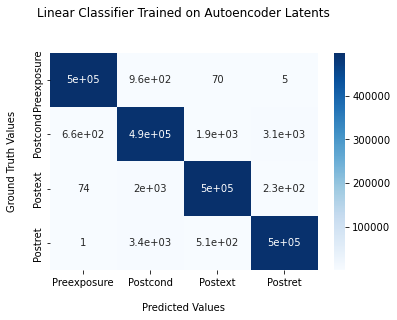

In [401]:
test_predictions = []
test_targets = []

for prediction_batch in predictions:
    for prediction in prediction_batch:
        test_predictions.append(torch.argmax(prediction, dim = 0).cpu().numpy())
        
for target_batch in targets:
    for target in target_batch:
        test_targets.append(torch.argmax(target, dim = 0).cpu().numpy())

from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(test_targets, test_predictions)

print(cf_matrix)

import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Linear Classifier Trained on Autoencoder Latents\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Ground Truth Values\n');

ax.xaxis.set_ticklabels(['Preexposure', 'Postcond', 'Postext', 'Postret'])
ax.yaxis.set_ticklabels(['Preexposure', 'Postcond', 'Postext', 'Postret'])

plt.show()

# Fused Model

In [13]:
class FusedEncodingModel(nn.Module):
    def __init__(self, autoencoder_model, mlp_model2, autoencoder_model_weights_path, mlp_model_weights_path):
        super().__init__()
            
        INPUT_DIM = 32
        OUTPUT_DIM = 4

        mlp_model2 = MLP(INPUT_DIM, OUTPUT_DIM)

        self.autoencoder_model = autoencoder_model
        self.autoencoder_model.load_state_dict(torch.load(autoencoder_model_weights_path))
        
        self.encoder = self.autoencoder_model.module.encoder
        
        self.mlp_model = mlp_model2
        self.mlp_model.load_state_dict(torch.load(mlp_model_weights_path))

    def forward(self, x):
        latent_representation = self.encoder(x)
        class_prediction = self.mlp_model(latent_representation)
        
        return class_prediction

In [16]:
fused_model = FusedEncodingModel(ae_model_mse, model, "new_architecture_MSE_e2400.p", "./LinearClassifierModels/control_exclusive_e990_v0.9934460899314365.p")
fused_model = fused_model.to(device)
fused_model.eval()

FusedEncodingModel(
  (autoencoder_model): DataParallel(
    (module): newAE(
      (encoder): ResNet18Enc(
        (ResNet18): ResNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): BasicBlock(
              (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (relu): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (1): B

# GradCAM

In [17]:
random.seed(42)

random_indices = []
for i in range(8):
    random_indices.append(random.randint(0, len(testing_frames)))

In [18]:
random_indices

[1340975, 233478, 52451, 1555144, 576778, 513575, 468106, 292632]

In [19]:
random_images = []
for index in random_indices:
    name = testing_frames[index]
    if "preexposure" in name:
        append_name = "/media/data_cifs/anagara8/preexposure_action/"
    elif "postcond" in name:
        append_name = "/media/data_cifs/anagara8/postcond_action/"
    elif "postext" in name:
        append_name = "/media/data_cifs/anagara8/postext_action/"
    elif "postret" in name:
        append_name = "/media/data_cifs/anagara8/postret_action/"
    random_images.append(append_name + name)

In [20]:
random_images

['/media/data_cifs/anagara8/postret_action/FC-A_08-15-18_postretvideo_2018Y_08M_18D_12h_03m_44s_cam_17202345-0000_8100.jpg',
 '/media/data_cifs/anagara8/postret_action/FC-C_1-6_postret_10-19_10-video_2018Y_10M_23D_07h_42m_22s_cam_17202338-0000_23619.jpg',
 '/media/data_cifs/anagara8/postret_action/FC-C_1-6_postret_10-19_10-video_2018Y_10M_21D_20h_42m_00s_cam_17202342-0000_34413.jpg',
 '/media/data_cifs/anagara8/postcond_action/FC-D_postcond_W2_06-06-2019video_2019Y_06M_06D_12h_09m_19s_cam_6394837-0000_31365.jpg',
 '/media/data_cifs/anagara8/postext_action/FC-A_08-15-18_postextvideo_2018Y_08M_15D_17h_58m_45s_cam_17202346-0000_72243.jpg',
 '/media/data_cifs/anagara8/preexposure_action/FC-D_preexposure_W1_05-31-2019_comp2video_2019Y_05M_31D_21h_09m_25s_cam_6394846-0000_98901.jpg',
 '/media/data_cifs/anagara8/preexposure_action/FC-D_preexposure_W1_06-01-2019video_2019Y_06M_01D_20h_45m_01s_cam_6394836-0000_7605.jpg',
 '/media/data_cifs/anagara8/postext_action/FC-C_1-6_postext_10-17_10-19vid

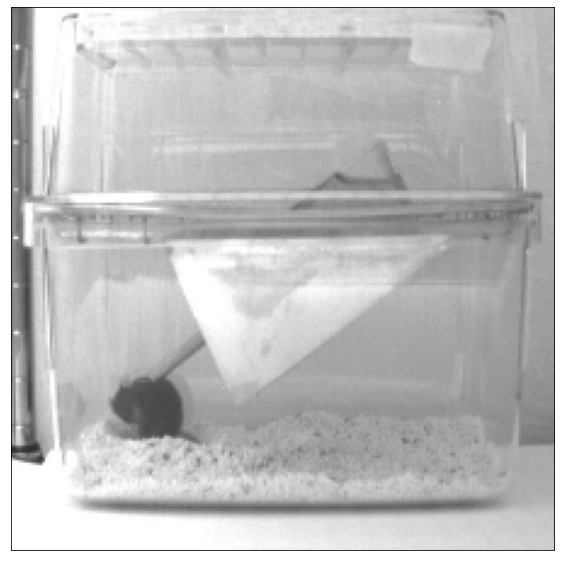

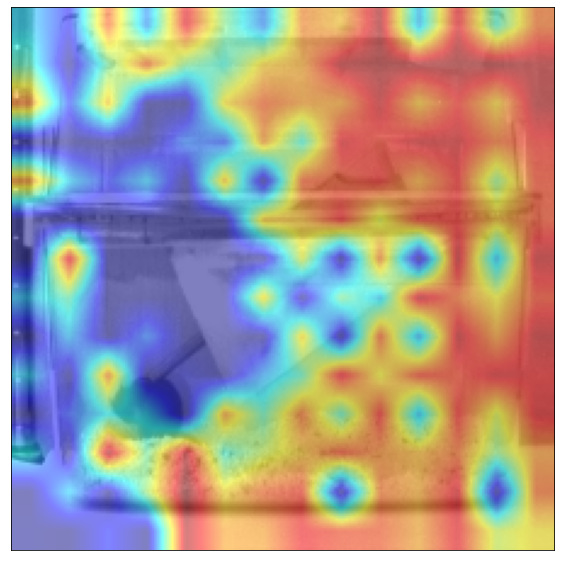

In [28]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad, LayerCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

current_image = random_images[4]

def show_gradcam_for_image(file_name):
    test_image = cv2.imread(file_name)
    test_image = cv2.resize(test_image, (224, 224))
    input_tensor = torchvision.transforms.functional.to_tensor(test_image/255.).unsqueeze(0).float()
    
    grayscale_cam = cam(input_tensor=input_tensor, eigen_smooth=True)
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(test_image/255., grayscale_cam, use_rgb=True)
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(visualization)

target_layers = [fused_model.encoder.ResNet18.layer3[-1]]
test_image = current_image
test_image = cv2.imread(test_image)
test_image = cv2.resize(test_image, (224, 224))
plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.imshow(test_image)

cam = LayerCAM(model=fused_model, target_layers=target_layers, use_cuda=True)
show_gradcam_for_image(current_image)